# Coding Setup

### Load Packages

In [ ]:
# All packages (see requirements.txt)

## Data Collection and Processing
import pandas as pd
import numpy as np
from collections import defaultdict

## System and Environment
import os
from dotenv import load_dotenv
import glob
import time
from IPython.core.display import HTML

## Api calling
import requests
from opencage.geocoder import OpenCageGeocode
import gender_guesser.detector as gender
from pathlib import Path
import logging

## Regression Analysis
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

## Math operations
from math import radians, sin, cos, sqrt, atan2

## Correlation and Variance Inflation Factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

## Graphs and Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MultipleLocator

## Geospatial Analysis
import geopandas as gpd
from shapely.geometry import box
from matplotlib.ticker import LogLocator, FuncFormatter

### Set Working Environment

In [2]:
# ---insert your path here ---
os.chdir('/Users/janlinzner/Projects/thesis-spatial-seed-syndication') 

### Load Api-keys

In [3]:
# load api keys from .env file or insert the key directly
load_dotenv()
geocage = os.getenv("geocage")
genderize = os.getenv("genderize")

### Create Harvesine Formula
[How to calculate the harvesine formula](https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula)

In [4]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371 

    phi1, phi2 = radians(lat1), radians(lat2)
    d_phi = radians(lat2 - lat1)
    d_lambda = radians(lon2 - lon1)

    a = sin(d_phi / 2) ** 2 + cos(phi1) * cos(phi2) * sin(d_lambda / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

# Data Collection

![Data Generation](data_generation.png)

## Data Sources Overview

## Data Loading and Preparation

### A: Companies

#### Companies: Load Data

Load all company files from `data/companies`

In [5]:
root_directory = 'data/companies'

df_list = []

selected_columns = [
    "Organization Name", "Organization Name URL", "Description", "Industry Groups", "Headquarters Location",
    "Founded Date", "Number of Founders", "Last Equity Funding Type", "Exit Date", "Founders" 
]

for subdir, _, _ in os.walk(root_directory):
    csv_files = glob.glob(os.path.join(subdir, '*.csv'))
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")

final_df = pd.concat(df_list, ignore_index=True)

companies = final_df[selected_columns].copy()

Rename the variables to small letters with underscore

In [6]:
companies = companies.rename(columns={
    "Organization Name": "organization_name",
    "Organization Name URL": "organization_name_url",
    "Description": "organization_description",
    "Industry Groups": "industry_groups",
    "Headquarters Location": "hq_location",
    "Founded Date": "founded_date",
    "Number of Founders": "number_of_founders",
    "Last Equity Funding Type": "last_equity_funding_type",
    "Exit Date": "exit_date",
    "Founders": "founders"
})

#### Companies: Clean Data

Convert data variables to date types

In [7]:
date_cols = ["founded_date"]
for col in date_cols:
    companies[col] = pd.to_datetime(companies[col], errors="coerce")

Get `founding_year`

In [8]:
companies["founded_year"] = companies["founded_date"].dt.year
companies.drop(columns=["founded_date"])

,organization_name,organization_name_url,organization_description,industry_groups,hq_location,number_of_founders,last_equity_funding_type,exit_date,founders,founded_year
0,DePoly,https://www.crunchbase.com/organization/depoly,DePoly is a PET-to-raw-material recycling comp...,"Science and Engineering, Sustainability","Sion, Valais, Switzerland",3.0,Seed,NaN,"Bardiya Valizadeh, Christopher Ireland, Samant...",2020
1,Hilo,https://www.crunchbase.com/organization/aktiia,Hilo is a healthcare company that provides blo...,"Artificial Intelligence (AI), Consumer Electro...","Neuchâtel, Neuchatel, Switzerland",3.0,Series B,NaN,"Josep Sola, Mattia Bertschi, Raghav Gupta",2018
2,Sygnum,https://www.crunchbase.com/organization/sygnum,Sygnum is a digital asset banking group that e...,"Blockchain and Cryptocurrency, Financial Servi...","Zürich, Zurich, Switzerland",3.0,Series C,NaN,"Gerald Goh, Luka Muller, Mathias Imbach",2017
3,HAYA Therapeutics,https://www.crunchbase.com/organization/haya-t...,HAYA Therapeutics is a biopharmaceutical compa...,"Biotechnology, Health Care, Science and Engine...","Lausanne, Vaud, Switzerland",2.0,Undisclosed,NaN,"Daniel Blessing, Samir Ounzain",2017
4,Squirro,https://www.crunchbase.com/organization/squirro,Squirro is a software company that utilizes Au...,"Artificial Intelligence (AI), Data and Analyti...","Zürich, Zurich, Switzerland",4.0,Private Equity,NaN,"Dorian Selz, Felix Hürlimann, Patrice Neff, To...",2012
...,...,...,...,...,...,...,...,...,...,...
23093,OutdoorCompute,https://www.crunchbase.com/organization/outdoo...,OutdoorCompute's liquid immersion cooling tech...,NaN,"Benningbroek, Noord-Holland, The Netherlands",NaN,Seed,NaN,NaN,2023
23094,NEKOD,https://www.crunchbase.com/organization/nekod,NEKOD is a platform designed for business auto...,"Artificial Intelligence (AI), Data and Analyti...","Amsterdam, Noord-Holland, The Netherlands",NaN,Pre-Seed,NaN,NaN,2024
23095,Kvikk Insurance,https://www.crunchbase.com/organization/kvikk-...,Kvikk is a digital insurance platform.,Financial Services,"Bergen, Noord-Holland, The Netherlands",NaN,Pre-Seed,NaN,NaN,2021
23096,Dynamicpixels,https://www.crunchbase.com/organization/dynami...,"PaaS,Video games,Back-end","Gaming, Software","Delft, Zuid-Holland, The Netherlands",NaN,Pre-Seed,NaN,NaN,2023


Provide `company_id` with padding zeros (e.g. 000001)

In [9]:
companies.reset_index(drop=True, inplace=True)
companies["company_id"] = companies.index + 1
companies["company_id"] = companies["company_id"].apply(lambda x: f"{x:06d}")
companies["company_id"] = companies["company_id"].astype("string")

cols = ["company_id"] + [col for col in companies.columns if col != "company_id"]
companies = companies[cols]

Fill missing values in `number_of_founders` with mean

In [10]:
mean_founders = companies["number_of_founders"].mean(skipna=True)
companies["number_of_founders"] = companies["number_of_founders"].fillna(round(mean_founders)).astype(int)

Create `exit_binary` (True if value inside `exit_date`)

In [11]:
companies.loc[:, "exit_binary"]  = companies["exit_date"].notna().astype(int)
companies["exit_binary"] = companies["exit_binary"].astype(bool)

Add geocoding and get `longitude` and `latitude` data

In [12]:
data_dir = Path("data/locations")
data_dir.mkdir(parents=True, exist_ok=True)
cache_file = data_dir / "location_cache.csv"
BASE_URL = "https://api.opencagedata.com/geocode/v1/json"
API_KEY = geocage
DELAY = 0.5

logging.basicConfig(level=logging.INFO, format="%(message)s")

def load_cache(path):
    if path.exists():
        return pd.read_csv(path)
    df = pd.DataFrame(columns=["hq_location","latitude","longitude"])
    df.to_csv(path, index=False)
    return df

def geocode(companies, loc_col="hq_location"):
    cache = load_cache(cache_file)
    cache_map = dict(zip(cache.hq_location, zip(cache.latitude, cache.longitude)))
    results, new = [], []

    for i, loc in enumerate(companies[loc_col].dropna().unique(), 1):
        if not loc.strip():
            lat, lng, tag = None, None, 'blank'
        elif loc in cache_map:
            lat, lng, tag = *cache_map[loc], 'cached'
        else:
            try:
                r = requests.get(BASE_URL, params={"key":API_KEY, "q":loc, "limit":1})
                data = r.json().get('results', [])
                lat, lng = data[0]['geometry']['lat'], data[0]['geometry']['lng'] if data else (None, None)
            except:
                lat, lng = None, None
            new.append({'hq_location':loc,'latitude':lat,'longitude':lng})
            tag = 'fetched'
            time.sleep(DELAY)

        logging.info(f"[{i}/{len(cache_map)+len(new)}] ({tag}) {loc!r} → {lat}, {lng}")
        results.append({'hq_location':loc,'latitude':lat,'longitude':lng})

    if new:
        pd.concat([cache, pd.DataFrame(new)]).drop_duplicates('hq_location').to_csv(cache_file, index=False)
    return companies.merge(pd.DataFrame(results), on='hq_location', how='left')

companies = geocode(companies, 'hq_location')

[1/4500] (cached) 'Sion, Valais, Switzerland' → 46.2311749, 7.3588795
[2/4500] (cached) 'Neuchâtel, Neuchatel, Switzerland' → 46.9895828, 6.9292641
[3/4500] (cached) 'Zürich, Zurich, Switzerland' → 47.3744489, 8.5410422
[4/4500] (cached) 'Lausanne, Vaud, Switzerland' → 46.5218269, 6.6327025
[5/4500] (cached) 'Zug, Zug, Switzerland' → 47.1679898, 8.5173652
[6/4500] (cached) 'Sankt Gallen, Sankt Gallen, Switzerland' → 47.425618, 9.3762397
[7/4500] (cached) 'Kemptthal, Zurich, Switzerland' → 47.4528517, 8.7058075
[8/4500] (cached) 'Basel, Basel-Stadt, Switzerland' → 47.5581077, 7.5878261
[9/4500] (cached) 'Baar, Zug, Switzerland' → 47.1951976, 8.5253985
[10/4500] (cached) 'Bern, Bern, Switzerland' → 46.9484742, 7.4521749
[11/4500] (cached) 'Lugano, Ticino, Switzerland' → 46.0050102, 8.9520281
[12/4500] (cached) 'Zofingen, Aargau, Switzerland' → 47.288491, 7.9458259
[13/4500] (cached) 'Horgen, Zurich, Switzerland' → 47.260692, 8.5976831
[14/4500] (cached) 'Monthey, Valais, Switzerland' → 4

Add the homecountry (`hq_country`)

In [13]:
companies["hq_country"] = companies["hq_location"].apply(lambda x: x.split(',')[-1].strip() if pd.notna(x) else None)

Add startup ecosystem binary (`hub_binary`) if next hotspot less than 100km

In [14]:
hotspot_data = [
    {"city": "London",       "lat": 51.5074, "lng": -0.1278},
    {"city": "Paris",        "lat": 48.8566, "lng": 2.3522},
    {"city": "Berlin",       "lat": 52.5200, "lng": 13.4050},
    {"city": "Stockholm",    "lat": 59.3293, "lng": 18.0686},
    {"city": "Munich",       "lat": 48.1351, "lng": 11.5820},
    {"city": "Helsinki",     "lat": 60.1695, "lng": 24.9354},
    {"city": "Madrid",       "lat": 40.4168, "lng": -3.7038},
    {"city": "Dublin",       "lat": 53.3498, "lng": -6.2603},
    {"city": "Tallinn",      "lat": 59.4370, "lng": 24.7536},
    {"city": "Copenhagen",   "lat": 55.6761, "lng": 12.5683},
    {"city": "Milan",        "lat": 45.4642, "lng": 9.1900},
    {"city": "Zurich",       "lat": 47.3769, "lng": 8.5417},
    {"city": "Oslo",         "lat": 59.9139, "lng": 10.7522},
    {"city": "Cambridge",    "lat": 52.2053, "lng": 0.1218},
    {"city": "Kyiv",         "lat": 50.4501, "lng": 30.5234},
    {"city": "Vienna",       "lat": 48.2082, "lng": 16.3738},
    {"city": "Brussels",     "lat": 50.8503, "lng": 4.3517},
    {"city": "Manchester",   "lat": 53.4808, "lng": -2.2426},
    {"city": "Lisbon",       "lat": 38.7169, "lng": -9.1399},
    {"city": "Prague",       "lat": 50.0755, "lng": 14.4378},
    {"city": "Warsaw",       "lat": 52.2297, "lng": 21.0122},
    {"city": "Hamburg",      "lat": 53.5511, "lng": 9.9937},
    {"city": "Oxford",       "lat": 51.7520, "lng": -1.2577},
    {"city": "Amsterdam",    "lat": 52.3676, "lng": 4.9041},
    {"city": "Barcelona",    "lat": 41.3851, "lng": 2.1734},
    {"city": "Lausanne",     "lat": 46.5197, "lng": 6.6323},
]

hotspots_df = pd.DataFrame(hotspot_data)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

def min_dist_to_hotspot(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return float('inf')
    return hotspots_df.apply(
        lambda r: haversine(lat, lon, r["lat"], r["lng"]), axis=1
    ).min()

companies["latitude"]  = pd.to_numeric(companies["latitude"],  errors="coerce")
companies["longitude"] = pd.to_numeric(companies["longitude"], errors="coerce")

companies["distance_to_hub"] = companies.apply(
    lambda r: min_dist_to_hotspot(r["latitude"], r["longitude"]), axis=1
)
companies["hub_binary"] = (companies["distance_to_hub"] < 20).astype(bool)

Top 5 and no Top 5 distinction

In [15]:
top_10_cities = ["London", "Paris", "Berlin", "Amsterdam", "Stockholm", "Barcelona", "Munich", "Helsinki", "Tallinn", "Copenhagen"]
hotspots_top_10 = hotspots_df[hotspots_df["city"].isin(top_10_cities)]
hotspots_rest = hotspots_df[~hotspots_df["city"].isin(top_10_cities)]

def min_dist_to_top_10(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return float('inf')
    return hotspots_top_10.apply(
        lambda r: haversine(lat, lon, r["lat"], r["lng"]), axis=1
    ).min()

def min_dist_to_rest(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return float('inf')
    return hotspots_rest.apply(
        lambda r: haversine(lat, lon, r["lat"], r["lng"]), axis=1
    ).min()

companies["hub_top_10"] = companies.apply(
    lambda r: min_dist_to_top_10(r["latitude"], r["longitude"]) < 20, axis=1
)
companies["hub_rest"] = companies.apply(
    lambda r: (min_dist_to_rest(r["latitude"], r["longitude"]) < 20) and not r["hub_top_10"], axis=1
)

Business orientation (B2B or B2C)<br>
<sub>Gathered through LLM-approach (see notebook: )<sub>

In [16]:
focus = pd.read_csv('data/business_focus/companies_business_focus_save.csv')
url_to_b2b = dict(zip(focus['Organization Name URL'], focus['B2B Binary']))
companies['b2b'] = companies['organization_name_url'].map(url_to_b2b)
df_missing_b2b = companies[companies['b2b'].isna()]
df_missing_b2b.to_csv('data/business_focus/df_missing_b2b.csv', index=False)

GICS Groups

In [17]:
companies["industry_groups"] = companies["industry_groups"].fillna('').str.replace(r'\s*,\s*', ',', regex=True)
dummies = companies["industry_groups"].str.get_dummies(sep=',').astype(bool)
companies = pd.concat([companies, dummies], axis=1)

In [18]:
to_move = [
    "Administrative Services", "Advertising", "Agriculture and Farming",
    "Apps", "Artificial Intelligence (AI)", "Biotechnology",
    "Blockchain and Cryptocurrency", "Clothing and Apparel",
    "Commerce and Shopping", "Community and Lifestyle",
    "Consumer Electronics", "Consumer Goods", "Content and Publishing",
    "Data and Analytics", "Design", "Education", "Energy", "Events",
    "Financial Services", "Food and Beverage", "Gaming",
    "Government and Military", "Hardware", "Health Care",
    "Information Technology", "Internet Services",
    "Lending and Investments", "Manufacturing", "Media and Entertainment",
    "Messaging and Telecommunications", "Mobile", "Music and Audio",
    "Natural Resources", "Navigation and Mapping", "Other", "Payments",
    "Platforms", "Privacy and Security", "Professional Services",
    "Real Estate", "Sales and Marketing", "Science and Engineering",
    "Social Impact", "Software", "Sports", "Sustainability",
    "Transportation", "Travel and Tourism", "Video"
]
cols_to_move = [c for c in to_move if c in companies.columns]

new_order = [c for c in companies.columns if c not in cols_to_move] + cols_to_move
companies = companies[new_order]

gics_map = {
    "Energy": "energy",
    "Blockchain and Cryptocurrency": "information_technology",
    "Natural Resources": "materials",
    "Administrative Services": "industrials",
    "Design": "industrials",
    "Government and Military": "industrials",
    "Manufacturing": "industrials",
    "Professional Services": "industrials",
    "Science and Engineering": "industrials",
    "Social Impact": "industrials",
    "Transportation": "industrials",
    "Clothing and Apparel": "consumer_discretionary",
    "Commerce and Shopping": "consumer_discretionary",
    "Community and Lifestyle": "consumer_discretionary",
    "Consumer Electronics": "consumer_discretionary",
    "Consumer Goods": "consumer_discretionary",
    "Education": "consumer_discretionary",
    "Events": "consumer_discretionary",
    "Sports": "consumer_discretionary",
    "Travel and Tourism": "consumer_discretionary",
    "Agriculture and Farming": "consumer_staples",
    "Food and Beverage": "consumer_staples",
    "Biotechnology": "health_care",
    "Health Care": "health_care",
    "Financial Services": "financials",
    "Lending and Investments": "financials",
    "Payments": "financials",
    "Apps": "information_technology",
    "Artificial Intelligence (AI)": "information_technology",
    "Blockchain and Cryptocurrency": "information_technology",
    "Data and Analytics": "information_technology",
    "Hardware": "information_technology",
    "Information Technology": "information_technology",
    "Internet Services": "information_technology",
    "Mobile": "information_technology",
    "Navigation and Mapping": "information_technology",
    "Platforms": "information_technology",
    "Privacy and Security": "information_technology",
    "Software": "information_technology",
    "Advertising": "communication_services",
    "Content and Publishing": "communication_services",
    "Gaming": "communication_services",
    "Media and Entertainment": "communication_services",
    "Messaging and Telecommunications": "communication_services",
    "Music and Audio": "communication_services",
    "Sales and Marketing": "communication_services",
    "Video": "communication_services",
    "Sustainability": "utilities",
    "Real Estate": "real_estate",
    "Other": "other",
}

head_to_orig = defaultdict(list)
for orig, head in gics_map.items():
    head_to_orig[head].append(orig)

for head, orig_cols in head_to_orig.items():
    companies[head] = companies[orig_cols].any(axis=1)

to_drop = [c for c in cols_to_move if gics_map[c] != c]
companies.drop(columns=to_drop, inplace=True)

gics_heads = list(head_to_orig.keys())
final_order = [c for c in companies.columns if c not in gics_heads] + gics_heads
companies = companies[final_order]

### B: Seed Rounds

#### Rounds: Load Data

Load all rounds from `data/rounds`

In [19]:
root_directory = 'data/rounds'

selected_columns = [
    'Transaction Name URL', 'Organization Name', 'Organization Name URL', 'Funding Type', 'Money Raised (in USD)', 'Announced Date', 'Lead Investors', 'Investor Names'
]

df_list = []

for subdir, _, _ in os.walk(root_directory):
    csv_files = glob.glob(os.path.join(subdir, '*.csv'))
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")

final_df = pd.concat(df_list, ignore_index=True)

rounds = final_df[selected_columns].copy()

#### Rounds: Clean Data

Drop duplicate rounds

In [20]:
rounds = rounds.drop_duplicates()

Rename the variables

In [21]:
rounds = rounds.rename(columns={
    "Transaction Name URL": "transaction_name_url",
    "Organization Name": "organization_name",
    "Organization Name URL": "organization_name_url",
    "Funding Type": "funding_type",
    "Money Raised (in USD)": "money_raised_usd",
    "Announced Date": "announced_date",
    "Lead Investors": "lead_investors",
    "Investor Names": "investor_names"
})

Drop all rounds other than Pre-Seed or Seed

In [22]:
rounds = rounds[rounds['funding_type'].isin(['Pre-Seed', 'Seed'])]

Change `announced_date` to date type

In [23]:
rounds['announced_date'] = pd.to_datetime(rounds['announced_date'], errors='coerce')

Add IDs (`round_id`)

In [24]:
rounds.reset_index(drop=True, inplace=True)
rounds['round_id'] = rounds.index + 1
rounds['round_id'] = rounds['round_id'].apply(lambda x: f"{x:06d}")
rounds['round_id'] = rounds['round_id'].astype('string')

cols = ['round_id'] + [c for c in rounds.columns if c != 'round_id']
rounds = rounds[cols]

### C: Investors

#### Investors: Load Data

Load all files from `data/investor`

In [25]:
csv_dir = 'data/investor'
columns = [
    "Organization/Person Name", "Organization/Person Name URL", "Investor Type",
    "Location", "Description", "Founded Date", "CB Rank (Investor)"
]

files = glob.glob(os.path.join(csv_dir, '*.csv'))
dfs = [pd.read_csv(f) for f in files if os.path.getsize(f) > 0]

if dfs:
    investors = pd.concat(dfs, ignore_index=True)
    investors = investors[[col for col in columns if col in investors.columns]]
    investors.drop_duplicates(subset=["Organization/Person Name", "Organization/Person Name URL"], inplace=True)
else:
    investors = pd.DataFrame(columns=columns)

#### Investors: Clean Data

Rename the variables

In [26]:
investors = investors.rename(columns={
    "Organization/Person Name": "organization_person_name",
    "Organization/Person Name URL": "organization_person_name_url",
    "Investor Type": "investor_type",
    "Location": "hq_location",
    "Description": "description",
    "Founded Date": "founded_date",
    "CB Rank (Investor)": "cb_rank_investor"
})

Convert `founded_date` into the date type

In [27]:
date_cols = ["founded_date"]
for col in date_cols:
    investors[col] = pd.to_datetime(investors[col], errors='coerce')

Provide `investor_id`

In [28]:
investors.reset_index(drop=True, inplace=True)
investors['investor_id'] = investors.index + 1
investors['investor_id'] = investors['investor_id'].apply(lambda x: f"{x:06d}")
investors['investor_id'] = investors['investor_id'].astype('string')

cols = ['investor_id'] + [c for c in investors.columns if c != 'investor_id']
investors = investors[cols]

Add `longitude` and `latitude` pairs

In [29]:
data_dir = Path("data/locations")
data_dir.mkdir(parents=True, exist_ok=True)
cache_file = data_dir / "location_cache.csv"
BASE_URL = "https://api.opencagedata.com/geocode/v1/json"
API_KEY = geocage
DELAY = 0.5

logging.basicConfig(level=logging.INFO, format="%(message)s")

def load_cache(path):
    if path.exists():
        return pd.read_csv(path)
    df = pd.DataFrame(columns=["hq_location", "latitude", "longitude"])
    df.to_csv(path, index=False)
    return df

def geocode_locations(df, loc_col="hq_location"):
    cache = load_cache(cache_file)
    cache_map = dict(zip(cache.hq_location, zip(cache.latitude, cache.longitude)))
    results = []
    new_entries = []

    unique_locs = df[loc_col].dropna().unique()
    total = len(unique_locs)

    for idx, loc in enumerate(unique_locs, start=1):
        if not loc.strip():
            lat = lng = None
            tag = 'blank'
        elif loc in cache_map:
            lat, lng = cache_map[loc]
            tag = 'cached'
        else:
            try:
                r = requests.get(BASE_URL, params={"key": API_KEY, "q": loc, "limit": 1}, timeout=10)
                r.raise_for_status()
                res = r.json().get('results')
                if res:
                    lat = res[0]['geometry']['lat']
                    lng = res[0]['geometry']['lng']
                else:
                    lat = lng = None
            except Exception as e:
                logging.warning(f"Error fetching '{loc}': {e}")
                lat = lng = None
            new_entries.append({'hq_location': loc, 'latitude': lat, 'longitude': lng})
            tag = 'fetched'
            time.sleep(DELAY)

        logging.info(f"[{idx}/{total}] ({tag}) {loc!r} → {lat}, {lng}")
        results.append({'hq_location': loc, 'latitude': lat, 'longitude': lng})

    if new_entries:
        updated = pd.concat([cache, pd.DataFrame(new_entries)], ignore_index=True)
        updated.drop_duplicates(subset='hq_location', keep='first', inplace=True)
        updated.to_csv(cache_file, index=False)
        logging.info(f"Cache updated ({len(new_entries)} new entries)")

    coords_df = pd.DataFrame(results)
    return df.merge(coords_df, on='hq_location', how='left')

investors = geocode_locations(investors, 'hq_location')

[1/2830] (cached) 'Tokyo, Tokyo, Japan' → 35.6812546, 139.766706
[2/2830] (cached) 'London, England, United Kingdom' → 51.4893335, -0.1440551
[3/2830] (cached) 'Olten, Aargau, Switzerland' → 47.3085666, 7.8932696
[4/2830] (cached) 'Toronto, Ontario, Canada' → 43.6534817, -79.3839347
[5/2830] (cached) 'Muttenz, Basel-Landschaft, Switzerland' → 47.525113, 7.6477401
[6/2830] (cached) 'Mechelen-bovelingen, Limburg, Belgium' → 50.7427937, 5.2629291
[7/2830] (cached) 'Rome, Lazio, Italy' → 41.8933203, 12.4829321
[8/2830] (cached) 'Östermalm, Stockholms Lan, Sweden' → 59.3382751, 18.0718928
[9/2830] (cached) 'Mountain View, California, United States' → 37.3893889, -122.0832101
[10/2830] (cached) 'Charlotte, North Carolina, United States' → 35.2272086, -80.8430827
[11/2830] (cached) 'Bangalore, Karnataka, India' → 12.9767936, 77.590082
[12/2830] (cached) 'Vienna, Wien, Austria' → 48.1857192, 16.4221587
[13/2830] (cached) 'Hamburg, Hamburg, Germany' → 53.550341, 10.000654
[14/2830] (cached) 'Li

Get homecountry (`hq_country`)

In [30]:
investors['hq_country'] = investors['hq_location'].apply(lambda x: x.split(',')[-1].strip() if pd.notna(x) else None)

Investor Type

In [31]:
def parse_types(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return [t.strip().lower() for t in x]
    return [t.strip().lower() for t in str(x).split(",")]

keywords = [
    "accelerator",
    "incubator",
    "micro vc",
    "corporate venture capital",
    "angel group",
    "angel",
    "university program",
    "entrepreneurship program",
    "family investment office"
]

investors["type_list"] = investors["investor_type"].apply(parse_types)

for kw in keywords:
    col = kw.replace(" ", "_")
    investors[col] = investors["type_list"].apply(
        lambda types: any(kw in t for t in types)
    )

investors.drop(columns="type_list", inplace=True)

### D: Grants

#### Grants: Load Data

Load all grants from `data/grants`

In [32]:
root_directory = 'data/grants'

df_list = []

selected_columns = [
    "Transaction Name", "Organization Name", "Organization Name URL", "Announced Date", "Money Raised (in USD)", "Investor Names"
]

for subdir, _, _ in os.walk(root_directory):
    csv_files = glob.glob(os.path.join(subdir, '*.csv'))
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")

final_df = pd.concat(df_list, ignore_index=True)

grants = final_df[selected_columns].copy()

#### Grants: Data Cleaning

Renaming Variables

In [33]:
grants = grants.rename(columns={
    "Transaction Name": "transaction_name",
    "Organization Name": "organization_name",
    "Organization Name URL": "organization_name_url",
    "Announced Date": "announced_date",
    "Money Raised (in USD)": "money_raised_usd",
    "Investor Names": "investor_names"
})

`announced_date` into date type

In [34]:
cols = ["announced_date"]
for col in cols:
    grants[col] = pd.to_datetime(grants[col], errors='coerce')

### E: Angel Rounds

#### Angel Rounds: Load Data

Load all angel rounds from `data/angel`

In [35]:
root_directory = 'data/angel'

df_list = []

selected_columns = [
    "Transaction Name", "Organization Name", "Organization Name URL", "Announced Date", "Money Raised (in USD)", "Investor Names"
]

for subdir, _, _ in os.walk(root_directory):
    csv_files = glob.glob(os.path.join(subdir, '*.csv'))
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")

final_df = pd.concat(df_list, ignore_index=True)

angel = final_df[selected_columns].copy()

#### Angel Rounds: Data Cleaning

Renaming variables

In [36]:
angel = angel.rename(columns={
    "Transaction Name": "transaction_name",
    "Organization Name": "organization_name",
    "Organization Name URL": "organization_name_url",
    "Announced Date": "announced_date",
    "Money Raised (in USD)": "money_raised_usd",
    "Investor Names": "investor_names"
})

`announced_date` into date type

In [37]:
cols = ["announced_date"]
for col in cols:
    angel[col] = pd.to_datetime(angel[col], errors='coerce')

### F: Follow-on Rounds

#### Follow-on Rounds: Load Data

In [38]:
root_directory = 'data/follow-on'

df_list = []

selected_columns = [
    "Transaction Name", "Organization Name", "Organization Name URL", "Announced Date", "Money Raised (in USD)", "Investor Names"
]

for subdir, _, _ in os.walk(root_directory):
    csv_files = glob.glob(os.path.join(subdir, '*.csv'))
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")

final_df = pd.concat(df_list, ignore_index=True)

follow = final_df[selected_columns].copy()

#### Follow-on: Data Cleaning

Renaming Variables

In [39]:
follow = follow.rename(columns={
    "Transaction Name": "transaction_name",
    "Organization Name": "organization_name",
    "Organization Name URL": "organization_name_url",
    "Announced Date": "announced_date",
    "Money Raised (in USD)": "money_raised_usd",
    "Investor Names": "investor_names"
})

`announced_date` into date type

In [40]:
cols = ["announced_date"]
for col in cols:
    angel[col] = pd.to_datetime(angel[col], errors='coerce')

Generate `follow_year`<br>
<sub>Year of the follow-on round<sub>

In [41]:
follow['announced_date'] = pd.to_datetime(follow['announced_date'], errors='coerce')
follow['follow_year'] = follow['announced_date'].dt.year

Generate `follow`
<sub>Check if the company had a follow-on-round in general<sub>

In [42]:
companies['follow'] = companies['organization_name_url'].isin(follow['organization_name_url'])

Generate `follow_1`, `follow_2`, `follow_3`, `follow_4`

In [43]:
if 'latest_seed_round_date' not in companies.columns:
    seed_rounds  = rounds[rounds['funding_type'].isin(['Seed', 'Pre-Seed'])]
    latest_seed = seed_rounds.groupby('organization_name_url')['announced_date'].max()
    companies['latest_seed_round_date'] = companies['organization_name_url'].map(latest_seed)

follow_dates = follow[['organization_name_url', 'announced_date']].dropna()

def has_follow_within_years(org_url, seed_date, years):
    if pd.isna(seed_date):
        return False                     
    max_date = seed_date + pd.DateOffset(years=years)
    rounds   = follow_dates[
        (follow_dates['organization_name_url'] == org_url) &
        (follow_dates['announced_date'] <= max_date)        
    ]
    return not rounds.empty         

for y in [1, 2, 3, 4]:
    companies[f'follow_{y}'] = companies.apply(
        lambda r, yrs=y: has_follow_within_years(
            r['organization_name_url'],
            r['latest_seed_round_date'],
            yrs
        ),
        axis=1
    )

# Data Engineering

## Preparation

Create a help table `seed_help`<br>
<sub>`seed_help` lists all investor-investee pairs over all rounds<sub>

In [44]:
seed_help = rounds[["round_id", "organization_name_url", "investor_names", "funding_type"]].copy()
rounds_investors = seed_help.dropna(subset=["investor_names"])

seed_help["investor_names"] = seed_help["investor_names"].str.split(",")
seed_help = seed_help.explode("investor_names")
seed_help["investor_names"] = seed_help["investor_names"].str.strip()

seed_help = seed_help[seed_help["investor_names"] != ""]

seed_help = seed_help.merge(companies[["organization_name_url", "company_id"]], on="organization_name_url", how="left")

seed_help.reset_index(drop=True, inplace=True)

seed_help = seed_help[seed_help["company_id"].notna()].reset_index(drop=True)

Only keep investors in `seed_help`with an investor entry in `investors`

In [45]:
seed_help = seed_help.merge(
    investors[["organization_person_name", "investor_id"]],
    left_on="investor_names",
    right_on="organization_person_name",
    how="inner"
)

seed_help = seed_help.drop(columns=["organization_person_name"])

## Company

## Founding Team

### Female Founder<br>
Check if there is at least one female founder involved in the new venture. A founder is labeled as female based on the first name and the help of a dedicated library and the genderize-api.

Find all unique names to make the library/api requests more efficient

In [46]:
founders = companies[["company_id", "founders"]].copy()
founders = founders.dropna(subset=["founders"])
founders["founders"] = founders["founders"].astype(str)

founders = founders.assign(founder=founders["founders"].str.split(",")).explode("founder")
founders["founder"] = founders["founder"].str.strip()
founders = founders[founders["founder"] != ""]
founders = founders[["company_id", "founder"]].reset_index(drop=True)

prefixes = {"Dr.", "Dr", "Mr.", "Prof.", "PROF", "prof.", "St.", "2", "3", "Prof. Dr.", "Dr.-Ing.", "Dr. -Ing.", "Dr .", "dr."}

def extract_first_name(name):
    parts = name.strip().split()
    if not parts:
        return ""
    if parts[0] in prefixes:
        parts = parts[1:]
    if not parts:
        return ""
    return parts[0].split("-")[0]

founders["first_name"] = founders["founder"].apply(extract_first_name)

unique_first_names = founders["first_name"].dropna().unique()
unique_first_names_df = pd.DataFrame(unique_first_names, columns=["first_name"])

In [47]:
unique_first_names_df["gender"] = "unknown"

Some names are not detected and they are labeled as unknown. We clean the output and create a blank cell.

In [48]:
unknown_gender_df = unique_first_names_df[unique_first_names_df["gender"] == "unknown"].reset_index(drop=True)
unknown_gender_df["gender"] = ""

We call the [genderize](https://genderize.io) to analyze the remaining names. We cache the results.

In [49]:
API_KEY = genderize
CACHE_CSV = 'data/gender/gender_cache.csv'
API_URL = 'https://api.genderize.io'

if os.path.exists(CACHE_CSV):
    gender_cache = pd.read_csv(CACHE_CSV)
else:
    gender_cache = pd.DataFrame(columns=['first_name', 'gender'])

unknown_gender_df['first_name'] = unknown_gender_df['first_name'].str.lower()
gender_cache['first_name'] = gender_cache['first_name'].str.lower()

gender_cache = gender_cache.drop_duplicates(subset='first_name')

results = []

for name in unknown_gender_df['first_name']:
    cached_row = gender_cache[gender_cache['first_name'] == name]

    if not cached_row.empty:
        
        gender = cached_row['gender'].values[0]
    else:
        
        response = requests.get(API_URL, params={'name': name, 'apikey': API_KEY})
        if response.status_code == 200:
            data = response.json()
            gender = data.get('gender')
            
            gender_cache = pd.concat([gender_cache, pd.DataFrame([{
                'first_name': name,
                'gender': gender
            }])], ignore_index=True)
        else:
            gender = None  

    results.append(gender)

unknown_gender_df['gender'] = results

gender_cache.to_csv(CACHE_CSV, index=False)

The results are merged 

In [50]:
merged = unique_first_names_df.copy()
merged['first_name_lower'] = merged['first_name'].str.lower()
gender_cache['first_name_lower'] = gender_cache['first_name'].str.lower()

merged = merged.merge(
    gender_cache[['first_name_lower', 'gender']],
    on='first_name_lower',
    how='left',
    suffixes=('', '_cache')
)

merged['gender'] = merged['gender_cache'].combine_first(merged['gender'])

unique_first_names_df['gender'] = merged['gender']

In [51]:
founders = founders.merge(
    unique_first_names_df[['first_name', 'gender']],
    on='first_name',
    how='left'
)

`female_founder` is positive, if the company has at least one female team member in the founding team.

In [52]:
companies['female_founder'] = companies['company_id'].isin(
    founders[founders['gender'] == 'female']['company_id']
)

## Financing

### Number Seed Rounds <br>
<sub>Get `number_seed_rounds` for each company by counting all unique rounds in `rounds`.</sub>

In [53]:
seed_round_counts = rounds["organization_name_url"].value_counts()

companies["number_seed_rounds"] = companies["organization_name_url"].map(seed_round_counts).fillna(0).astype(int)

### Number Seed Investors <br>
<sub>Get the number_of_investors by counting all unique imvestors for a company in `seed_help`.<sub>

In [54]:
unique_investors_per_company = seed_help.groupby("company_id")["investor_id"].nunique()

companies["number_seed_investors"] = companies["company_id"].map(unique_investors_per_company).fillna(0).astype(int)

### Help-Variables: Seed Time Stamps <br>
<sub>Get `earliest_seed_round_date` and `latest_seed_round_date` as the gap between the first and last seed round.<sub>

In [55]:
first_round_date = rounds.groupby("organization_name_url")["announced_date"].min()
last_round_date = rounds.groupby("organization_name_url")["announced_date"].max()

companies["earliest_seed_round_date"] = companies["organization_name_url"].map(first_round_date)
companies["latest_seed_round_date"] = companies["organization_name_url"].map(last_round_date)

### Year First Seed Round<br>
<sub>Get `first_seed_round_year` as the year of the earliest seed round of the new venture.<sub>

In [56]:
companies["first_seed_round_year"] = companies["earliest_seed_round_date"].dt.year

### Help-Variable: Seed Funding<br>
<sub>Get `total_seed_funding_m` in millions USD by sum `money_raised_usd` over all seed investment rounds of the new venture.<sub>

In [57]:
company_seed_funding_m = (
    rounds.groupby("organization_name_url")["money_raised_usd"].sum() / 1_000_000
).reset_index()

company_seed_funding_m = company_seed_funding_m.rename(
    columns={"money_raised_usd": "total_seed_funding_m"}
)

companies = companies.merge(
    company_seed_funding_m, on="organization_name_url", how="left"
)

companies["total_seed_funding_m"] = companies["total_seed_funding_m"].fillna(0)

### Low Seed Funding<br>
<sub>`low_seed_funding` is positive if `total_seed_funding_m` is less than 0.25 m USD<sub>

In [58]:
companies["low_seed_funding"] = companies["total_seed_funding_m"] < 0.25 

### High Seed Funding<br>
<sub>`high_seed_funding` is positive if `total_seed_funding_m` is more than 4.75 m USD<sub>

In [59]:
companies["high_seed_funding"] = companies["total_seed_funding_m"] > 4.75

### Follow-on Seed Investor<br>
<sub>`follow_on_investor` is positive if one investor participates in more than 1 round.<sub>

In [60]:
seed_help['follow_on_investor'] = (
    seed_help.groupby(['company_id', 'investor_id'])['round_id'].transform('count') > 1
)

follow_on_any = seed_help.groupby("company_id")["follow_on_investor"].any()
companies["follow_on_investor"] = companies["company_id"].map(follow_on_any).infer_objects(copy=False).fillna(False)


/var/folders/n8/ynbdx9r10lv6l8yh1m_hmbsh0000gn/T/ipykernel_98815/2541892558.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  companies["follow_on_investor"] = companies["company_id"].map(follow_on_any).infer_objects(copy=False).fillna(False)


### Age<br>
<sub>`Age` of the company at the point of the first investment round as `earliest_seed_round_date` minus `founded_date` in months.<sub>

In [61]:
companies["age"] = (
    (companies["earliest_seed_round_date"] - companies["founded_date"]).dt.days // 30
)

### Pre Seed Round<br>
<sub>`pre_seed` is positive if the company raised a round with the `funding_type` = "Pre-Seed".<sub>

In [62]:
pre_seed_companies = set(rounds.loc[rounds['funding_type'] == 'Pre-Seed', 'organization_name_url'])
companies['pre_seed'] = companies['organization_name_url'].isin(pre_seed_companies)

### Duration of Seed Stage<br>
<sub>Months between first and last seed investment<sub>

In [63]:
companies["duration_seed_stage"] = (
    (companies["latest_seed_round_date"] - companies["earliest_seed_round_date"]).dt.days / 30.44
).round(1)

## Grants

### Grant before Seed<br>
<sub>Received a grants before seed funding<sub>

In [64]:
earliest_seed_round_map = companies.set_index('company_id')['earliest_seed_round_date']

def has_grant_before_seed(row):
    company_id = companies.loc[companies['organization_name_url'] == row['organization_name_url'], 'company_id']
    if company_id.empty or pd.isna(row['announced_date']):
        return False
    earliest_date = earliest_seed_round_map.get(company_id.values[0], pd.NaT)
    return pd.notna(earliest_date) and row['announced_date'] < earliest_date

grants['grant_before_seed'] = grants.apply(has_grant_before_seed, axis=1)

grant_before_seed_map = grants[grants['grant_before_seed']].groupby('organization_name_url').size() > 0
companies['grant_before_seed'] = companies['organization_name_url'].map(grant_before_seed_map).fillna(False).astype(bool)

/var/folders/n8/ynbdx9r10lv6l8yh1m_hmbsh0000gn/T/ipykernel_98815/2446606564.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  companies['grant_before_seed'] = companies['organization_name_url'].map(grant_before_seed_map).fillna(False).astype(bool)


## Angel Rounds

In [65]:
companies['angel_round_binary'] = companies['organization_name_url'].isin(angel['organization_name_url'])

## Investor

### No Syndication / Syndication<br>
<sub>Only one investor in the seed stage

In [66]:
companies["no_syndication"] = (companies["number_seed_investors"] == 1)

In [67]:
companies["syndication"] = (companies["number_seed_investors"] >= 2)

### Lead Investor in Seed<br>
<sub>Existence of an lead investor entry in at least one round in the seed stage<sub>

In [68]:
lead_investor_any = (
    rounds.groupby("organization_name_url")["lead_investors"]
    .apply(lambda x: x.notna() & (x.str.strip() != ""))
    .groupby("organization_name_url")
    .any()
)

companies["lead_investor_in_seed"] = companies["organization_name_url"].map(lead_investor_any).fillna(False)

/var/folders/n8/ynbdx9r10lv6l8yh1m_hmbsh0000gn/T/ipykernel_98815/3524646151.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  companies["lead_investor_in_seed"] = companies["organization_name_url"].map(lead_investor_any).fillna(False)


### All Homecountry Investors<br>
<sub>All investors from the same homecountry<sub>

In [69]:
def all_investors_from_homecountry(company_id):
    company_country = companies.loc[companies["company_id"] == company_id, "hq_country"].values[0]
    investor_countries = seed_help.loc[seed_help["company_id"] == company_id, "investor_id"].map(
        investors.set_index("investor_id")["hq_country"]
    )
    return investor_countries.notna().all() and (investor_countries == company_country).all()

companies["all_homecountry_investors_in_seed_binary"] = companies["company_id"].apply(all_investors_from_homecountry)

### US investor<br>
<sub>Participation of at least one investor from the united states<sub>

In [70]:
def has_us_investor(company_id):
    investor_ids = seed_help.loc[seed_help["company_id"] == company_id, "investor_id"]
    if investor_ids.empty:
        return False
    investor_countries = investors.set_index("investor_id").loc[investor_ids, "hq_country"]
    return (investor_countries == "United States").any()

companies["us_investor_binary"] = companies["company_id"].apply(has_us_investor)

### Regional Investor<br>
<sub>At least one investor is from the same region as the new venture (less than 100km distance)<sub>

In [71]:
def has_regional_seed_investor(company_id):
    company = companies.loc[companies["company_id"] == company_id]
    if company.empty or pd.isna(company.iloc[0]["latitude"]) or pd.isna(company.iloc[0]["longitude"]):
        return False
    lat1 = company.iloc[0]["latitude"]
    lon1 = company.iloc[0]["longitude"]
    investor_ids = seed_help.loc[seed_help["company_id"] == company_id, "investor_id"]
    if investor_ids.empty:
        return False
    investor_locs = investors.set_index("investor_id").loc[investor_ids, ["latitude", "longitude"]]
    investor_locs = investor_locs.dropna()
    if investor_locs.empty:
        return False
    for _, row in investor_locs.iterrows():
        lat2, lon2 = row["latitude"], row["longitude"]
        dist = haversine(lat1, lon1, lat2, lon2)
        if dist <= 20:
            return True
    return False

companies["regional_seed_investor_binary"] = companies["company_id"].apply(has_regional_seed_investor)

### Regional Institutional Investor<br>
<sub>There is at least one institutional investor (defined by no person = angel) in the seed stage. Threshold is at 30km.<sub>

In [72]:
def is_institutional_investor(investor_id):
    url = investors.loc[investors["investor_id"] == investor_id, "organization_person_name_url"].values[0]
    return "organization" in url

def has_regional_institutional_investor(company_id):
    company = companies.loc[companies["company_id"] == company_id]
    if company.empty or pd.isna(company.iloc[0]["latitude"]) or pd.isna(company.iloc[0]["longitude"]):
        return False
    lat1 = company.iloc[0]["latitude"]
    lon1 = company.iloc[0]["longitude"]
    investor_ids = seed_help.loc[seed_help["company_id"] == company_id, "investor_id"]
    if investor_ids.empty:
        return False
    investor_locs = investors.set_index("investor_id").loc[investor_ids, ["latitude", "longitude", "organization_person_name_url"]]
    investor_locs = investor_locs.dropna()
    if investor_locs.empty:
        return False
    for _, row in investor_locs.iterrows():
        if "organization" in row["organization_person_name_url"]:
            lat2, lon2 = row["latitude"], row["longitude"]
            dist = haversine(lat1, lon1, lat2, lon2)
            if dist <= 20:
                return True
    return False

companies["regional_seed_investor_institutional_binary"] = companies["company_id"].apply(has_regional_institutional_investor)

### Regional Venture Capital Investor<br>


In [73]:
def has_regional_venture_capital_investor(company_id):
    company = companies.loc[companies["company_id"] == company_id]
    if company.empty or pd.isna(company.iloc[0]["latitude"]) or pd.isna(company.iloc[0]["longitude"]):
        return False
    lat1 = company.iloc[0]["latitude"]
    lon1 = company.iloc[0]["longitude"]
    investor_ids = seed_help.loc[seed_help["company_id"] == company_id, "investor_id"]
    if investor_ids.empty:
        return False
    investor_locs = investors.set_index("investor_id").loc[investor_ids, ["latitude", "longitude", "investor_type"]]
    investor_locs = investor_locs.dropna(subset=["latitude", "longitude", "investor_type"])
    if investor_locs.empty:
        return False
    for _, row in investor_locs.iterrows():
        types = [t.strip().lower() for t in str(row["investor_type"]).split(",")]
        if any("venture capital" in t for t in types):
            lat2, lon2 = row["latitude"], row["longitude"]
            dist = haversine(lat1, lon1, lat2, lon2)
            if dist <= 20:
                return True
    return False

companies["regional_seed_investor_venture_capital_binary"] = companies["company_id"].apply(has_regional_venture_capital_investor)

### Regional Accelerator / Incubation / Venture Capital

In [74]:
def has_regional_accelerator_or_incubator_investor(company_id):
    company = companies.loc[companies["company_id"] == company_id]
    if company.empty or pd.isna(company.iloc[0]["latitude"]) or pd.isna(company.iloc[0]["longitude"]):
        return False
    lat1 = company.iloc[0]["latitude"]
    lon1 = company.iloc[0]["longitude"]
    investor_ids = seed_help.loc[seed_help["company_id"] == company_id, "investor_id"]
    if investor_ids.empty:
        return False
    investor_locs = investors.set_index("investor_id").loc[investor_ids, ["latitude", "longitude", "investor_type"]]
    investor_locs = investor_locs.dropna(subset=["latitude", "longitude", "investor_type"])
    if investor_locs.empty:
        return False
    for _, row in investor_locs.iterrows():
        types = [t.strip().lower() for t in str(row["investor_type"]).split(",")]
        if any("accelerator" in t or "incubator" in t or "venture capital" in t for t in types):
            lat2, lon2 = row["latitude"], row["longitude"]
            dist = haversine(lat1, lon1, lat2, lon2)
            if dist <= 20:
                return True
    return False

companies["regional_accelerator_or_incubator_or_venture_capital_investor_binary"] = companies["company_id"].apply(has_regional_accelerator_or_incubator_investor)

### Regional Angel Investor<br>
<sub>Binary is positive if the companies has an angel investor inside of 30km in the seed stage<sub>

In [75]:
def has_angel_investor_within_30km(company_id):
    company = companies.loc[companies["company_id"] == company_id]
    if company.empty or pd.isna(company.iloc[0]["latitude"]) or pd.isna(company.iloc[0]["longitude"]):
        return False
    lat1 = company.iloc[0]["latitude"]
    lon1 = company.iloc[0]["longitude"]
    investor_ids = seed_help.loc[seed_help["company_id"] == company_id, "investor_id"]
    if investor_ids.empty:
        return False
    angel_investors = investors.set_index("investor_id").loc[investor_ids]
    angel_investors = angel_investors[angel_investors["angel"]]
    angel_investors = angel_investors.dropna(subset=["latitude", "longitude"])
    for _, row in angel_investors.iterrows():
        lat2, lon2 = row["latitude"], row["longitude"]
        dist = haversine(lat1, lon1, lat2, lon2)
        if dist <= 20:
            return True
    return False

companies["regional_angel_investor"] = companies["company_id"].apply(has_angel_investor_within_30km)

### Regional Lead Investor

In [76]:
def has_regional_lead_investor(company_id):
    company = companies.loc[companies["company_id"] == company_id]
    if company.empty or pd.isna(company.iloc[0]["latitude"]) or pd.isna(company.iloc[0]["longitude"]):
        return False
    lat1 = company.iloc[0]["latitude"]
    lon1 = company.iloc[0]["longitude"]
    # Find all seed rounds for the company
    seed_rounds = rounds[(rounds["organization_name_url"] == company.iloc[0]["organization_name_url"]) & rounds["lead_investors"].notna()]
    if seed_rounds.empty:
        return False
    for _, round_row in seed_rounds.iterrows():
        lead_investors = [name.strip() for name in str(round_row["lead_investors"]).split(",") if name.strip()]
        for lead_name in lead_investors:
            lead_row = investors[investors["organization_person_name"] == lead_name]
            if lead_row.empty or pd.isna(lead_row.iloc[0]["latitude"]) or pd.isna(lead_row.iloc[0]["longitude"]):
                continue
            lat2 = lead_row.iloc[0]["latitude"]
            lon2 = lead_row.iloc[0]["longitude"]
            dist = haversine(lat1, lon1, lat2, lon2)
            if dist <= 20:
                return True
    return False

companies["regional_lead_investor"] = companies["company_id"].apply(has_regional_lead_investor)

### Angel Participation

Generation of `angel_seed_investor_binary`<br>
<sub>True if there is an angel in the seed stage. It can be found with the `/person/` section of the investor url.

In [77]:
def is_angel_investor(investor_id):
    url = investors.loc[investors["investor_id"] == investor_id, "organization_person_name_url"].values
    if len(url) == 0:
        return False
    return "person" in url[0]

def has_angel_seed_investor(company_id):
    investor_ids = seed_help.loc[seed_help["company_id"] == company_id, "investor_id"]
    if investor_ids.empty:
        return False
    return any(is_angel_investor(inv_id) for inv_id in investor_ids)

companies["angel_seed_investor_binary"] = companies["company_id"].apply(has_angel_seed_investor)

Build of `angel`<br>
<sub>An angel participates either in an angel round or in the seed stage<sub>

In [78]:
companies['angel'] = companies['angel_round_binary'] | companies['angel_seed_investor_binary']

### Investor Types<br>
<sub> Checking if at least one Accelerator, Incubator, Micro VC, Corporate Venture Capital, Angel Group, Angel, University Program, Entrepreneurship Program, Family Investment Office is involved in the seed stage<sub>

In [79]:
keywords = [
    "accelerator",
    "incubator",
    "micro vc",
    "corporate venture capital",
    "angel group",
    "angel",
    "university program",
    "entrepreneurship program",
    "family investment office"
]

for kw in keywords:
    col = kw.replace(" ", "_")
    investor_ids_with_type = set(investors.loc[investors[col], "investor_id"])
    companies[col + "_seed_investor_binary"] = companies["company_id"].isin(
        seed_help.loc[seed_help["investor_id"].isin(investor_ids_with_type), "company_id"]
    )

### Geo Syndication
<sub>There is more than 1 investor in the seed stage and at least one investor is outside the new ventures region<sub>

20 and 30 were successful

In [80]:
def has_non_regional_investor(company_id):
    company = companies.loc[companies["company_id"] == company_id]
    if company.empty or pd.isna(company.iloc[0]["latitude"]) or pd.isna(company.iloc[0]["longitude"]):
        return False
    lat1 = company.iloc[0]["latitude"]
    lon1 = company.iloc[0]["longitude"]
    investor_ids = seed_help.loc[seed_help["company_id"] == company_id, "investor_id"]
    if investor_ids.empty:
        return False
    investor_locs = investors.set_index("investor_id").loc[investor_ids, ["latitude", "longitude"]]
    investor_locs = investor_locs.dropna()
    if investor_locs.empty:
        return False
    for _, row in investor_locs.iterrows():
        lat2, lon2 = row["latitude"], row["longitude"]
        dist = haversine(lat1, lon1, lat2, lon2)
        if dist > 20:
            return True
    return False

companies["geo_syndication"] = (companies["number_seed_investors"] > 1) & companies["company_id"].apply(has_non_regional_investor)

Geo Syndication with institutional investor

In [81]:
def has_non_regional_institutional_investor(company_id):
    company = companies.loc[companies["company_id"] == company_id]
    if company.empty or pd.isna(company.iloc[0]["latitude"]) or pd.isna(company.iloc[0]["longitude"]):
        return False
    lat1 = company.iloc[0]["latitude"]
    lon1 = company.iloc[0]["longitude"]
    investor_ids = seed_help.loc[seed_help["company_id"] == company_id, "investor_id"]
    if investor_ids.empty:
        return False
    investor_locs = investors.set_index("investor_id").loc[investor_ids, ["latitude", "longitude", "organization_person_name_url"]]
    investor_locs = investor_locs.dropna()
    if investor_locs.empty:
        return False
    for _, row in investor_locs.iterrows():
        if "organization" in row["organization_person_name_url"]:
            lat2, lon2 = row["latitude"], row["longitude"]
            dist = haversine(lat1, lon1, lat2, lon2)
            if dist > 20:
                return True
    return False

companies["geo_syndication_institutional"] = (
    (companies["number_seed_investors"] > 1) & companies["company_id"].apply(has_non_regional_institutional_investor)
)

### Angel Investor is from Hub
<sub>True if the investor is inside a 15km radius of a startup ecosystem.<sub>

In [82]:
def is_investor_from_hub(investor_lat, investor_lon, hotspots_df, max_distance_km=20):
    for _, hotspot in hotspots_df.iterrows():
        hub_lat, hub_lon = hotspot["lat"], hotspot["lng"]
        dist = haversine(investor_lat, investor_lon, hub_lat, hub_lon)
        if dist <= max_distance_km:
            return True
    return False

def has_hub_angel_investor(company_id, max_distance_km=20):
    company = companies.loc[companies["company_id"] == company_id]
    if company.empty or pd.isna(company.iloc[0]["latitude"]) or pd.isna(company.iloc[0]["longitude"]):
        return False
    investor_ids = seed_help.loc[seed_help["company_id"] == company_id, "investor_id"]
    if investor_ids.empty:
        return False
    angel_investors = investors.set_index("investor_id").loc[investor_ids]
    angel_investors = angel_investors[angel_investors["angel"]]
    angel_investors = angel_investors.dropna(subset=["latitude", "longitude"])
    for _, row in angel_investors.iterrows():
        lat2, lon2 = row["latitude"], row["longitude"]
        if is_investor_from_hub(lat2, lon2, hotspots_df, max_distance_km):
            return True
    return False

companies["hub_angel_investor"] = companies["company_id"].apply(has_hub_angel_investor)

Angel from top 5 hub and no top 5 five

In [83]:
hotspots_df['top_10'] = hotspots_df['city'].isin(top_10_cities)

def is_investor_from_hub_type(investor_lat, investor_lon, hotspots_df, max_distance_km=20, top_10=None):
    hubs = hotspots_df
    if top_10 is not None:
        hubs = hubs[hubs['top_10'] == top_10]
    for _, hotspot in hubs.iterrows():
        hub_lat, hub_lon = hotspot["lat"], hotspot["lng"]
        dist = haversine(investor_lat, investor_lon, hub_lat, hub_lon)
        if dist <= max_distance_km:
            return True
    return False

def has_hub_angel_investor_type(company_id, max_distance_km=20, top_10=None):
    company = companies.loc[companies["company_id"] == company_id]
    if company.empty or pd.isna(company.iloc[0]["latitude"]) or pd.isna(company.iloc[0]["longitude"]):
        return False
    investor_ids = seed_help.loc[seed_help["company_id"] == company_id, "investor_id"]
    if investor_ids.empty:
        return False
    angel_investors = investors.set_index("investor_id").loc[investor_ids]
    angel_investors = angel_investors[angel_investors["angel"]]
    angel_investors = angel_investors.dropna(subset=["latitude", "longitude"])
    for _, row in angel_investors.iterrows():
        lat2, lon2 = row["latitude"], row["longitude"]
        if is_investor_from_hub_type(lat2, lon2, hotspots_df, max_distance_km, top_10):
            return True
    return False

companies["hub_angel_investor_top_10"] = companies["company_id"].apply(lambda cid: has_hub_angel_investor_type(cid, max_distance_km=20, top_10=True))
companies["hub_angel_investor_rest"] = companies["company_id"].apply(lambda cid: has_hub_angel_investor_type(cid, max_distance_km=20, top_10=False))

### Institutional Investor is from Hub
<sub>New venture has at least one investor from an startup ecosystem<sub>

In [84]:
def has_hub_institutional_investor(company_id, max_distance_km=20):
    company = companies.loc[companies["company_id"] == company_id]
    if company.empty or pd.isna(company.iloc[0]["latitude"]) or pd.isna(company.iloc[0]["longitude"]):
        return False
    investor_ids = seed_help.loc[seed_help["company_id"] == company_id, "investor_id"]
    if investor_ids.empty:
        return False
    institutional_investors = investors.set_index("investor_id").loc[investor_ids]
    institutional_investors = institutional_investors[institutional_investors["angel"] == False]
    institutional_investors = institutional_investors.dropna(subset=["latitude", "longitude"])
    for _, row in institutional_investors.iterrows():
        lat2, lon2 = row["latitude"], row["longitude"]
        if is_investor_from_hub(lat2, lon2, hotspots_df, max_distance_km):
            return True
    return False

companies["hub_institutional_investor"] = companies["company_id"].apply(has_hub_institutional_investor)

## Ecosystem

### Top University<br>
<sub>Check if there is a university from the top200 university ranking inside a range of 20km<sub>

In [85]:
uni = pd.read_csv('data/university/universities_coordinates_backup.csv')

def is_near_top_university_haversine(row):
    if pd.isna(row['latitude']) or pd.isna(row['longitude']):
        return False
    company_lat, company_lng = row['latitude'], row['longitude']
    for _, uni_row in uni.iterrows():
        if pd.isna(uni_row['Latitude']) or pd.isna(uni_row['Longitude']):
            continue
        uni_lat, uni_lng = uni_row['Latitude'], uni_row['Longitude']
        if haversine(company_lat, company_lng, uni_lat, uni_lng) <= 20:
            return True
    return False

companies['top_university'] = companies.apply(is_near_top_university_haversine, axis=1)

## Economy

### GDP rates
<sub>Collected data from the worldbank per country and founding-year of the company<sub>

In [86]:
gdp = pd.read_csv('data/gdp_rates/gdp_rates.csv')

def get_gdp(row):
    country = row['hq_country']
    year = row['founded_year']
    if pd.isna(country) or pd.isna(year):
        return None
    try:
        return gdp.loc[gdp['Country Name'] == country, str(int(year))].values[0]
    except Exception:
        return None

companies['gdp'] = companies.apply(get_gdp, axis=1)

## Success definition

### Follow 1-4 + Exit
<sub>The company had an exit or a follow-on round in year 1,2,3,4 after the last seed.<sub>

In [87]:
for i in range(1, 5):
    companies[f'success_follow_{i}'] = companies['exit_binary'] | companies[f'follow_{i}']

# Scope 

In [157]:
df = companies.copy()

Remove all companies with 0 investment rounds

In [158]:
df = df[df["number_seed_rounds"] > 0].reset_index(drop=True)

Remove blockchain companies

In [159]:
df = df[~df["industry_groups"].str.split(",").apply(lambda x: "Blockchain and Cryptocurrency" in x)].reset_index(drop=True)

Only companies founded between 2007 and 2020

In [160]:
df = df[(df["founded_year"] >= 2007) & (df["founded_year"] <= 2020)].reset_index(drop=True)

At least one investor with coordinates

In [161]:
valid_investors = seed_help.merge(
    investors[['investor_id', 'latitude', 'longitude']],
    on='investor_id',
    how='left'
)

valid_investors = valid_investors.dropna(subset=['latitude', 'longitude'])

companies_with_valid_investors = valid_investors['company_id'].unique()

df = df[df['company_id'].isin(companies_with_valid_investors)].reset_index(drop=True)

Last seed year between 2007 and 2022

In [162]:
df["last_seed_round_year"] = df["latest_seed_round_date"].dt.year

df = df[
    df["last_seed_round_year"].between(2007, 2023, inclusive="both")
].reset_index(drop=True)

Remove startups without founders value

In [163]:
df = df.dropna(subset=['founders']).reset_index(drop=True)

Outlier Cutting

In [164]:
df = df[df["number_seed_rounds"] <= 5].reset_index(drop=True)

In [165]:
df = df[df["duration_seed_stage"] <= 120].reset_index(drop=True)

Remove countries with less than 100 entries

In [166]:
country_counts = df["hq_country"].value_counts()
valid_countries = country_counts[country_counts >= 100].index
df = df[df["hq_country"].isin(valid_countries)].reset_index(drop=True)

# Data Output

In [151]:
selected_features = [
    "company_id", "organization_name", "organization_name_url", "hq_country", "latitude", "longitude", "founded_year", "b2b", "hub_binary", "hub_top_10", "hub_rest",
    "number_of_founders", "female_founder", "energy", "information_technology", "materials", "industrials",
    "consumer_discretionary", "consumer_staples", "health_care", "financials", "communication_services",
    "utilities", "real_estate", "other", "grant_before_seed", "angel_round_binary", "first_seed_round_year", "number_seed_rounds",
    "number_seed_investors", "syndication", "no_syndication", "geo_syndication", "pre_seed", "follow_on_investor", "low_seed_funding", 
    "high_seed_funding", "duration_seed_stage", "all_homecountry_investors_in_seed_binary",
    "regional_seed_investor_binary", "regional_lead_investor","regional_seed_investor_institutional_binary", "regional_angel_investor", "regional_seed_investor_venture_capital_binary", 
    "regional_accelerator_or_incubator_or_venture_capital_investor_binary", "lead_investor_in_seed", "angel", "hub_angel_investor", "hub_angel_investor_top_10", "hub_angel_investor_rest",
    "hub_institutional_investor",  "accelerator_seed_investor_binary", "incubator_seed_investor_binary", "micro_vc_seed_investor_binary",
    "corporate_venture_capital_seed_investor_binary", "angel_group_seed_investor_binary", "angel_seed_investor_binary",
    "university_program_seed_investor_binary", "entrepreneurship_program_seed_investor_binary",
    "family_investment_office_seed_investor_binary", "us_investor_binary", "gdp", "top_university",
    "exit_binary", "follow_1", "follow_2", "follow_3", "follow_4", "success_follow_1", "success_follow_2", 
    "success_follow_3", "success_follow_4"
]

df = df[selected_features]

In [99]:
output_path = 'data/datasets/companies.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True) 
df.to_csv(output_path, index=False)

# Explanatory Analysis

## Variable overview
<sub>(except GICS Sectors and Country)<sub>

In [152]:
features = [
    "founded_year", "b2b", "hub_binary", "number_of_founders", "female_founder", "grant_before_seed", "angel_round_binary",
    "first_seed_round_year", "number_seed_rounds", "number_seed_investors", "pre_seed", "follow_on_investor",
    "low_seed_funding", "high_seed_funding", "duration_seed_stage", "lead_investor_in_seed", "all_homecountry_investors_in_seed_binary",
    "regional_seed_investor_binary", "regional_seed_investor_venture_capital_binary", "geo_syndication", 
    "accelerator_seed_investor_binary", "incubator_seed_investor_binary", "micro_vc_seed_investor_binary", "corporate_venture_capital_seed_investor_binary",
    "university_program_seed_investor_binary", "entrepreneurship_program_seed_investor_binary", "family_investment_office_seed_investor_binary", "gdp",
   "top_university", "success_follow_2", "follow_2", "exit_binary"
]

summary = []
for col in features:
    vals = df[col].dropna()
    summary.append([
        col,
        len(vals),
        np.round(vals.mean(), 3) if np.issubdtype(vals.dtype, np.number) else np.round(vals.astype(float).mean(), 3),
        np.round(vals.std(), 3) if np.issubdtype(vals.dtype, np.number) else np.round(vals.astype(float).std(), 3),
        vals.min(),
        vals.max()
    ])

summary_df = pd.DataFrame(summary, columns=["Feature", "n", "mean", "sd", "min", "max"])

In [101]:
def format_min_max(val, vals):
    unique_vals = set(vals.unique())
    
    if unique_vals <= {0, 1} or unique_vals <= {True, False}:
        if val is True or val == 1:
            return 1
        elif val is False or val == 0:
            return 0
        return int(bool(val))
    return val

summary = []
for col in features:
    vals = df[col].dropna()
    
    if set(vals.unique()) <= {0, 1} or set(vals.unique()) <= {True, False}:
        vals = vals.astype(int)
    min_val = format_min_max(vals.min(), vals)
    max_val = format_min_max(vals.max(), vals)
    mean = np.round(vals.mean(), 3)
    median = np.round(vals.median(), 3)
    sd = np.round(vals.std(), 3)
    percentage = np.round(vals.mean() * 100, 2)
    summary.append([col, len(vals), min_val, max_val, mean, median, sd, percentage])

summary_df = pd.DataFrame(summary, columns=["Feature", "n", "min", "max", "mean", "median", "sd", "percentage"])

In [102]:
feature_rename_map = {
    "founded_year": "Founding Year",
    "b2b": "B2B",
    "hub_binary": "Presence in Startup Ecosystem",
    "number_of_founders": "Number of Founders",
    "female_founder": "Has Female Founder",
    "grant_before_seed": "Has Grants Before Seed",
    "angel_round_binary": "Has Angel Round Before Seed",
    "first_seed_round_year": "Year of First Seed Round",
    "number_seed_rounds": "Number of Seed Rounds",
    "number_seed_investors": "Number of Seed Investors",
    "pre_seed": "Has Pre-Seed Round",
    "follow_on_investor": "Multiple Investments of Investors",
    "low_seed_funding": "Has Low Seed Funding",
    "high_seed_funding": "Has High Seed Funding",
    "duration_seed_stage": "Duration Seed Stage (in months)",
    "lead_investor_in_seed": "Has Lead Investor",
    "all_homecountry_investors_in_seed_binary": "All Homecountry Investors",
    "regional_seed_investor_venture_capital_binary": "Regional Venture Capital Investor",
    "regional_seed_investor_binary": "Regional Investor",
    "geo_syndication": "Overregional Syndication",
    "accelerator_seed_investor_binary": "Accelerator Investor",
    "incubator_seed_investor_binary": "Incubator Investor",
    "micro_vc_seed_investor_binary": "Micro VC Investor",
    "corporate_venture_capital_seed_investor_binary": "Corporate VC Investor",
    "university_program_seed_investor_binary": "University Program Investor",
    "entrepreneurship_program_seed_investor_binary": "Entrepreneurship Program Investor",
    "family_investment_office_seed_investor_binary": "Family Investment Office Investor",
    "gdp": "GDP-growth in founding year of homecountry",
    "top_university": "Top University Nearby",
    "success_follow_2": "Success",
    "follow_2": "Post Seed Success",
    "exit_binary": "Exit"
}

summary_df["Feature"] = summary_df["Feature"].replace(feature_rename_map)

summary_df.to_csv('data/visualization/summary_statistics/feature_summary.csv', index=False)

## Sector

Count and Percentage of new ventures per sector

In [103]:
industry_columns = [
    "energy", "information_technology", "materials", "industrials",
    "consumer_discretionary", "consumer_staples", "health_care", "financials",
    "communication_services", "utilities", "real_estate", "other"
]

sector_counts = {col: df[col].sum() for col in industry_columns}
sector_counts_df = pd.DataFrame(list(sector_counts.items()), columns=["sector", "count"])

sector_counts_df["percentage"] = (sector_counts_df["count"] / len(df)) * 100

sector_counts_df.to_csv('data/visualization/sector/sector_counts.csv', index=False)

## Countries

Number of new ventures per country

In [104]:
country_counts = df['hq_country'].value_counts(dropna=False).reset_index()
country_counts.columns = ['hq_country', 'count']
total_count = country_counts['count'].sum()

country_counts['percentage'] = (country_counts['count'] / total_count) * 100

country_counts = country_counts.sort_values('hq_country', ascending=True, ignore_index=True)

total_row = pd.DataFrame([{
    'hq_country': 'Total',
    'count': total_count,
    'percentage': 100.0
}])
country_counts = pd.concat([country_counts, total_row], ignore_index=True)

country_counts['percentage'] = country_counts['percentage'].round(2)

country_counts = country_counts[['hq_country', 'count', 'percentage']]
country_counts.to_csv('data/visualization/countries/country_counts.csv', index=False)

Share of companies from Germany, France, United Kingdom

In [105]:
countries_of_interest = ['Germany', 'France', 'United Kingdom']
total = country_counts.loc[country_counts['hq_country'] == 'Total', 'count'].values[0]
subset = country_counts[country_counts['hq_country'].isin(countries_of_interest)]
percentage = subset['count'].sum() / total * 100
print(f"Total percentage for Germany, France and United Kingdom: {percentage:.2f}%")

Total percentage for Germany, France and United Kingdom: 54.76%


maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
JSTF dropped
DSIG dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 29 glyphs before
Glyph names: ['C', 'F', 'Y', 'a', 'b', 'c', 'comma', 'd', 'e', 'equal', 'f', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'parenleft', 'parenright', 'percent', 'r', 's', 'space', 't', 'u', 'uni0000', 'uni000D', 'y']
Glyph IDs:   [0, 1, 2, 3, 8, 11, 12, 15, 32, 38, 41, 60, 68, 69, 70, 71, 72, 73, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 92]
Closed glyph list over 'GSUB': 29 glyphs after
Glyph names: ['C', 'F', 'Y', 'a', 'b', 'c', 'comma', 'd', 'e', 'equal', 'f', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'parenleft', 'parenright', 'percent', 'r', 's', 'space', 't', 'u', 'uni0000', 'uni000D', 'y']
Glyph IDs:   [0, 1, 2, 3, 8, 11, 12, 15, 32, 38, 41, 60, 68, 69, 70, 71, 72, 73, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 92]
Closing glyph list o

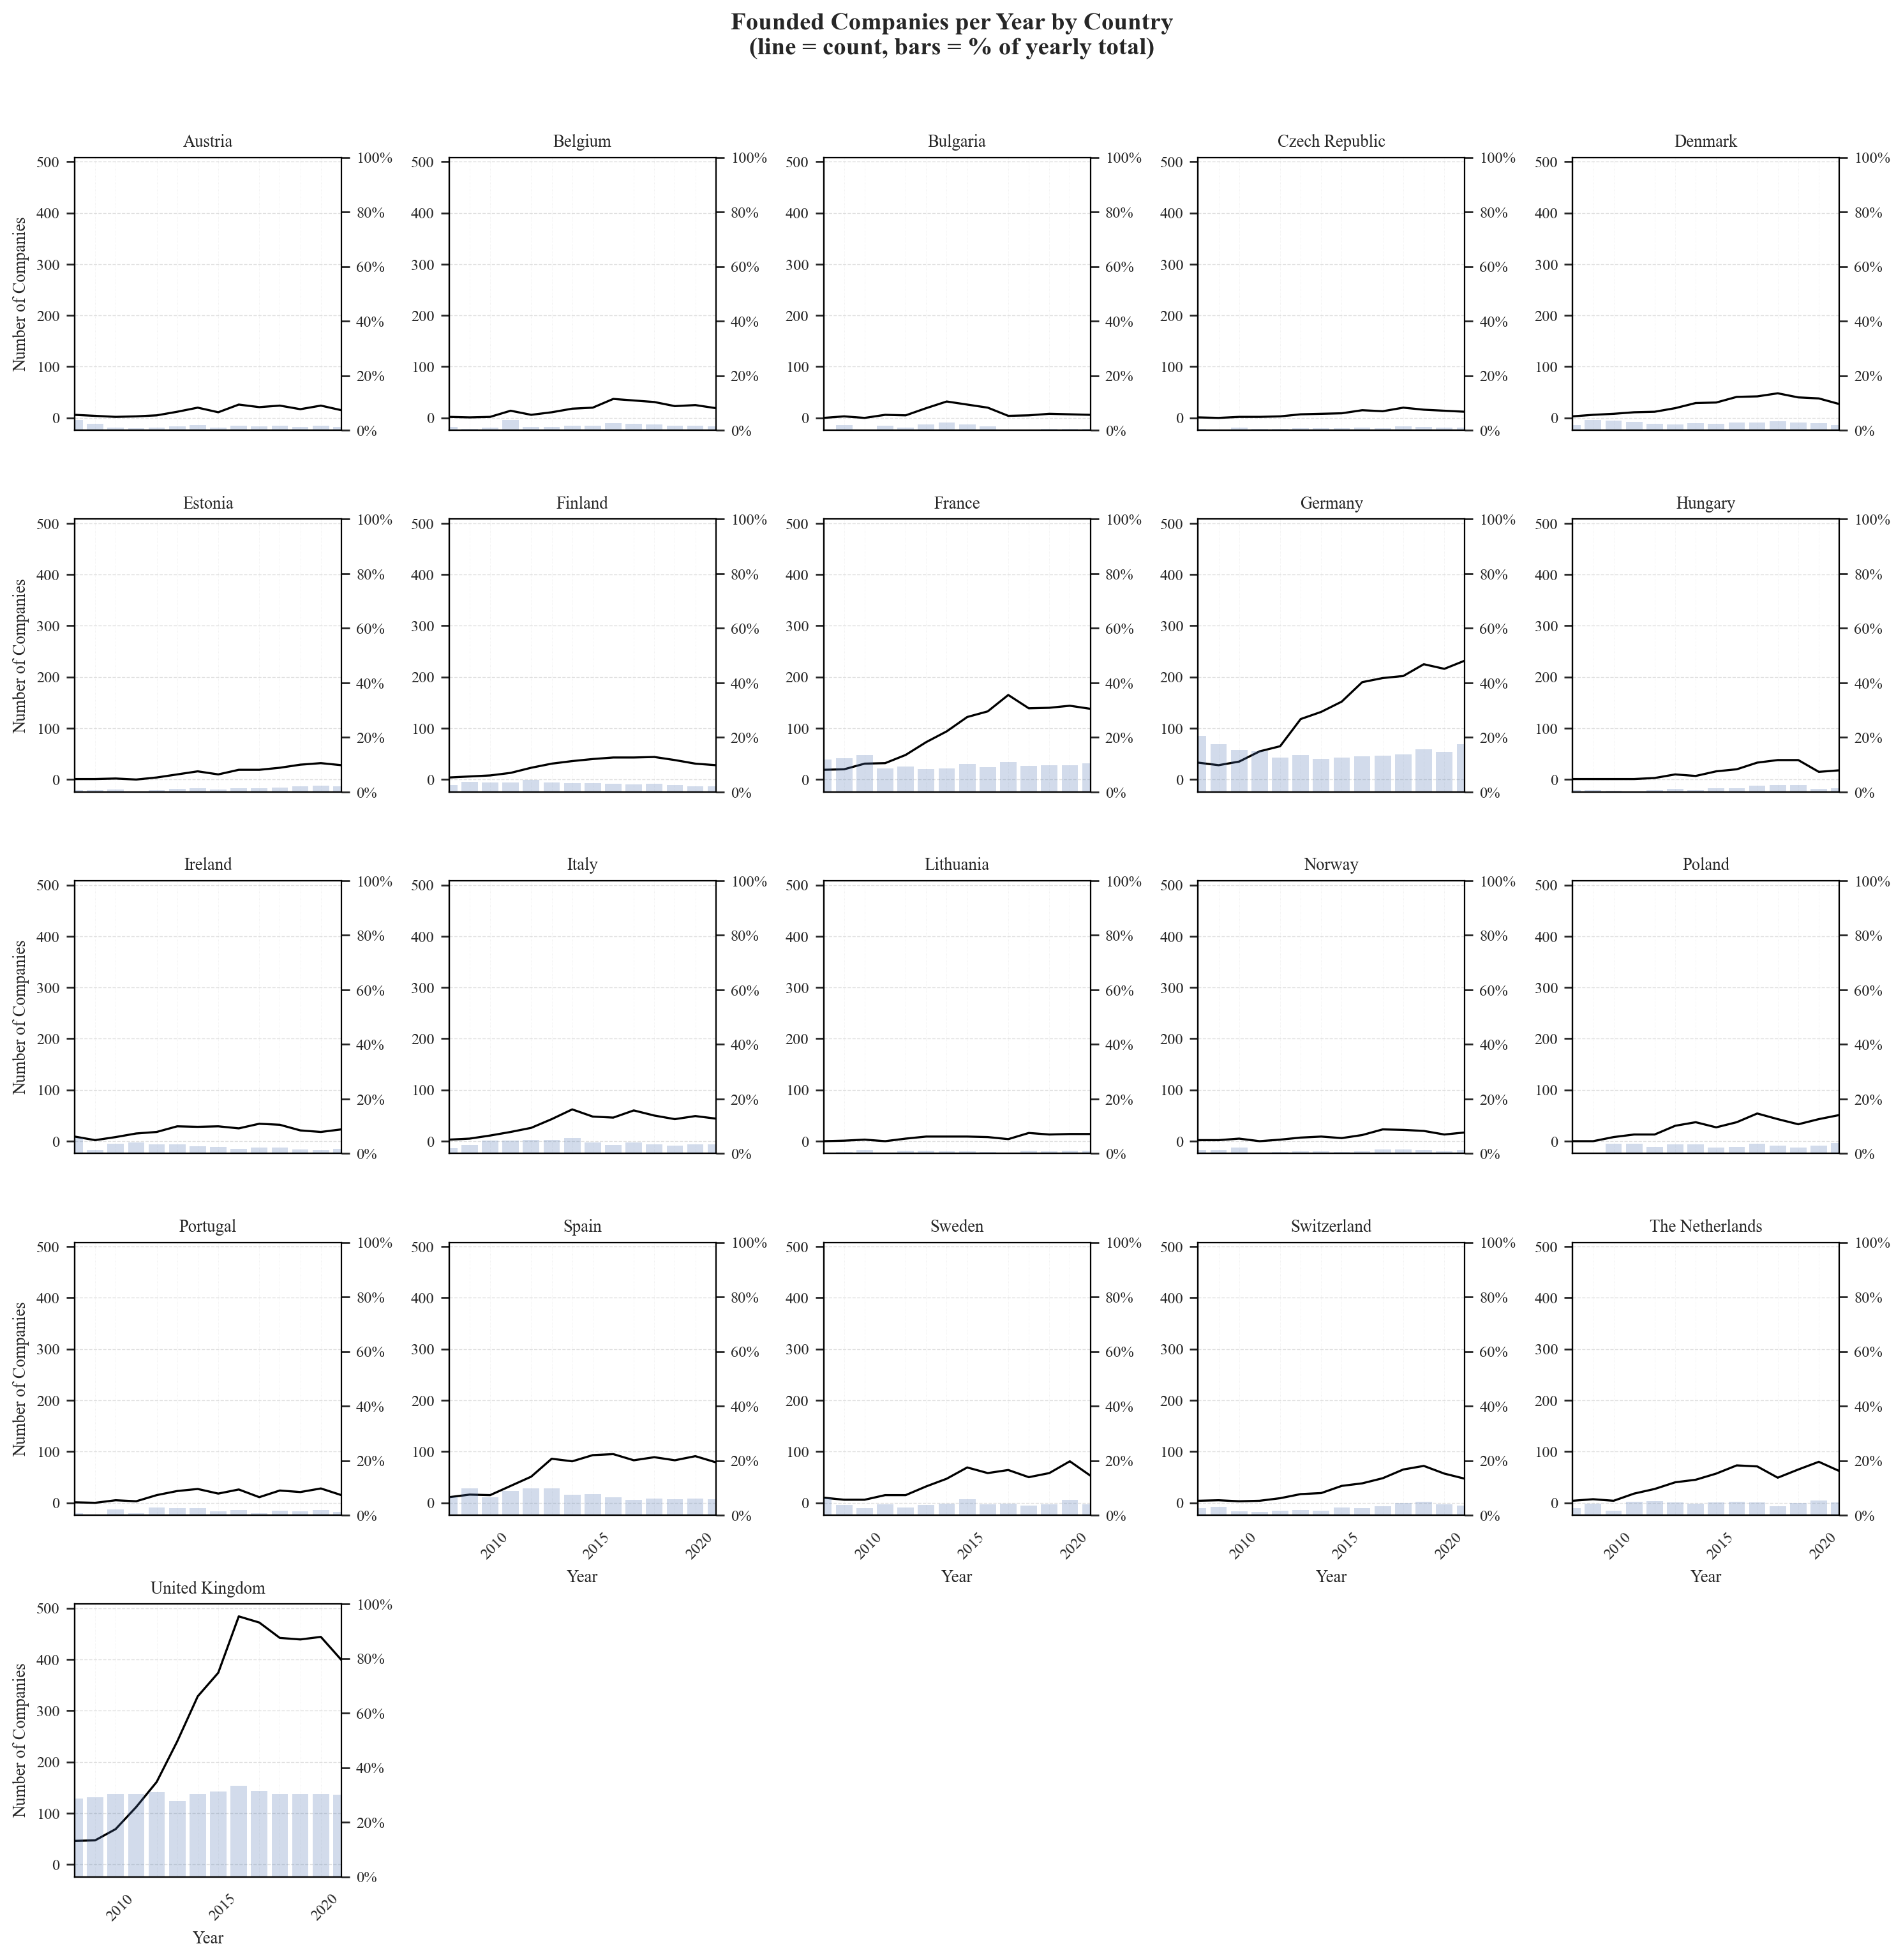

In [ ]:
year_min = int(df["founded_year"].min())
year_max = int(df["founded_year"].max())
all_years = pd.Index(range(year_min, year_max + 1), name="founded_year")


grouped = (
    df.groupby(["founded_year", "hq_country"])
      .size()
      .unstack(fill_value=0)
      .reindex(all_years, fill_value=0)
)

year_totals = grouped.sum(axis=1) 

all_df = grouped.reset_index().melt(
    id_vars="founded_year", var_name="Country", value_name="Count"
)

g = sns.FacetGrid(
    all_df,
    col="Country",
    col_wrap=5,
    height=3,
    sharey=True,   
    sharex=True
)

by_country = {c: all_df[all_df["Country"] == c] for c in g.col_names}

for ax, country in zip(g.axes.flatten(), g.col_names):
    if ax is None:
        continue
    share = (grouped[country] / year_totals).fillna(0.0)  # 0..1
    ax_pct = ax.twinx()
    ax_pct.bar(
        all_years, share.values,
        width=0.8,
        alpha=0.25,
        edgecolor="none",
        zorder=0
    )
    ax_pct.set_ylim(0, 1.0) 
    ax_pct.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax_pct.grid(False) 

    sns.lineplot(
        data=by_country[country],
        x="founded_year", y="Count",
        ax=ax,
        color="black",
        zorder=2
    )

g.set_axis_labels("Year", "Number of Companies")
g.set_titles("{col_name}")
g.set(xlim=(year_min, year_max))

major_step = 5 if (year_max - year_min) >= 10 else 2
for ax in g.axes.flatten():
    if ax is None:
        continue
    ax.xaxis.set_major_locator(MultipleLocator(major_step))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.grid(True, axis="y", linestyle="--", linewidth=0.5, alpha=0.6)
    ax.grid(True, axis="x", which="minor", linestyle=":", linewidth=0.3, alpha=0.4)
    for label in ax.get_xticklabels(which="major"):
        label.set_rotation(45)
        label.set_ha("right")

plt.suptitle(
    "Founded Companies per Year by Country\n(line = count, bars = % of yearly total)",
    y=1.02, fontsize=14, weight="bold"
)

plt.tight_layout()

plt.savefig('data/visualization/countries/founded_companies_per_year_by_country.pdf', bbox_inches='tight')
plt.show()

## Investment rounds

In [106]:
total_seed_rounds = df["number_seed_rounds"].sum()
print(total_seed_rounds)

22704


## Investors

All seed_help pairs considered in the final regression set `df`

In [107]:
filtered_seed_help = seed_help[seed_help['company_id'].isin(df['company_id'])]

Distinct investor count

In [153]:
filtered_seed_help

,round_id,organization_name_url,investor_names,funding_type,company_id,investor_id,follow_on_investor
14,000006,https://www.crunchbase.com/organization/livekid,Inovo.vc,Seed,001304,013696,False
19,000010,https://www.crunchbase.com/organization/plenti...,4growth VC,Seed,001301,014637,False
20,000010,https://www.crunchbase.com/organization/plenti...,AIP Seed,Seed,001301,012110,True
21,000010,https://www.crunchbase.com/organization/plenti...,Kuba Filipowski,Seed,001301,022427,False
22,000010,https://www.crunchbase.com/organization/plenti...,Montis Capital Group,Seed,001301,014648,False
...,...,...,...,...,...,...,...
74882,055915,https://www.crunchbase.com/organization/c2call,High-Tech Gruenderfonds,Seed,019041,002328,False
74883,055916,https://www.crunchbase.com/organization/comput...,High-Tech Gruenderfonds,Seed,018447,002328,False
74886,055919,https://www.crunchbase.com/organization/humedics,High-Tech Gruenderfonds,Seed,018846,002328,False
74887,055920,https://www.crunchbase.com/organization/implan...,High-Tech Gruenderfonds,Seed,018662,002328,False


In [109]:
filtered_seed_help = seed_help[seed_help['company_id'].isin(df['company_id'])]
unique_investors = filtered_seed_help.drop_duplicates(subset=['investor_id'])
unique_investors = unique_investors.merge(
    investors[['investor_id', 'latitude', 'longitude']],
    on='investor_id',
    how='left'
)
unique_investor_count = unique_investors['investor_id'].nunique()
unique_hq_country_count = investors.loc[investors['investor_id'].isin(unique_investors['investor_id']), 'hq_country'].nunique()

print(f"Unique investor count: {unique_investor_count}")
print(f"Number of unique hq_country: {unique_hq_country_count}")

Unique investor count: 12735
Number of unique hq_country: 106


Angel / Institutional Porporation

In [110]:
unique_investors = unique_investors.merge(
    investors[['investor_id', 'angel']],
    on='investor_id',
    how='left'
)

In [111]:
angel_count = unique_investors['angel'].sum()
angel_percentage = (angel_count / len(unique_investors)) * 100
print(f"Angel count: {angel_count}")
print(f"Angel percentage: {angel_percentage:.2f}%")

Angel count: 5567
Angel percentage: 43.71%


Stacked investor chart

create 7 bar charts in one graphic. with a 2x3 +1 matrix. on the x put the year on the y the number of companies. for every chart focus on different investors and present how many companies received funding from this type of investors

Investor types %-participation per year

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/n8/ynbdx9r10lv6l8yh1m_hmbsh0000gn/T/ipykernel_98815/1273429415.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=10)
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted a

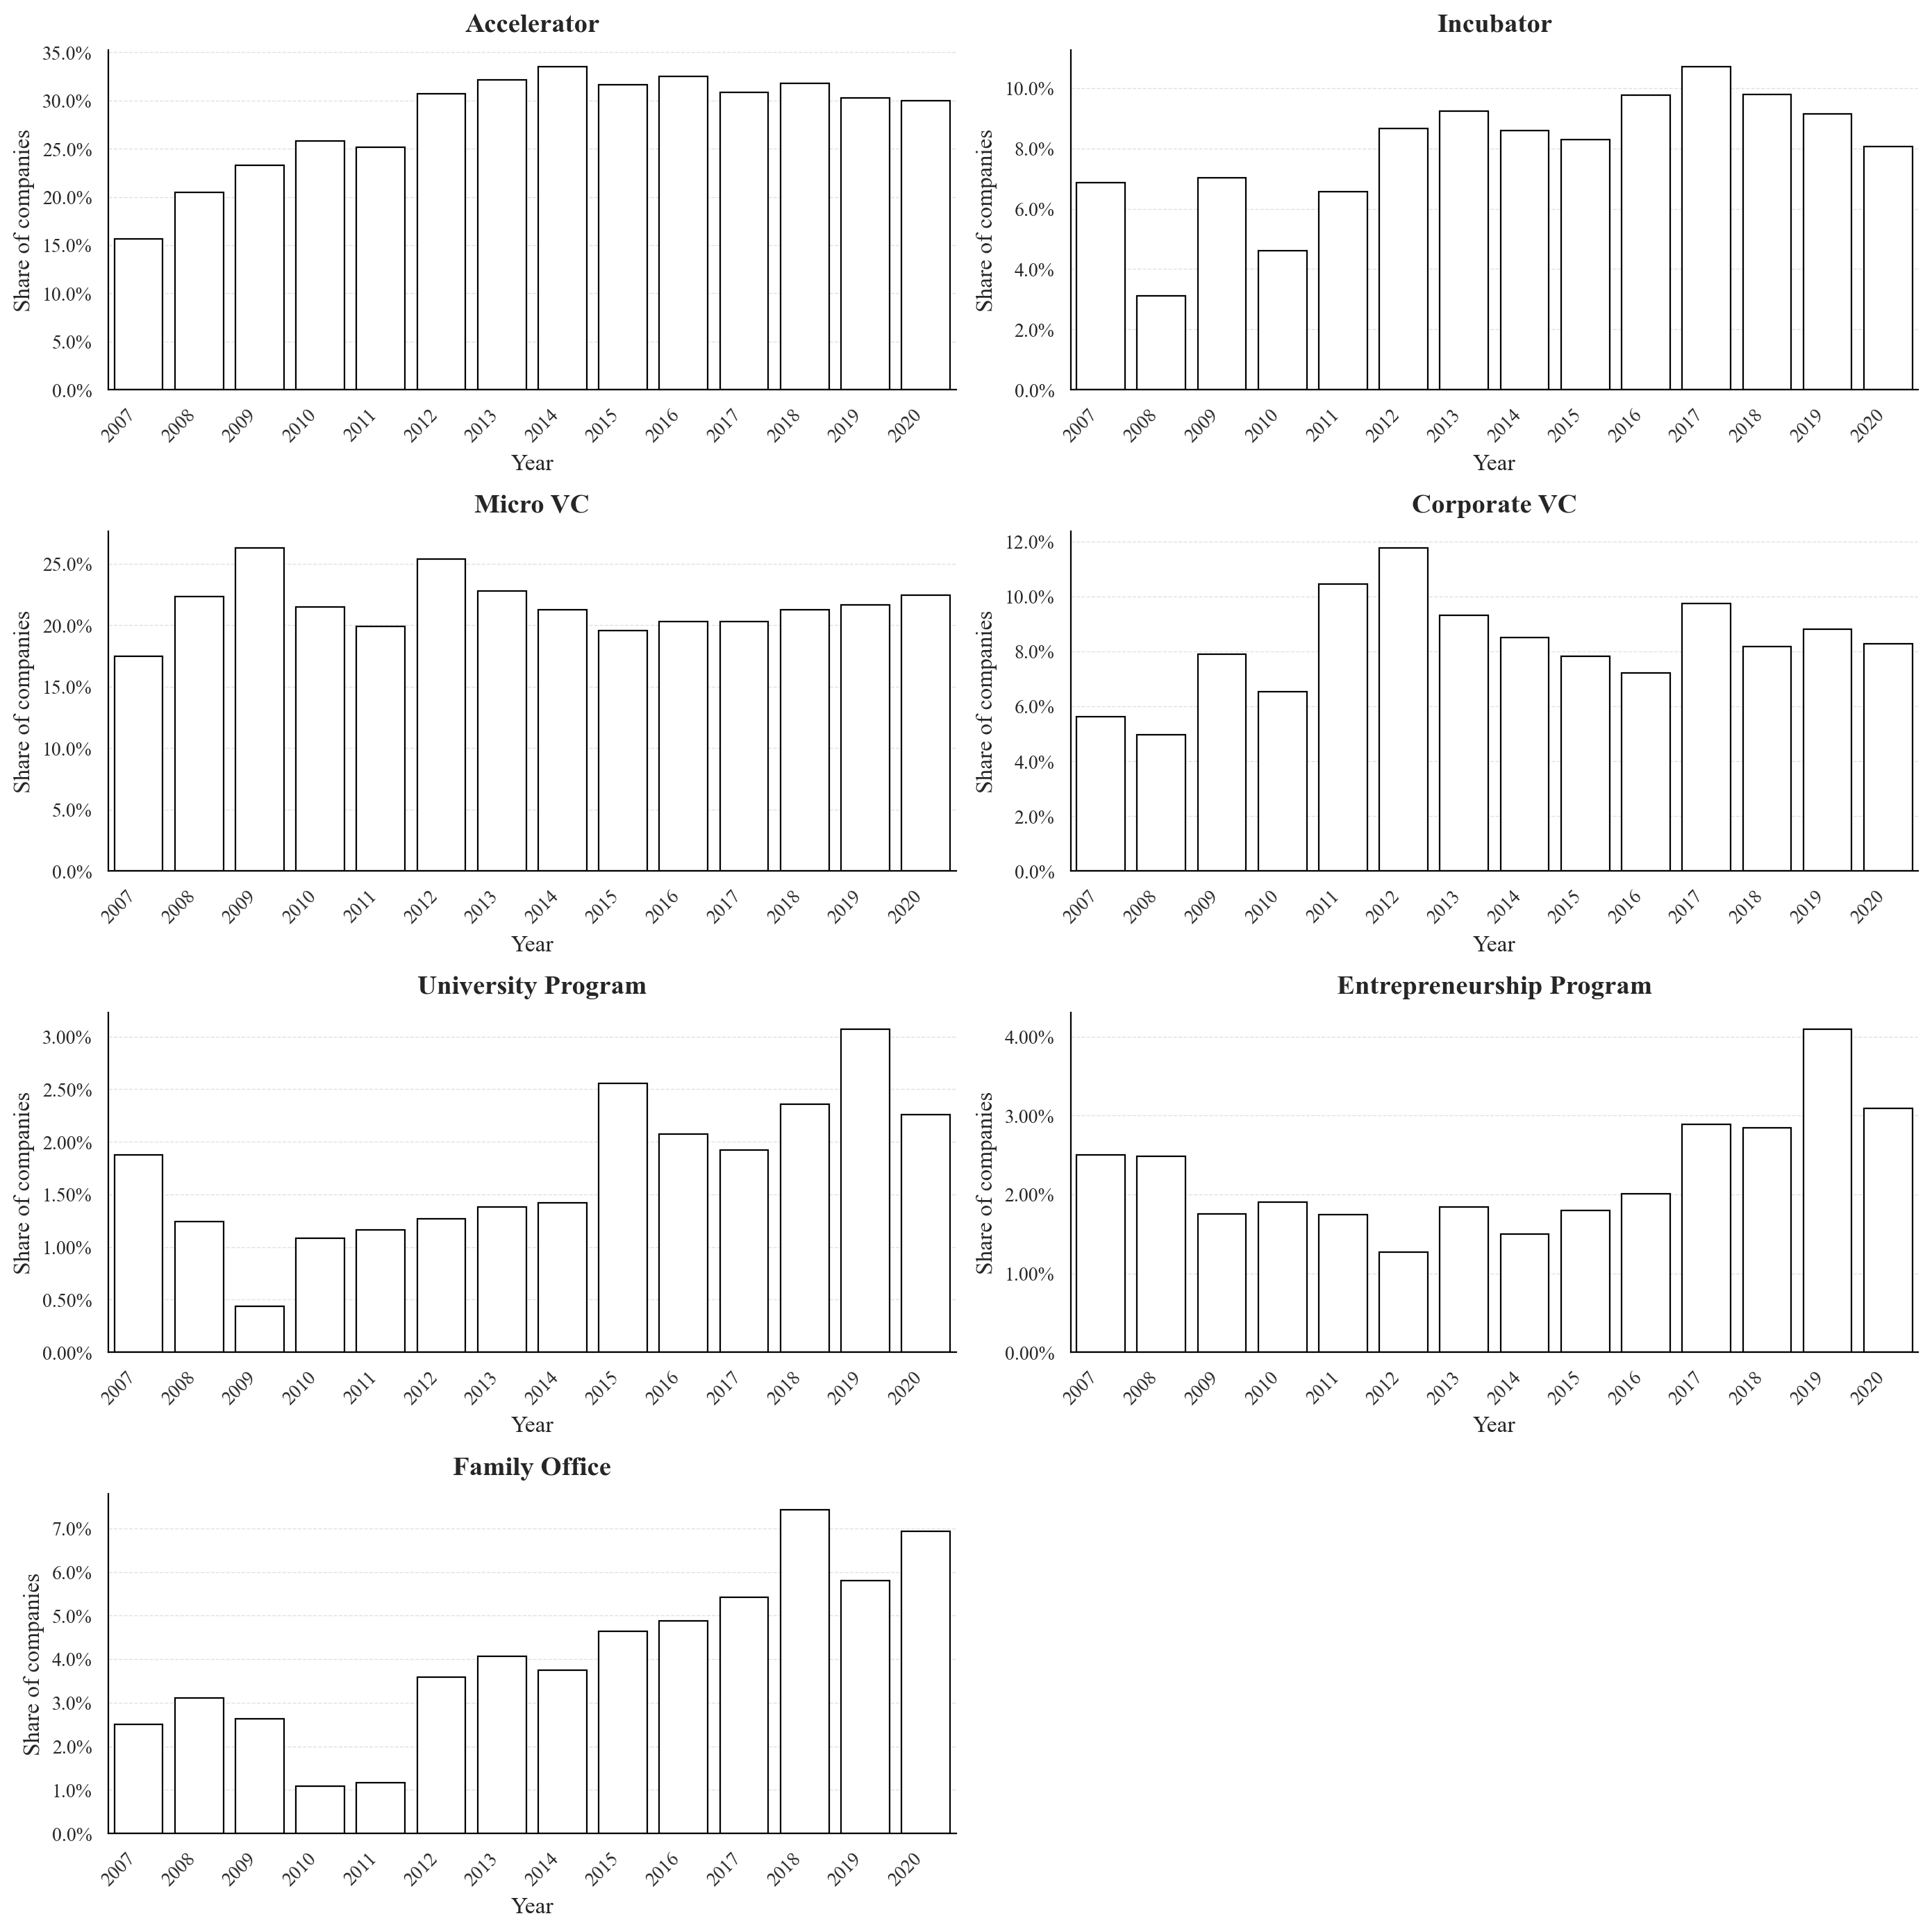

In [ ]:
sns.set_theme(style="white", context="paper")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})

investor_types = [
    ("accelerator_seed_investor_binary", "Accelerator"),
    ("incubator_seed_investor_binary", "Incubator"),
    ("micro_vc_seed_investor_binary", "Micro VC"),
    ("corporate_venture_capital_seed_investor_binary", "Corporate VC"),
    ("university_program_seed_investor_binary", "University Program"),
    ("entrepreneurship_program_seed_investor_binary", "Entrepreneurship Program"),
    ("family_investment_office_seed_investor_binary", "Family Office"),
]

years = sorted(df["founded_year"].unique())

year_totals = df.groupby("founded_year").size().reindex(years, fill_value=0)

ncols = 2
nrows = -(-len(investor_types) // ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3.5 * nrows))
axes = axes.flatten()

for i, (col, title) in enumerate(investor_types):

    counts = (
        df[df[col] == 1]
        .groupby("founded_year")
        .size()
        .reindex(years, fill_value=0)
    )

    with np.errstate(divide='ignore', invalid='ignore'):
        pct = counts.values / year_totals.values.astype(float)
        pct = np.nan_to_num(pct, nan=0.0, posinf=0.0, neginf=0.0)

    sns.barplot(
        x=years,
        y=pct,               
        color="white",
        edgecolor="black",
        linewidth=0.8,
        ax=axes[i]
    )

    axes[i].set_title(title, fontsize=14, weight="bold", pad=10)
    axes[i].set_xlabel("Year", fontsize=12)
    axes[i].set_ylabel("Share of companies", fontsize=12)


    axes[i].yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    axes[i].tick_params(axis='y', labelsize=10)

    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=10)

    axes[i].yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    axes[i].xaxis.grid(False)
    sns.despine(ax=axes[i])

for j in range(len(investor_types), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig("data/visualization/investors/investor_types.pdf")
plt.show()

## Companies

New ventures founded per year

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/n8/ynbdx9r10lv6l8yh1m_hmbsh0000gn/T/ipykernel_98815/340725080.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
JSTF dropped
DSIG dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 21 glyphs before
Glyph names: ['V', 'Y', 'a', 'b', 'd', 'e', 'f', 'glyph1197', 'm', 'n', 'nonmarkingretur

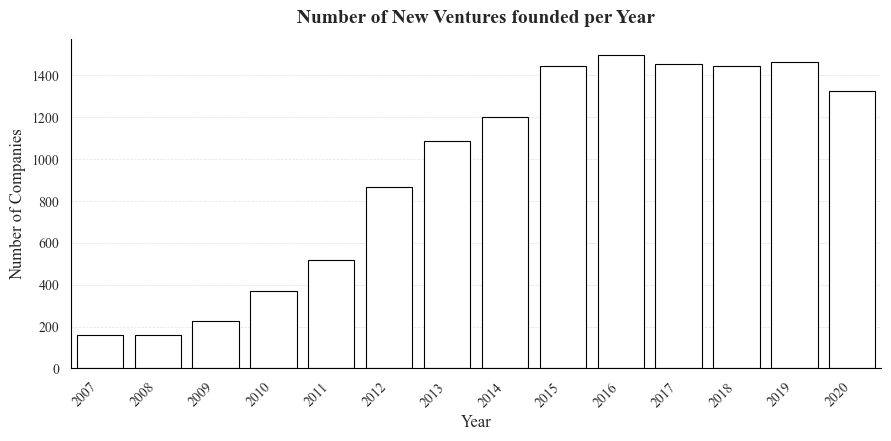

In [112]:
sns.set_theme(style="white", context="paper")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})

year_counts = df['founded_year'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(9, 4.5))  # 2:1 ratio

sns.barplot(
    x=year_counts.index,
    y=year_counts.values,
    color="white",
    edgecolor="black",
    linewidth=0.8,
    ax=ax
)

ax.set_title("Number of New Ventures founded per Year", fontsize=14, weight='bold', pad=12)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Number of Companies", fontsize=12)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.tick_params(axis='y', labelsize=10)

ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.xaxis.grid(False)

sns.despine(ax=ax)

plt.tight_layout()
plt.savefig("data/visualization/companies/yearly/year_counts.pdf") 

B2B and B2C ventures per sector

maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
JSTF dropped
DSIG dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 46 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'M', 'O', 'P', 'R', 'S', 'T', 'U', 'a', 'c', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'percent', 'r', 's', 'six', 'space', 't', 'two', 'u', 'v', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 8, 11, 12, 19, 20, 21, 23, 25, 27, 37, 38, 39, 40, 41, 43, 44, 48, 50, 51, 53, 54, 55, 56, 68, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
Closed glyph list over 'GSUB': 46 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'M', 'O', 'P', 'R', 'S', 'T', 'U', 'a', 'c', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one',

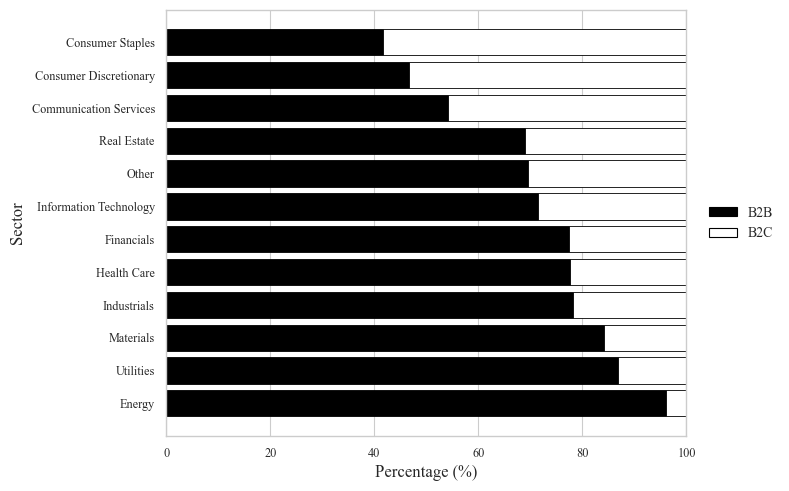

In [113]:
industry_b2b_counts = {}
industry_b2c_counts = {}

for industry in industry_columns:
    b2b_counts = df[(df['b2b'] == 1) & (df[industry])].groupby('founded_year').size()
    b2c_counts = df[(df['b2b'] == 0) & (df[industry])].groupby('founded_year').size()
    
    industry_b2b_counts[industry] = b2b_counts
    industry_b2c_counts[industry] = b2c_counts

industry_b2b_df = pd.DataFrame(industry_b2b_counts).fillna(0).astype(int)
industry_b2c_df = pd.DataFrame(industry_b2c_counts).fillna(0).astype(int)

industry_b2b_percentage = industry_b2b_df.div(industry_b2b_df + industry_b2c_df) * 100
industry_b2c_percentage = industry_b2c_df.div(industry_b2b_df + industry_b2c_df) * 100

industry_b2b_percentage = industry_b2b_percentage.round(2)
industry_b2c_percentage = industry_b2c_percentage.round(2)

sector_percentage_df = pd.DataFrame({
    "sector": industry_columns,
    "b2b_percentage": [industry_b2b_percentage[col].mean() for col in industry_columns],
    "b2c_percentage": [industry_b2c_percentage[col].mean() for col in industry_columns]
}).round(2)

sector_display_names = [
    "Energy", "Information Technology", "Materials", "Industrials",
    "Consumer Discretionary", "Consumer Staples", "Health Care",
    "Financials", "Communication Services", "Utilities",
    "Real Estate", "Other"
]
sector_percentage_df["sector"] = sector_display_names

sector_percentage_df = sector_percentage_df.sort_values("b2b_percentage", ascending=False)

sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})

fig, ax = plt.subplots(figsize=(8, 5))

ax.barh(
    sector_percentage_df['sector'],
    sector_percentage_df['b2b_percentage'],
    color="black",
    edgecolor="black",
    linewidth=0.6,
    label="B2B"
)

ax.barh(
    sector_percentage_df['sector'],
    sector_percentage_df['b2c_percentage'],
    left=sector_percentage_df['b2b_percentage'],
    color="white",
    edgecolor="black",
    linewidth=0.6,
    label="B2C"
)

ax.set_xlabel("Percentage (%)", fontsize=12)
ax.set_ylabel("Sector", fontsize=12)
ax.set_xlim(0, 100)

handles = [
    mpatches.Patch(facecolor="black", edgecolor="black", label="B2B"),
    mpatches.Patch(facecolor="white", edgecolor="black", label="B2C")
]

ax.legend(
    handles=handles,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=10
)

plt.tight_layout()
plt.savefig("data/visualization/companies/b2b/b2b_b2c_stacked.pdf", bbox_inches="tight")

Map Visualization of company locations and concentrations

In [114]:
def hotspot_hexbin_map_research(
    df: pd.DataFrame,
    lon_col: str = "longitude",
    lat_col: str = "latitude",
    gridsize: int = 150,
    cmap: str = "magma",
    europe_bbox_wgs84: tuple = (-31.5, 27.0, 45.5, 72.5),
    pad_ratio: float = 0.04,
    title: str = "",
    subtitle: str = "",
    caption: str = "",
    out_png: str = "data/visualization/locations/europe_hotspots_hexbin.png",
    out_svg: str = "data/visualization/locations/europe_hotspots_hexbin.svg",
):
    if df.empty:
        raise ValueError("Empty DataFrame.")
    if not {lon_col, lat_col}.issubset(df.columns):
        raise ValueError(f"DataFrame must contain '{lon_col}' and '{lat_col}' columns.")

    gdf = gpd.GeoDataFrame(
        df[[lon_col, lat_col]].copy(),
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs="EPSG:4326"
    )
    west, south, east, north = europe_bbox_wgs84
    gdf = gdf[gdf.geometry.within(box(west, south, east, north))]
    if gdf.empty:
        raise ValueError("No points fall inside the Europe bounding box after filtering.")

    gdf = gdf.to_crs(3857)

    xmin, ymin, xmax, ymax = gdf.total_bounds
    dx, dy = xmax - xmin, ymax - ymin
    xmin -= dx * pad_ratio; xmax += dx * pad_ratio
    ymin -= dy * pad_ratio; ymax += dy * pad_ratio


    borders = None
    try:
        from geodatasets import get_path
        world = gpd.read_file(get_path("naturalearth.cultural.admin_0_countries")).to_crs(3857)
        bbox_3857 = gpd.GeoDataFrame(geometry=[box(xmin, ymin, xmax, ymax)], crs=3857)
        borders = gpd.overlay(world, bbox_3857, how="intersection")
        borders = borders[~borders["name"].isin(["Antarctica"])]
    except Exception:
        borders = None

    plt.rcParams.update({
        "figure.dpi": 200,
        "savefig.dpi": 300,
        "font.size": 10,
        "axes.titlesize": 14,
        "axes.labelsize": 11,
        "figure.facecolor": "white",
        "axes.facecolor": "white",
    })

    fig, ax = plt.subplots(figsize=(11, 10))
    ax.set_axis_off()
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)

    if borders is not None and not borders.empty:
        borders.boundary.plot(ax=ax, linewidth=0.4, color="#BBBBBB", alpha=0.6, zorder=1)
    else:
        import contextily as cx
        cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=3857, zorder=0, alpha=1.0)

    x = gdf.geometry.x.to_numpy()
    y = gdf.geometry.y.to_numpy()
    hb = ax.hexbin(x, y, gridsize=gridsize, cmap=cmap, bins="log", mincnt=1, zorder=2)

    if borders is not None and not borders.empty:
        borders.boundary.plot(ax=ax, linewidth=0.35, color="#DDDDDD", alpha=0.8, zorder=3)

    ax.set_title(title, pad=8, loc="left", fontweight="bold")
    fig.text(0.125, 0.92, subtitle, ha="left", va="center", color="#555555")
    fig.text(0.125, 0.04, caption, ha="left", va="center", color="#777777")

    cbar = plt.colorbar(hb, ax=ax, fraction=0.026, pad=0.02)
    cbar.set_label("Companies per hex")

    cbar.locator = LogLocator(base=10, numticks=12)

    def _human_counts(v, pos):
        if not np.isfinite(v) or v <= 0:
            return ""
        if v < 10:
            return f"{int(round(v))}"
        if v < 1_000:
            return f"{int(round(v))}"
        if v < 1_000_000:
            return f"{int(round(v/1_000))}k"
        return f"{int(round(v/1_000_000))}M"

    cbar.formatter = FuncFormatter(_human_counts)
    cbar.update_ticks()

    plt.tight_layout(pad=0.5)
    fig.savefig(out_png, bbox_inches="tight", pad_inches=0.1, facecolor="white")
    fig.savefig(out_svg, bbox_inches="tight", pad_inches=0.1, facecolor="white")
    plt.close(fig)
    return out_png, out_svg

png_path, svg_path = hotspot_hexbin_map_research(df)
print("Saved:", png_path, "and", svg_path)

Saved: data/visualization/locations/europe_hotspots_hexbin.png and data/visualization/locations/europe_hotspots_hexbin.svg


## Founding Teams

Number of founders

In [115]:
filtered_founders = founders[founders['company_id'].isin(df['company_id'])]

founder_count = filtered_founders.shape[0]
print("Number of founders in regression set:", founder_count)

Number of founders in regression set: 28578


Teams with female founders across sectors

In [116]:
female_teams_per_sector = {}

for sector in industry_columns:
    count = df[(df['female_founder'] == 1) & (df[sector] == 1)].shape[0]
    female_teams_per_sector[sector] = count

female_teams_per_sector_df = pd.DataFrame(list(female_teams_per_sector.items()), columns=['sector', 'female_founder_teams'])

female_teams_per_sector_df['percentage'] = (
    female_teams_per_sector_df['female_founder_teams'] / sector_counts_df.set_index('sector').loc[female_teams_per_sector_df['sector'], 'count'].values * 100
).round(2)

Stacked chart with female founder team members per sector

maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
JSTF dropped
DSIG dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 20 glyphs before
Glyph names: ['F', 'S', 'T', 'a', 'c', 'd', 'e', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'uni0000', 'uni000D']
Glyph IDs:   [0, 1, 2, 3, 41, 54, 55, 68, 70, 71, 72, 79, 80, 81, 82, 83, 85, 86, 87, 88]
Closed glyph list over 'GSUB': 20 glyphs after
Glyph names: ['F', 'S', 'T', 'a', 'c', 'd', 'e', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'uni0000', 'uni000D']
Glyph IDs:   [0, 1, 2, 3, 41, 54, 55, 68, 70, 71, 72, 79, 80, 81, 82, 83, 85, 86, 87, 88]
Closing glyph list over 'glyf': 20 glyphs before
Glyph names: ['F', 'S', 'T', 'a', 'c', 'd', 'e', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'uni0000', 'uni000D']
Glyph IDs:   [0, 1, 2, 3, 41, 54, 55, 68, 70, 71

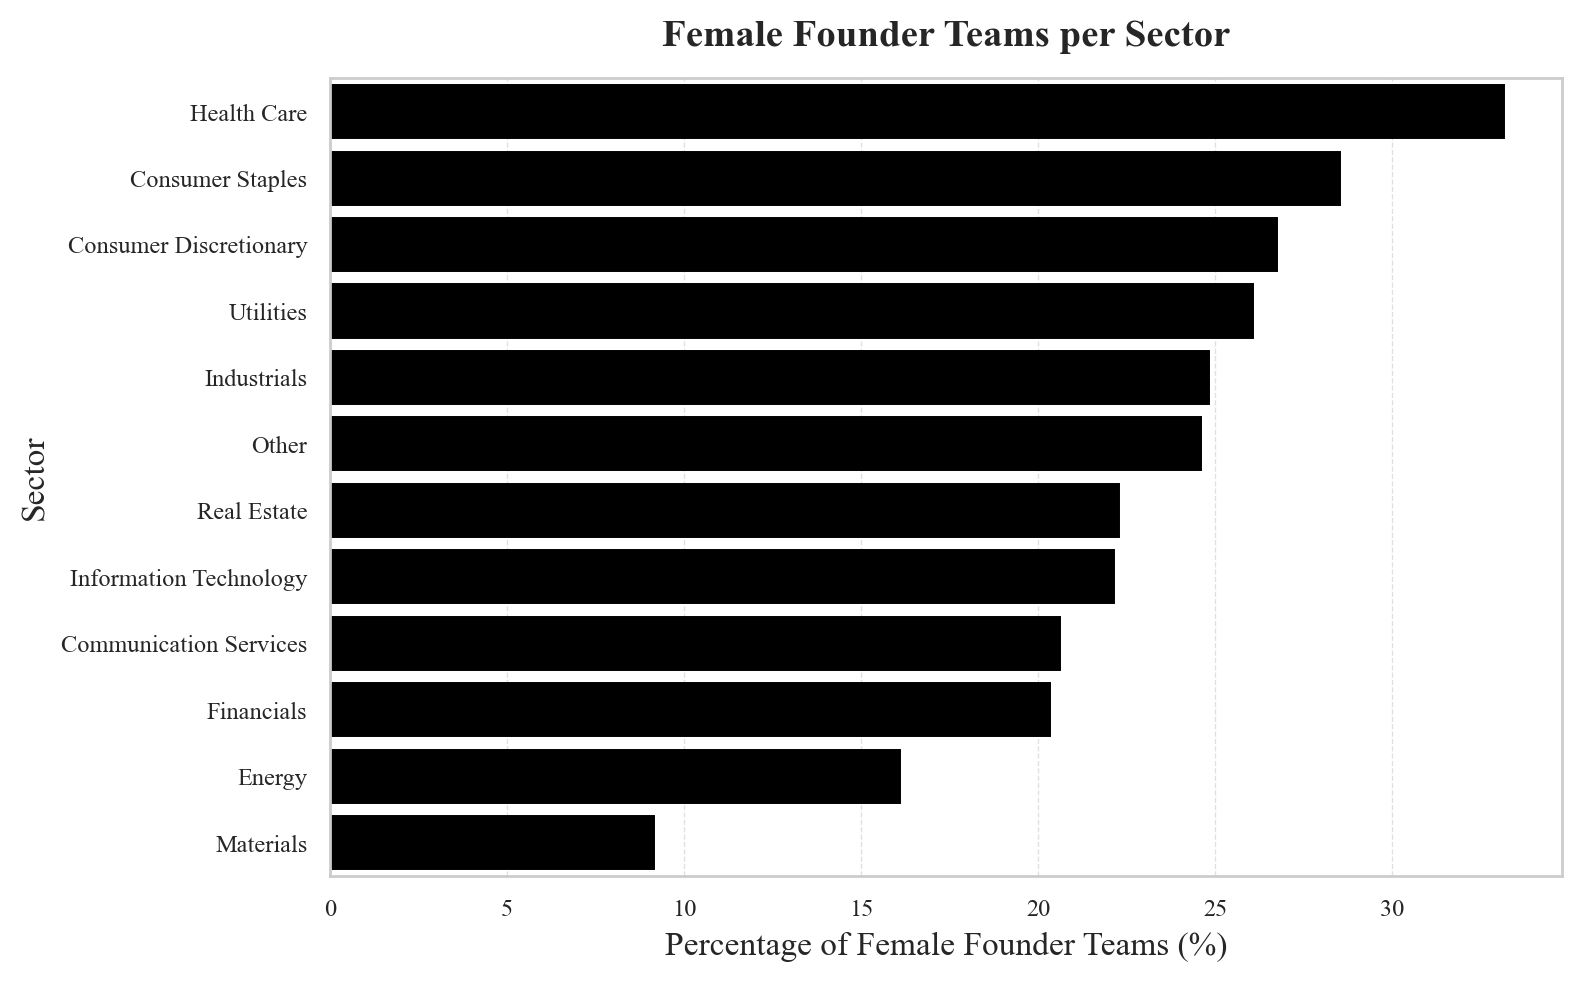

In [117]:
industry_columns = [
    'energy', 'information_technology', 'materials', 'industrials',
    'consumer_discretionary', 'consumer_staples', 'health_care', 'financials',
    'communication_services', 'utilities', 'real_estate', 'other'
]

sector_display_names = [
    "Energy", "Information Technology", "Materials", "Industrials",
    "Consumer Discretionary", "Consumer Staples", "Health Care",
    "Financials", "Communication Services", "Utilities",
    "Real Estate", "Other"
]

sector_counts = {
    sector: df[df[sector] == 1].shape[0] for sector in industry_columns
}
sector_counts_df = pd.DataFrame(list(sector_counts.items()), columns=['sector', 'count'])

female_teams_per_sector = {
    sector: df[(df['female_founder'] == 1) & (df[sector] == 1)].shape[0]
    for sector in industry_columns
}
female_teams_df = pd.DataFrame(
    list(female_teams_per_sector.items()),
    columns=['sector', 'female_founder_teams']
)

female_teams_df['percentage'] = (
    female_teams_df['female_founder_teams'] /
    sector_counts_df.set_index('sector').loc[female_teams_df['sector'], 'count'].values * 100
).round(2)

female_teams_df['sector'] = sector_display_names
df_plot = female_teams_df.sort_values("percentage", ascending=False)

sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})

fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(
    data=df_plot,
    y="sector",
    x="percentage",
    color="black",
    edgecolor="black",
    linewidth=0.7,
    ax=ax
)

ax.set_xlabel("Percentage of Female Founder Teams (%)", fontsize=12)
ax.set_ylabel("Sector", fontsize=12)
ax.set_title("Female Founder Teams per Sector", fontsize=14, weight='bold', pad=12)
ax.xaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.yaxis.grid(False)

plt.tight_layout()
plt.savefig("data/visualization//founders/female_founders/female_founder_teams_per_sector.pdf", bbox_inches="tight")

Percentage of teams with female founders 

In [118]:
mean_female_founder = df['female_founder'].mean()
print(f"Mean (percentage) of companies with a female founder: {mean_female_founder:.4f}")

Mean (percentage) of companies with a female founder: 0.2388


Female founders per sector

maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
JSTF dropped
DSIG dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 23 glyphs before
Glyph names: ['F', 'S', 'T', 'a', 'c', 'd', 'e', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'uni0000', 'uni000D', 'w']
Glyph IDs:   [0, 1, 2, 3, 41, 54, 55, 68, 70, 71, 72, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 90]
Closed glyph list over 'GSUB': 23 glyphs after
Glyph names: ['F', 'S', 'T', 'a', 'c', 'd', 'e', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'uni0000', 'uni000D', 'w']
Glyph IDs:   [0, 1, 2, 3, 41, 54, 55, 68, 70, 71, 72, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 90]
Closing glyph list over 'glyf': 23 glyphs before
Glyph names: ['F', 'S', 'T', 'a', 'c', 'd', 'e', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'uni00

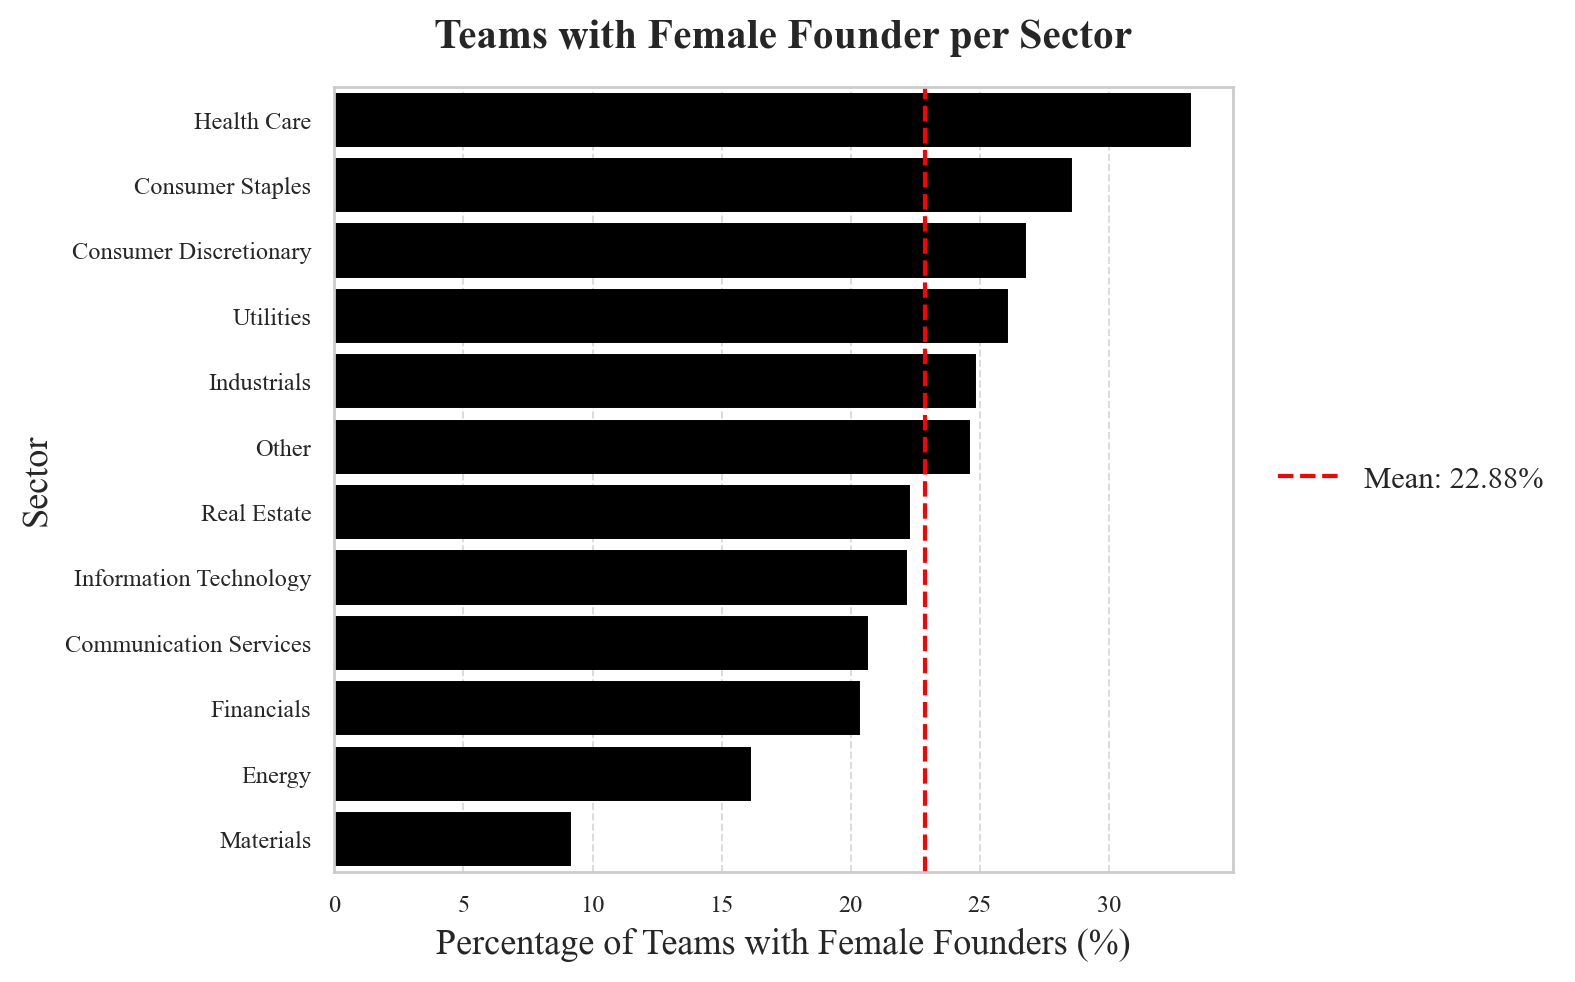

In [119]:
female_teams_per_sector_df['sector'] = sector_display_names

df_plot = female_teams_per_sector_df.sort_values("percentage", ascending=False)

mean_percentage = female_teams_per_sector_df["percentage"].mean()

sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})

fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(
    data=df_plot,
    y="sector",
    x="percentage",
    color="black",
    edgecolor="black",
    linewidth=0.7,
    ax=ax
)

ax.axvline(
    mean_percentage,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label=f"Mean: {mean_percentage:.2f}%"
)

ax.set_xlabel("Percentage of Teams with Female Founders (%)", fontsize=13)
ax.set_ylabel("Sector", fontsize=13)
ax.set_title("Teams with Female Founder per Sector", fontsize=15, weight='bold', pad=14)

ax.xaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.yaxis.grid(False)

ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    fontsize=11,
    frameon=False
)

plt.tight_layout()
plt.savefig("data/visualization/founders/female_founders/female_founder_per_sector.pdf", bbox_inches="tight")

Female founders in b2b/b2c

In [120]:
total_b2b = df[df['b2b'] == 1].shape[0]
total_b2c = df[df['b2b'] == 0].shape[0]

female_b2c = df[(df['female_founder'] == 1) & (df['b2b'] == 0)].shape[0]
female_b2b = df[(df['female_founder'] == 1) & (df['b2b'] == 1)].shape[0]

perc_female_b2b = (female_b2b / total_b2b) * 100 if total_b2b > 0 else 0
perc_female_b2c = (female_b2c / total_b2c) * 100 if total_b2c > 0 else 0

print(f"Teams with female founders as % of all B2B companies: {perc_female_b2b:.2f}%")
print(f"Teams with female founders as % of all B2C companies: {perc_female_b2c:.2f}%")

Teams with female founders as % of all B2B companies: 21.92%
Teams with female founders as % of all B2C companies: 28.04%


Teams with female founders across countries

In [121]:
female_founder_country = df.groupby('hq_country')['female_founder'].mean().sort_values(ascending=False) * 100
female_founder_country = female_founder_country.round(2)
mean_female_founder_country = female_founder_country.mean().round(2)
print(female_founder_country)
print(f"Mean percentage of companies with a female founder across countries: {mean_female_founder_country}%")

hq_country
Italy              39.17
Estonia            34.54
Finland            29.38
Norway             27.66
Ireland            27.49
Bulgaria           26.95
Sweden             26.95
Spain              25.83
United Kingdom     25.36
France             23.11
Portugal           22.58
Hungary            21.78
Switzerland        20.90
Belgium            20.58
Germany            19.78
The Netherlands    18.94
Poland             17.99
Lithuania          17.14
Denmark            16.38
Austria            15.26
Czech Republic      9.02
Name: female_founder, dtype: float64
Mean percentage of companies with a female founder across countries: 23.18%


## Grants

New ventures with grants before seed

In [122]:
num_teams_with_grants = df[df['grant_before_seed'] == 1].shape[0]
print("Number of new ventures with grants:", num_teams_with_grants)

Number of new ventures with grants: 557


Number of grants given before seed

In [123]:
grants_in_df = grants[grants['organization_name_url'].isin(df['organization_name_url'])].reset_index(drop=True)
grants_with_grant_before_seed = grants_in_df[grants_in_df['grant_before_seed'] == True]
count_grants_before_seed = grants_with_grant_before_seed.shape[0]
print("Count of grants given before seed:", count_grants_before_seed)

Count of grants given before seed: 806


Top 3 supporting institutions

In [124]:
top_3_investors = grants_with_grant_before_seed['investor_names'].value_counts().head(3)
print(top_3_investors)

investor_names
Venture Kick    173
EASME           105
Innovate UK      54
Name: count, dtype: int64


Grants per country

In [125]:
if 'hq_country' not in grants_in_df.columns:
    grants_in_df = grants_in_df.merge(
        df[['organization_name_url', 'hq_country']],
        on='organization_name_url',
        how='left'
    )

grants_before_seed = grants_in_df[grants_in_df['grant_before_seed'] == True]

grants_per_country = grants_before_seed['hq_country'].value_counts().reset_index()
grants_per_country.columns = ['hq_country', 'grant_count']
grants_per_country
grants_per_country.to_csv('data/visualization/grants/grants_per_country.csv', index=False)

## Angel Rounds

Number of angel rounds and distinct companies

In [126]:
angel_in_df = angel[angel['organization_name_url'].isin(df['organization_name_url'])].reset_index(drop=True)
num_rounds = angel_in_df['transaction_name'].count()
num_companies = angel_in_df['organization_name_url'].nunique()

print(f"Number of angel rounds: {num_rounds}")
print(f"Number of distinct companies: {num_companies}")

Number of angel rounds: 1001
Number of distinct companies: 870


## Syndication

Syndication trends per country

In [127]:
country_no_syndication = df.groupby('hq_country')['no_syndication'].mean() * 100
country_no_syndication = country_no_syndication.round(2).sort_values(ascending=False)
country_no_syndication_df = country_no_syndication.reset_index().rename(columns={'no_syndication': 'no_syndication_percentage'})
print(country_no_syndication_df)

         hq_country  no_syndication_percentage
0          Bulgaria                      75.89
1           Hungary                      61.39
2            Poland                      52.19
3   The Netherlands                      46.84
4         Lithuania                      45.71
5            Sweden                      45.39
6           Belgium                      44.03
7             Italy                      41.93
8    Czech Republic                      41.80
9          Portugal                      41.47
10           Norway                      39.72
11          Estonia                      38.14
12          Finland                      36.86
13   United Kingdom                      35.35
14          Denmark                      35.31
15            Spain                      33.33
16          Austria                      31.58
17           France                      30.35
18          Germany                      28.81
19      Switzerland                      28.27
20          I

## Success

Success/no success stacked per year

maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
JSTF dropped
DSIG dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 16 glyphs before
Glyph names: ['S', 'Y', 'a', 'c', 'e', 'glyph1197', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'slash', 'space', 'u', 'uni0000', 'uni000D']
Glyph IDs:   [0, 1, 2, 3, 18, 49, 54, 60, 68, 70, 72, 82, 83, 85, 86, 88]
Closed glyph list over 'GSUB': 16 glyphs after
Glyph names: ['S', 'Y', 'a', 'c', 'e', 'glyph1197', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'slash', 'space', 'u', 'uni0000', 'uni000D']
Glyph IDs:   [0, 1, 2, 3, 18, 49, 54, 60, 68, 70, 72, 82, 83, 85, 86, 88]
Closing glyph list over 'glyf': 16 glyphs before
Glyph names: ['S', 'Y', 'a', 'c', 'e', 'glyph1197', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'slash', 'space', 'u', 'uni0000', 'uni000D']
Glyph IDs:   [0, 1, 2, 3, 18, 49, 54, 60, 68, 70, 72, 82, 83, 85, 86, 88]
Closed glyph list over 'glyf':

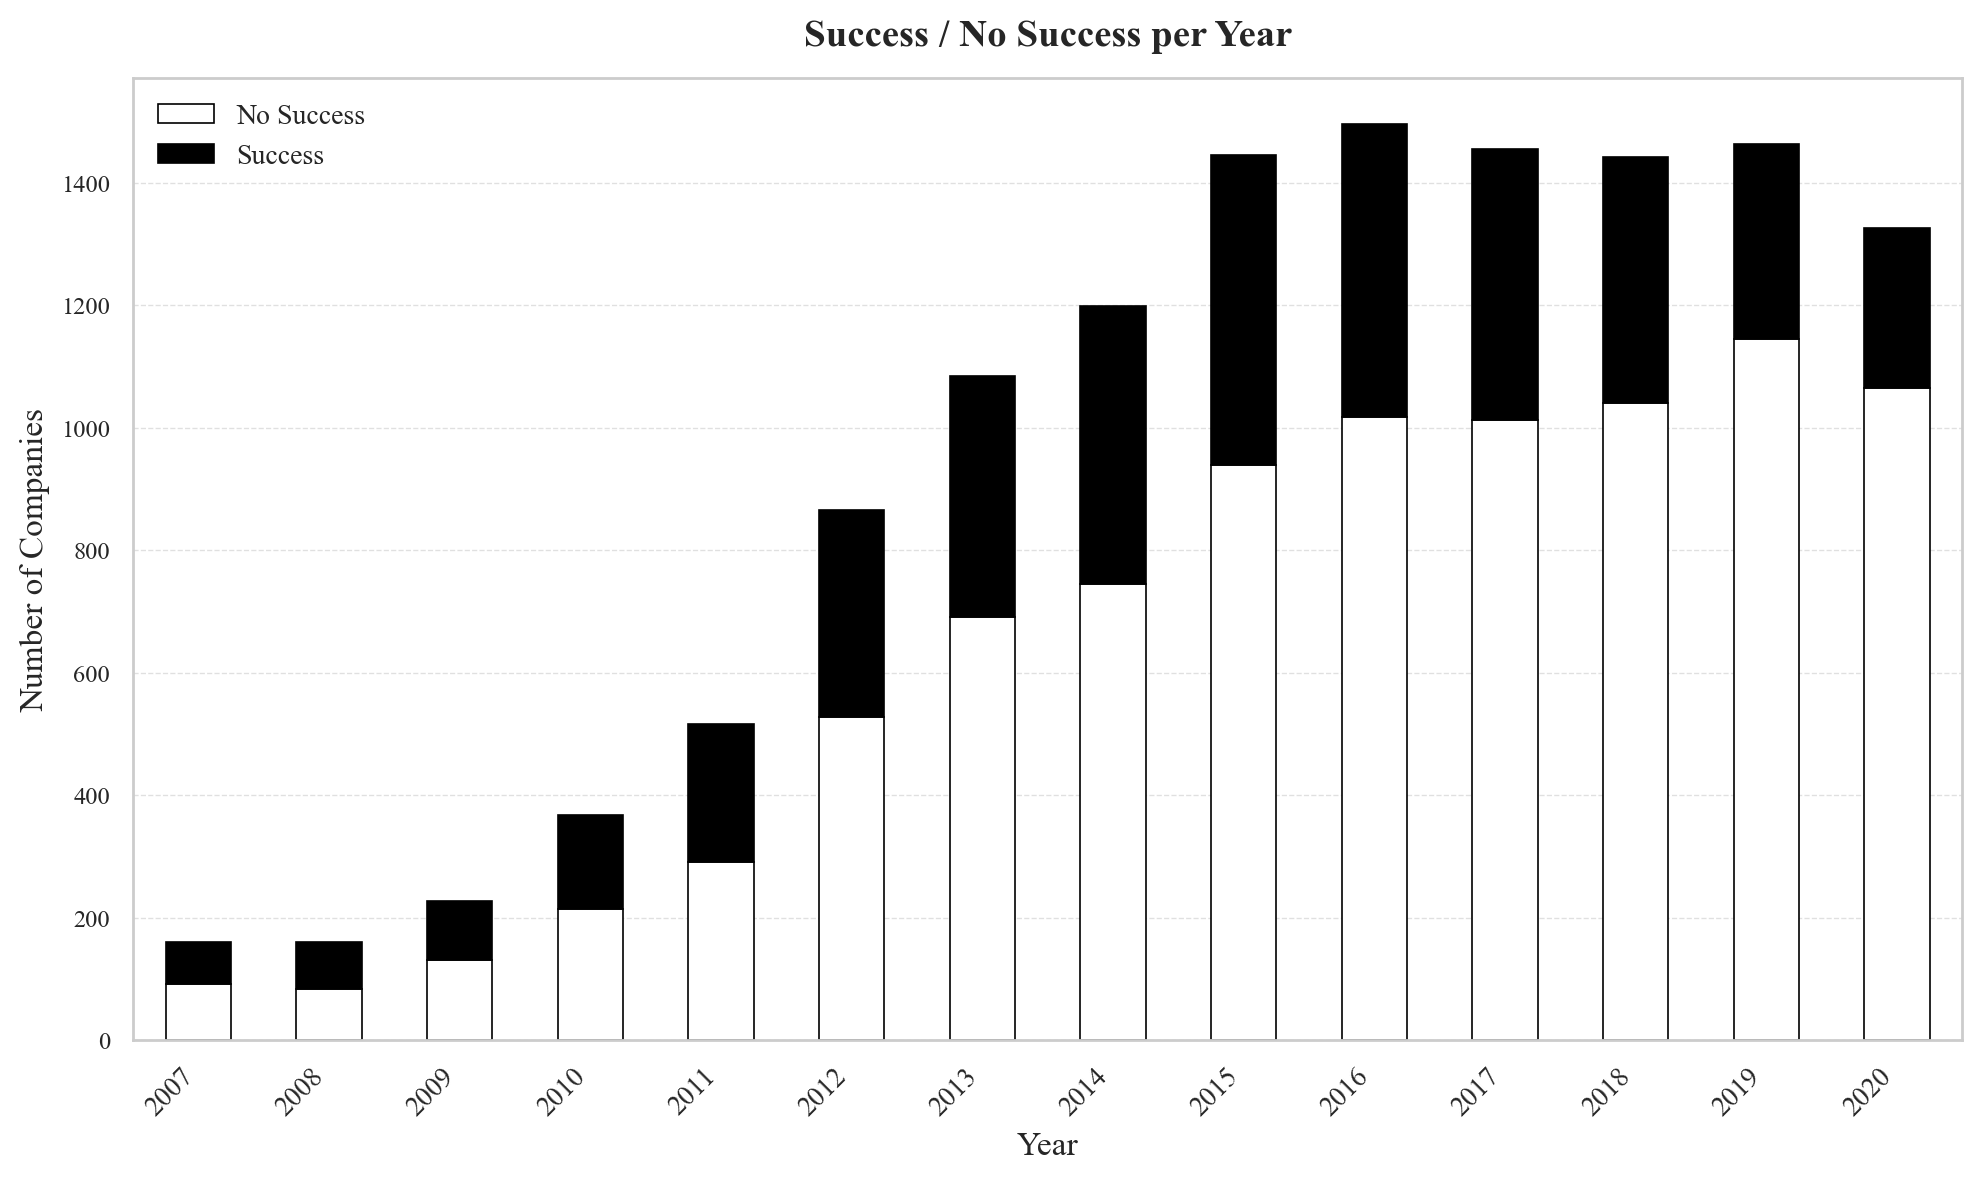

In [128]:
year_success = df.groupby(['founded_year', 'success_follow_2']).size().unstack(fill_value=0)

sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})

fig, ax = plt.subplots(figsize=(10, 6))

year_success.plot(
    kind='bar',
    stacked=True,
    color={False: "white", True: "black"},
    ax=ax,
    edgecolor='black',
    linewidth=0.6
)

ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Number of Companies", fontsize=12)
ax.set_title("Success / No Success per Year", fontsize=14, weight='bold', pad=12)
ax.legend(["No Success", "Success"], frameon=False, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.xaxis.grid(False)

plt.tight_layout()
plt.savefig("data/visualization/success/success_stacked_per_year.pdf", bbox_inches="tight")

Exit / Follow on round inside 2 years stacked over years

maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
JSTF dropped
DSIG dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 21 glyphs before
Glyph names: ['E', 'P', 'S', 'Y', 'a', 'c', 'd', 'e', 'hyphen', 'i', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'uni0000', 'uni000D', 'x']
Glyph IDs:   [0, 1, 2, 3, 16, 40, 51, 54, 60, 68, 70, 71, 72, 76, 82, 83, 85, 86, 87, 88, 91]
Closed glyph list over 'GSUB': 21 glyphs after
Glyph names: ['E', 'P', 'S', 'Y', 'a', 'c', 'd', 'e', 'hyphen', 'i', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'uni0000', 'uni000D', 'x']
Glyph IDs:   [0, 1, 2, 3, 16, 40, 51, 54, 60, 68, 70, 71, 72, 76, 82, 83, 85, 86, 87, 88, 91]
Closing glyph list over 'glyf': 21 glyphs before
Glyph names: ['E', 'P', 'S', 'Y', 'a', 'c', 'd', 'e', 'hyphen', 'i', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'uni0000', 'uni000D', 'x']
Glyph IDs:

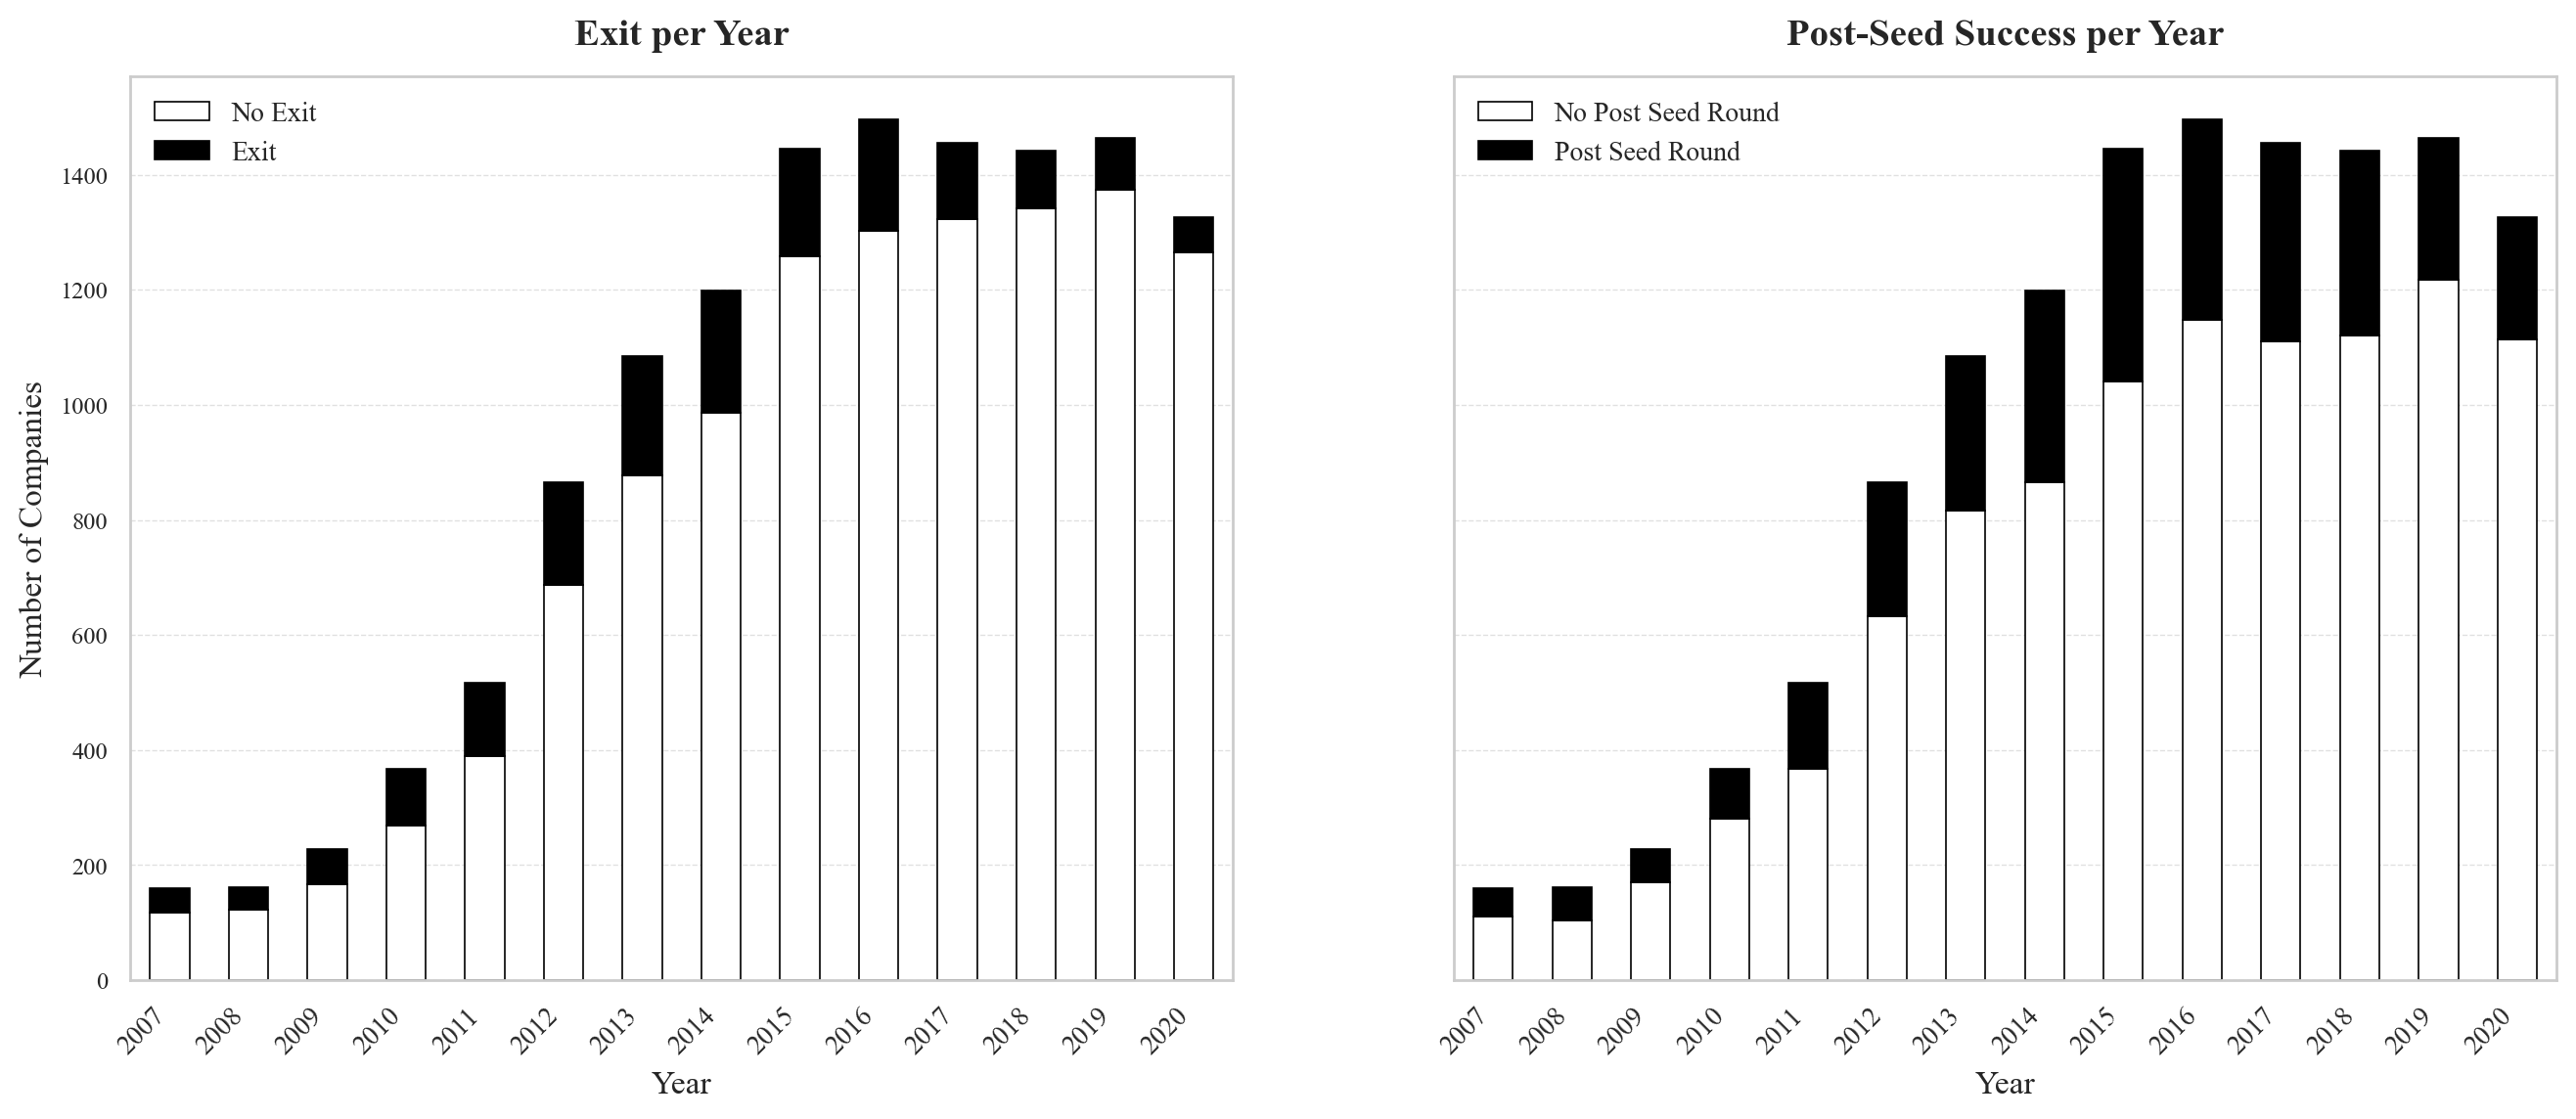

In [129]:
year_success_exit = df.groupby(['founded_year', 'exit_binary']).size().unstack(fill_value=0)
year_success_follow2 = df.groupby(['founded_year', 'follow_2']).size().unstack(fill_value=0)

sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

year_success_exit.plot(
    kind='bar',
    stacked=True,
    color={0: "white", 1: "black"},
    ax=axes[0],
    edgecolor='black',
    linewidth=0.6
)
axes[0].set_xlabel("Year", fontsize=12)
axes[0].set_ylabel("Number of Companies", fontsize=12)
axes[0].set_title("Exit per Year", fontsize=14, weight='bold', pad=12)
axes[0].legend(["No Exit", "Exit"], frameon=False, fontsize=10)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=10)
axes[0].yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
axes[0].xaxis.grid(False)

year_success_follow2.plot(
    kind='bar',
    stacked=True,
    color={0: "white", 1: "black"},
    ax=axes[1],
    edgecolor='black',
    linewidth=0.6
)
axes[1].set_xlabel("Year", fontsize=12)
axes[1].set_title("Post-Seed Success per Year", fontsize=14, weight='bold', pad=12)
axes[1].legend(["No Post Seed Round", "Post Seed Round"], frameon=False, fontsize=10)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=10)
axes[1].yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
axes[1].xaxis.grid(False)

plt.savefig("data/visualization/success/success_exit_follow2_stacked_per_year.pdf", bbox_inches="tight")

Exit / Follow on round inside 2 years stacked by sectors

/var/folders/n8/ynbdx9r10lv6l8yh1m_hmbsh0000gn/T/ipykernel_98815/765085510.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(sector_success["sector"], rotation=45, ha='right', fontsize=10)
/var/folders/n8/ynbdx9r10lv6l8yh1m_hmbsh0000gn/T/ipykernel_98815/765085510.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(sector_success["sector"], rotation=45, ha='right', fontsize=10)
maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
JSTF dropped
DSIG dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 18 glyphs before
Glyph names: ['E', 'P', 'S', 'c', 'd', 'e', 'i', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'uni0000', 'uni000D', 'x']
Glyph IDs:   [0, 1, 2, 3

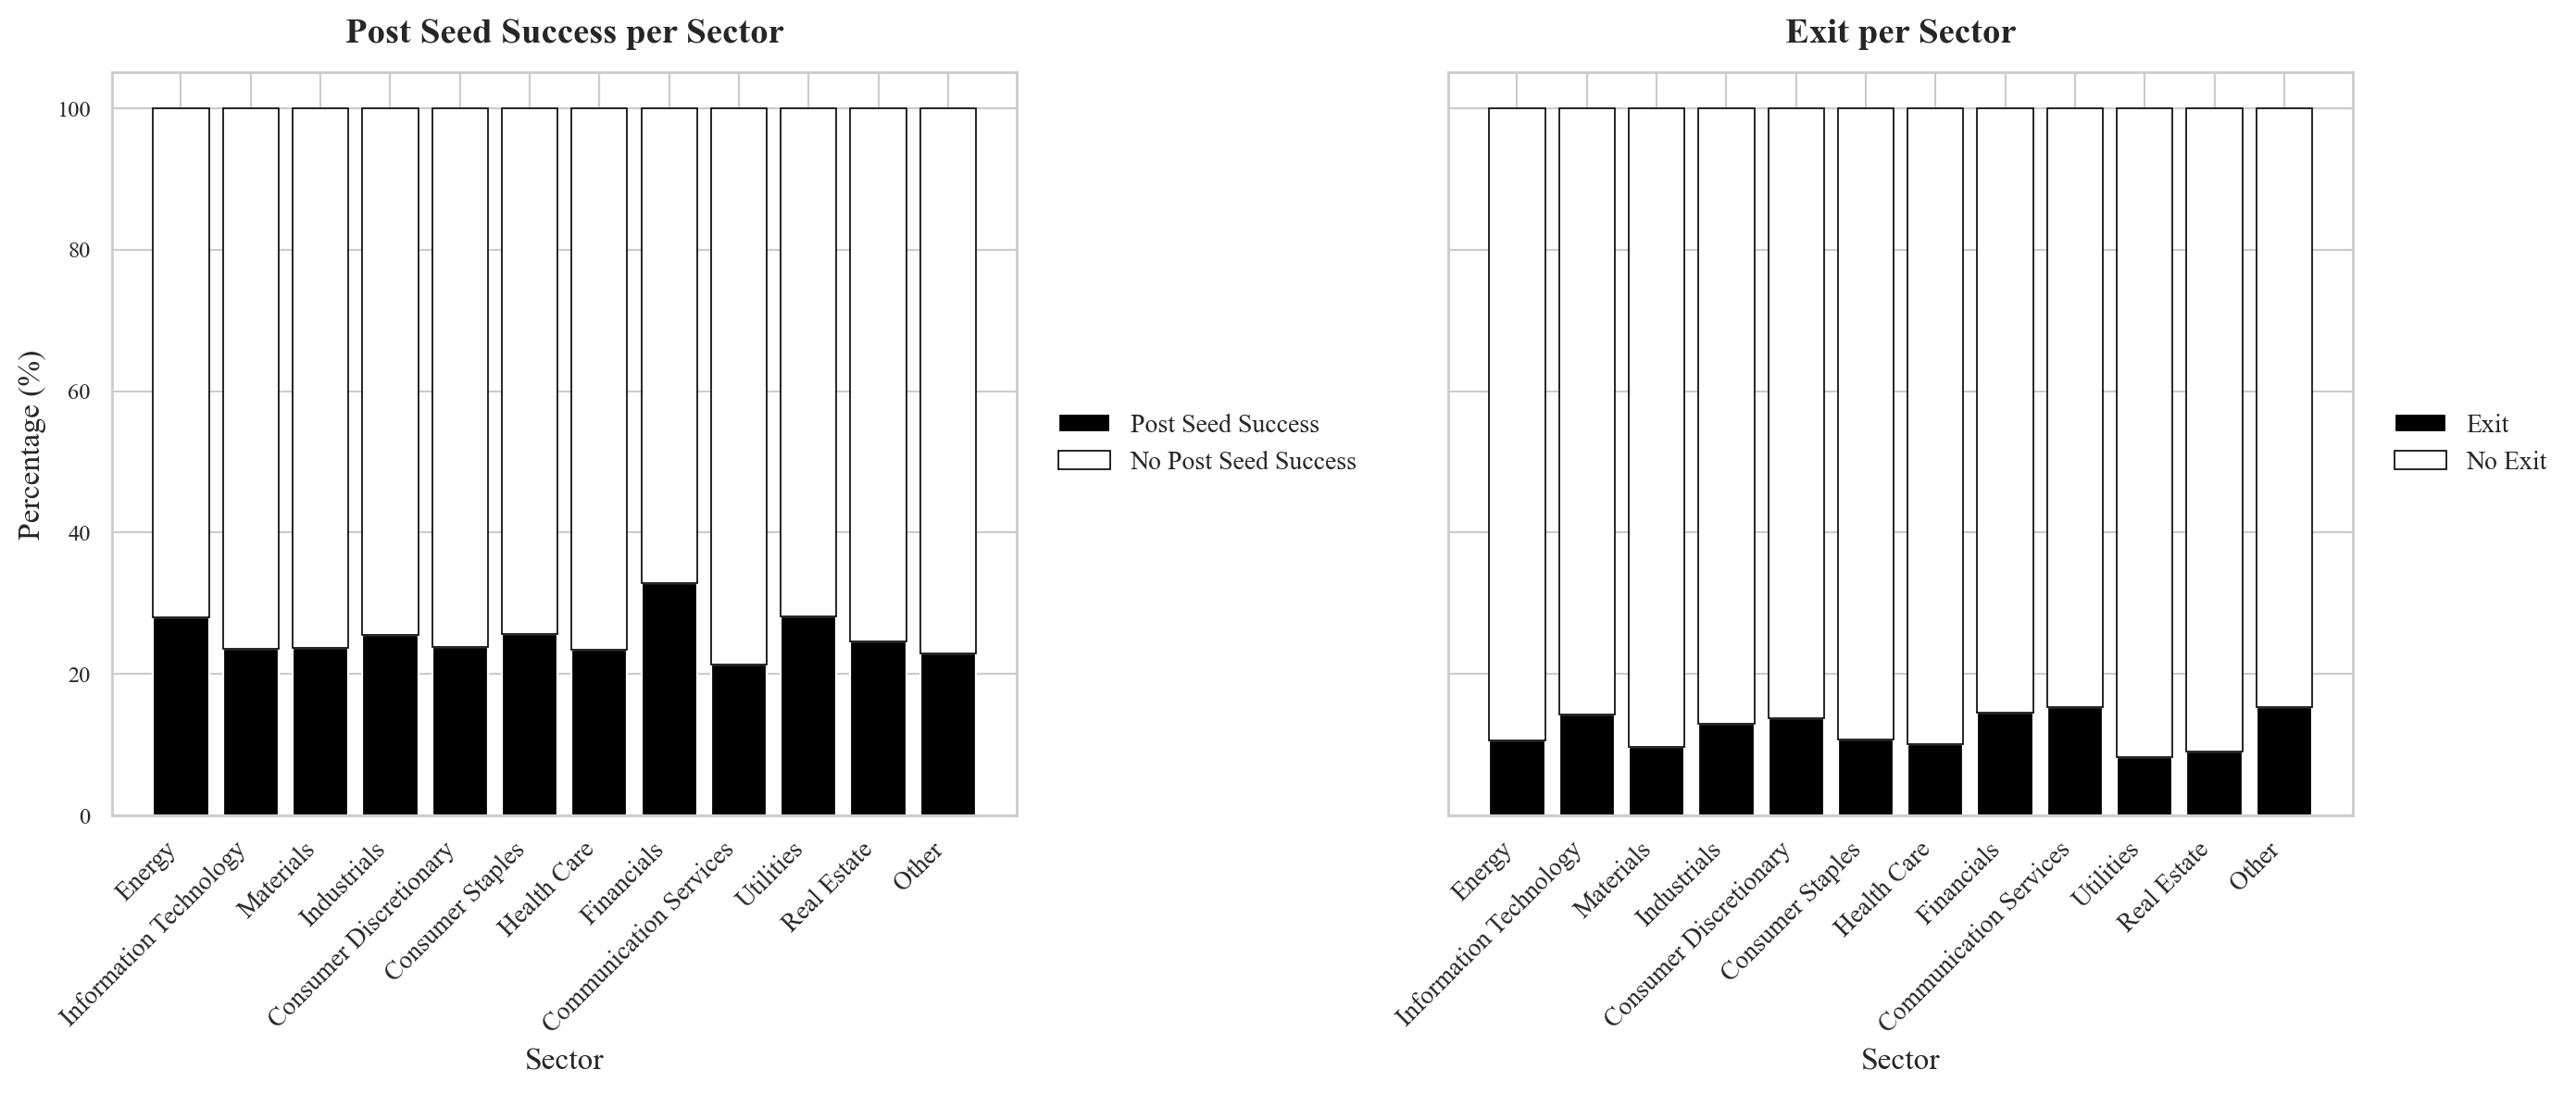

In [130]:
sector_success_data = []

for col, name in zip(industry_columns, sector_display_names):
    sector_df = df[df[col] == 1]
    if len(sector_df) > 0:
        follow_2_pct = sector_df['follow_2'].mean() * 100
        exit_pct = sector_df['exit_binary'].mean() * 100
    else:
        follow_2_pct = 0
        exit_pct = 0
    sector_success_data.append({
        "sector": name,
        "follow_2": round(follow_2_pct, 2),
        "exit_binary": round(exit_pct, 2)
    })

sector_success = pd.DataFrame(sector_success_data)

sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].bar(
    sector_success["sector"], 
    sector_success["follow_2"], 
    color="black", label="Post Seed Success"
)
axes[0].bar(
    sector_success["sector"], 
    100 - sector_success["follow_2"], 
    bottom=sector_success["follow_2"],
    color="white", edgecolor="black", linewidth=0.6, label="No Post Seed Success"
)
axes[0].set_title("Post Seed Success per Sector", fontsize=14, weight='bold', pad=12)
axes[0].set_xlabel("Sector", fontsize=12)
axes[0].set_ylabel("Percentage (%)", fontsize=12)
axes[0].set_xticklabels(sector_success["sector"], rotation=45, ha='right', fontsize=10)
axes[0].legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=10
)

axes[1].bar(
    sector_success["sector"], 
    sector_success["exit_binary"], 
    color="black", label="Exit"
)
axes[1].bar(
    sector_success["sector"], 
    100 - sector_success["exit_binary"], 
    bottom=sector_success["exit_binary"],
    color="white", edgecolor="black", linewidth=0.6, label="No Exit"
)
axes[1].set_title("Exit per Sector", fontsize=14, weight='bold', pad=12)
axes[1].set_xlabel("Sector", fontsize=12)
axes[1].set_xticklabels(sector_success["sector"], rotation=45, ha='right', fontsize=10)
axes[1].legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=10
)

plt.tight_layout()
plt.savefig("data/visualization/success/sector_success_stacked.pdf", bbox_inches="tight")

Exit / Follow on success within 2 years per sector

maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
JSTF dropped
DSIG dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 18 glyphs before
Glyph names: ['E', 'P', 'S', 'c', 'd', 'e', 'i', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'uni0000', 'uni000D', 'x']
Glyph IDs:   [0, 1, 2, 3, 40, 51, 54, 70, 71, 72, 76, 82, 83, 85, 86, 87, 88, 91]
Closed glyph list over 'GSUB': 18 glyphs after
Glyph names: ['E', 'P', 'S', 'c', 'd', 'e', 'i', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'uni0000', 'uni000D', 'x']
Glyph IDs:   [0, 1, 2, 3, 40, 51, 54, 70, 71, 72, 76, 82, 83, 85, 86, 87, 88, 91]
Closing glyph list over 'glyf': 18 glyphs before
Glyph names: ['E', 'P', 'S', 'c', 'd', 'e', 'i', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'uni0000', 'uni000D', 'x']
Glyph IDs:   [0, 1, 2, 3, 40, 51, 54, 70, 71, 72, 76, 82, 83, 85, 86, 87, 88, 91]
Closed glyph

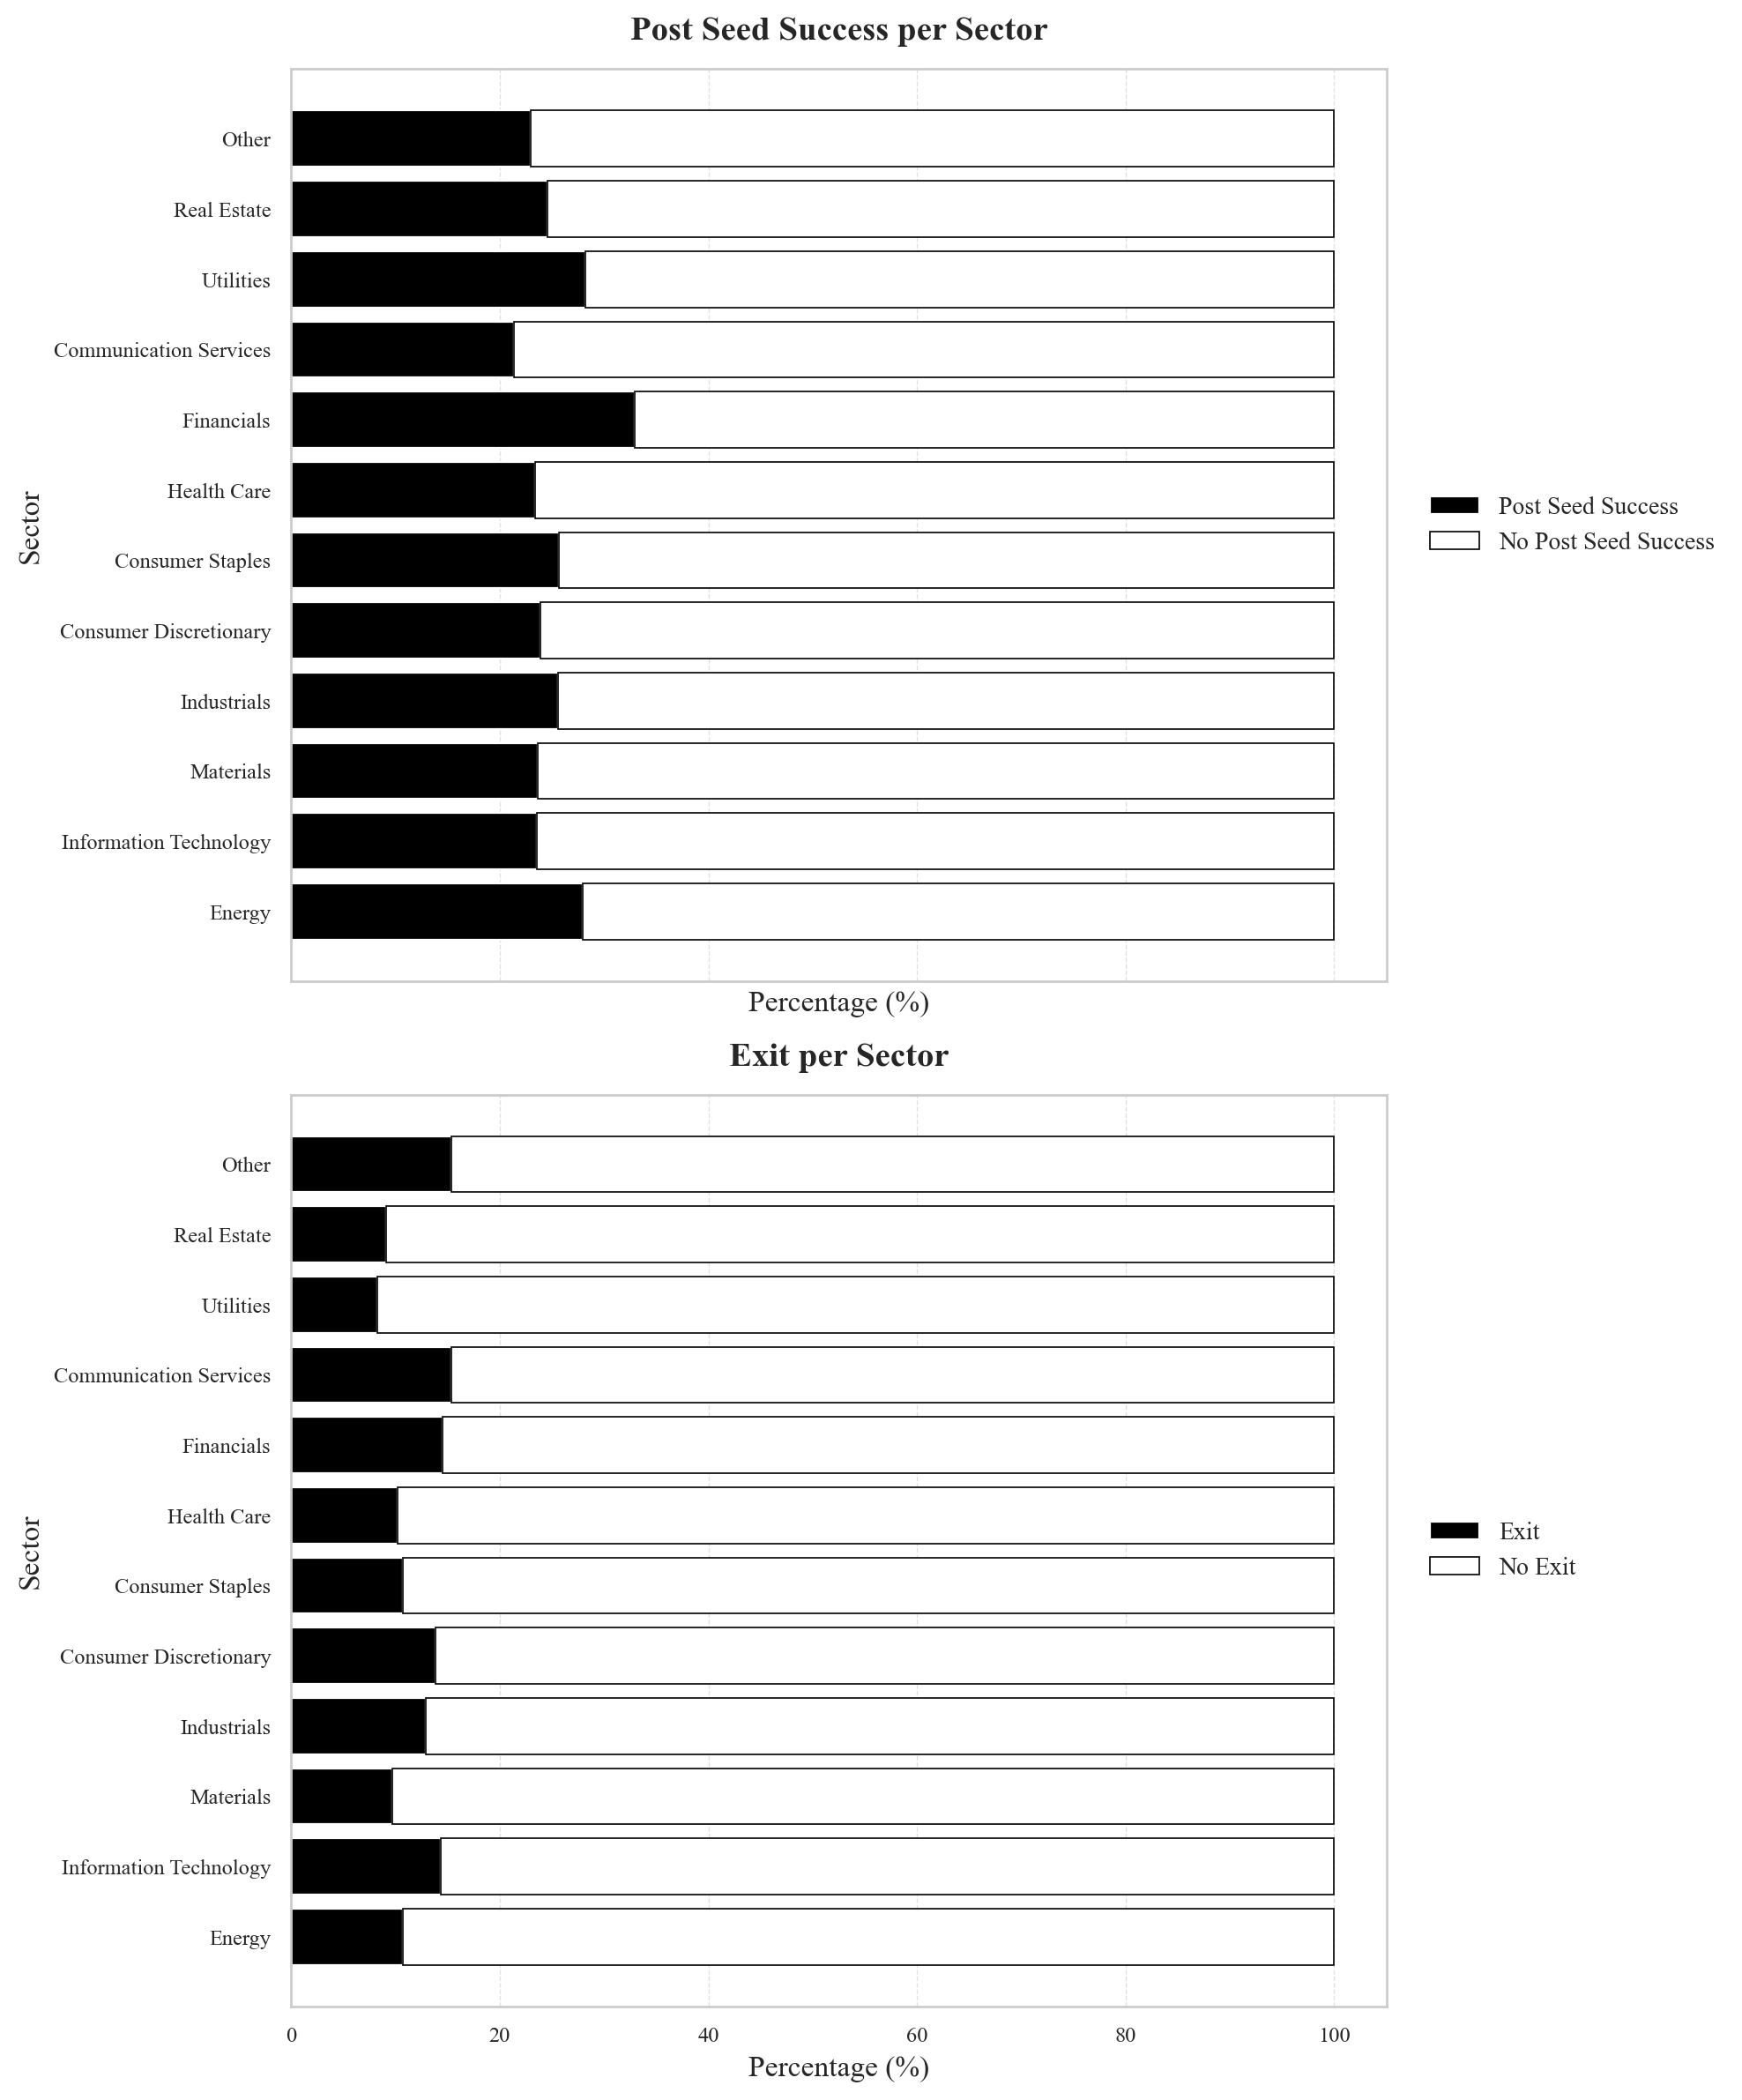

In [131]:
sector_success_data = []

for col, name in zip(industry_columns, sector_display_names):
    sector_df = df[df[col] == 1]
    if len(sector_df) > 0:
        follow_2_pct = sector_df['follow_2'].mean() * 100
        exit_pct = sector_df['exit_binary'].mean() * 100
    else:
        follow_2_pct = 0
        exit_pct = 0
    sector_success_data.append({
        "sector": name,
        "follow_2": round(follow_2_pct, 2),
        "exit_binary": round(exit_pct, 2)
    })

sector_success = pd.DataFrame(sector_success_data)

sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})

fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

axes[0].barh(
    sector_success["sector"],
    sector_success["follow_2"],
    color="black",
    label="Post Seed Success"
)
axes[0].barh(
    sector_success["sector"],
    100 - sector_success["follow_2"],
    left=sector_success["follow_2"],
    color="white",
    edgecolor="black",
    linewidth=0.6,
    label="No Post Seed Success"
)
axes[0].set_title("Post Seed Success per Sector", fontsize=14, weight='bold', pad=12)
axes[0].set_xlabel("Percentage (%)", fontsize=12)
axes[0].set_ylabel("Sector", fontsize=12)
axes[0].legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=10
)
axes[0].xaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
axes[0].yaxis.grid(False)

axes[1].barh(
    sector_success["sector"],
    sector_success["exit_binary"],
    color="black",
    label="Exit"
)
axes[1].barh(
    sector_success["sector"],
    100 - sector_success["exit_binary"],
    left=sector_success["exit_binary"],
    color="white",
    edgecolor="black",
    linewidth=0.6,
    label="No Exit"
)
axes[1].set_title("Exit per Sector", fontsize=14, weight='bold', pad=12)
axes[1].set_xlabel("Percentage (%)", fontsize=12)
axes[1].set_ylabel("Sector", fontsize=12)
axes[1].legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=10
)
axes[1].xaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
axes[1].yaxis.grid(False)

plt.tight_layout()
plt.savefig("data/visualization/success/sector_success_stacked.pdf", bbox_inches="tight")

Exit / Follow on success within 2 years per country

maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
JSTF dropped
DSIG dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 22 glyphs before
Glyph names: ['C', 'E', 'P', 'S', 'ampersand', 'c', 'd', 'e', 'i', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'uni0000', 'uni000D', 'x', 'y']
Glyph IDs:   [0, 1, 2, 3, 9, 38, 40, 51, 54, 70, 71, 72, 76, 81, 82, 83, 85, 86, 87, 88, 91, 92]
Closed glyph list over 'GSUB': 22 glyphs after
Glyph names: ['C', 'E', 'P', 'S', 'ampersand', 'c', 'd', 'e', 'i', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'uni0000', 'uni000D', 'x', 'y']
Glyph IDs:   [0, 1, 2, 3, 9, 38, 40, 51, 54, 70, 71, 72, 76, 81, 82, 83, 85, 86, 87, 88, 91, 92]
Closing glyph list over 'glyf': 22 glyphs before
Glyph names: ['C', 'E', 'P', 'S', 'ampersand', 'c', 'd', 'e', 'i', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'uni0000', '

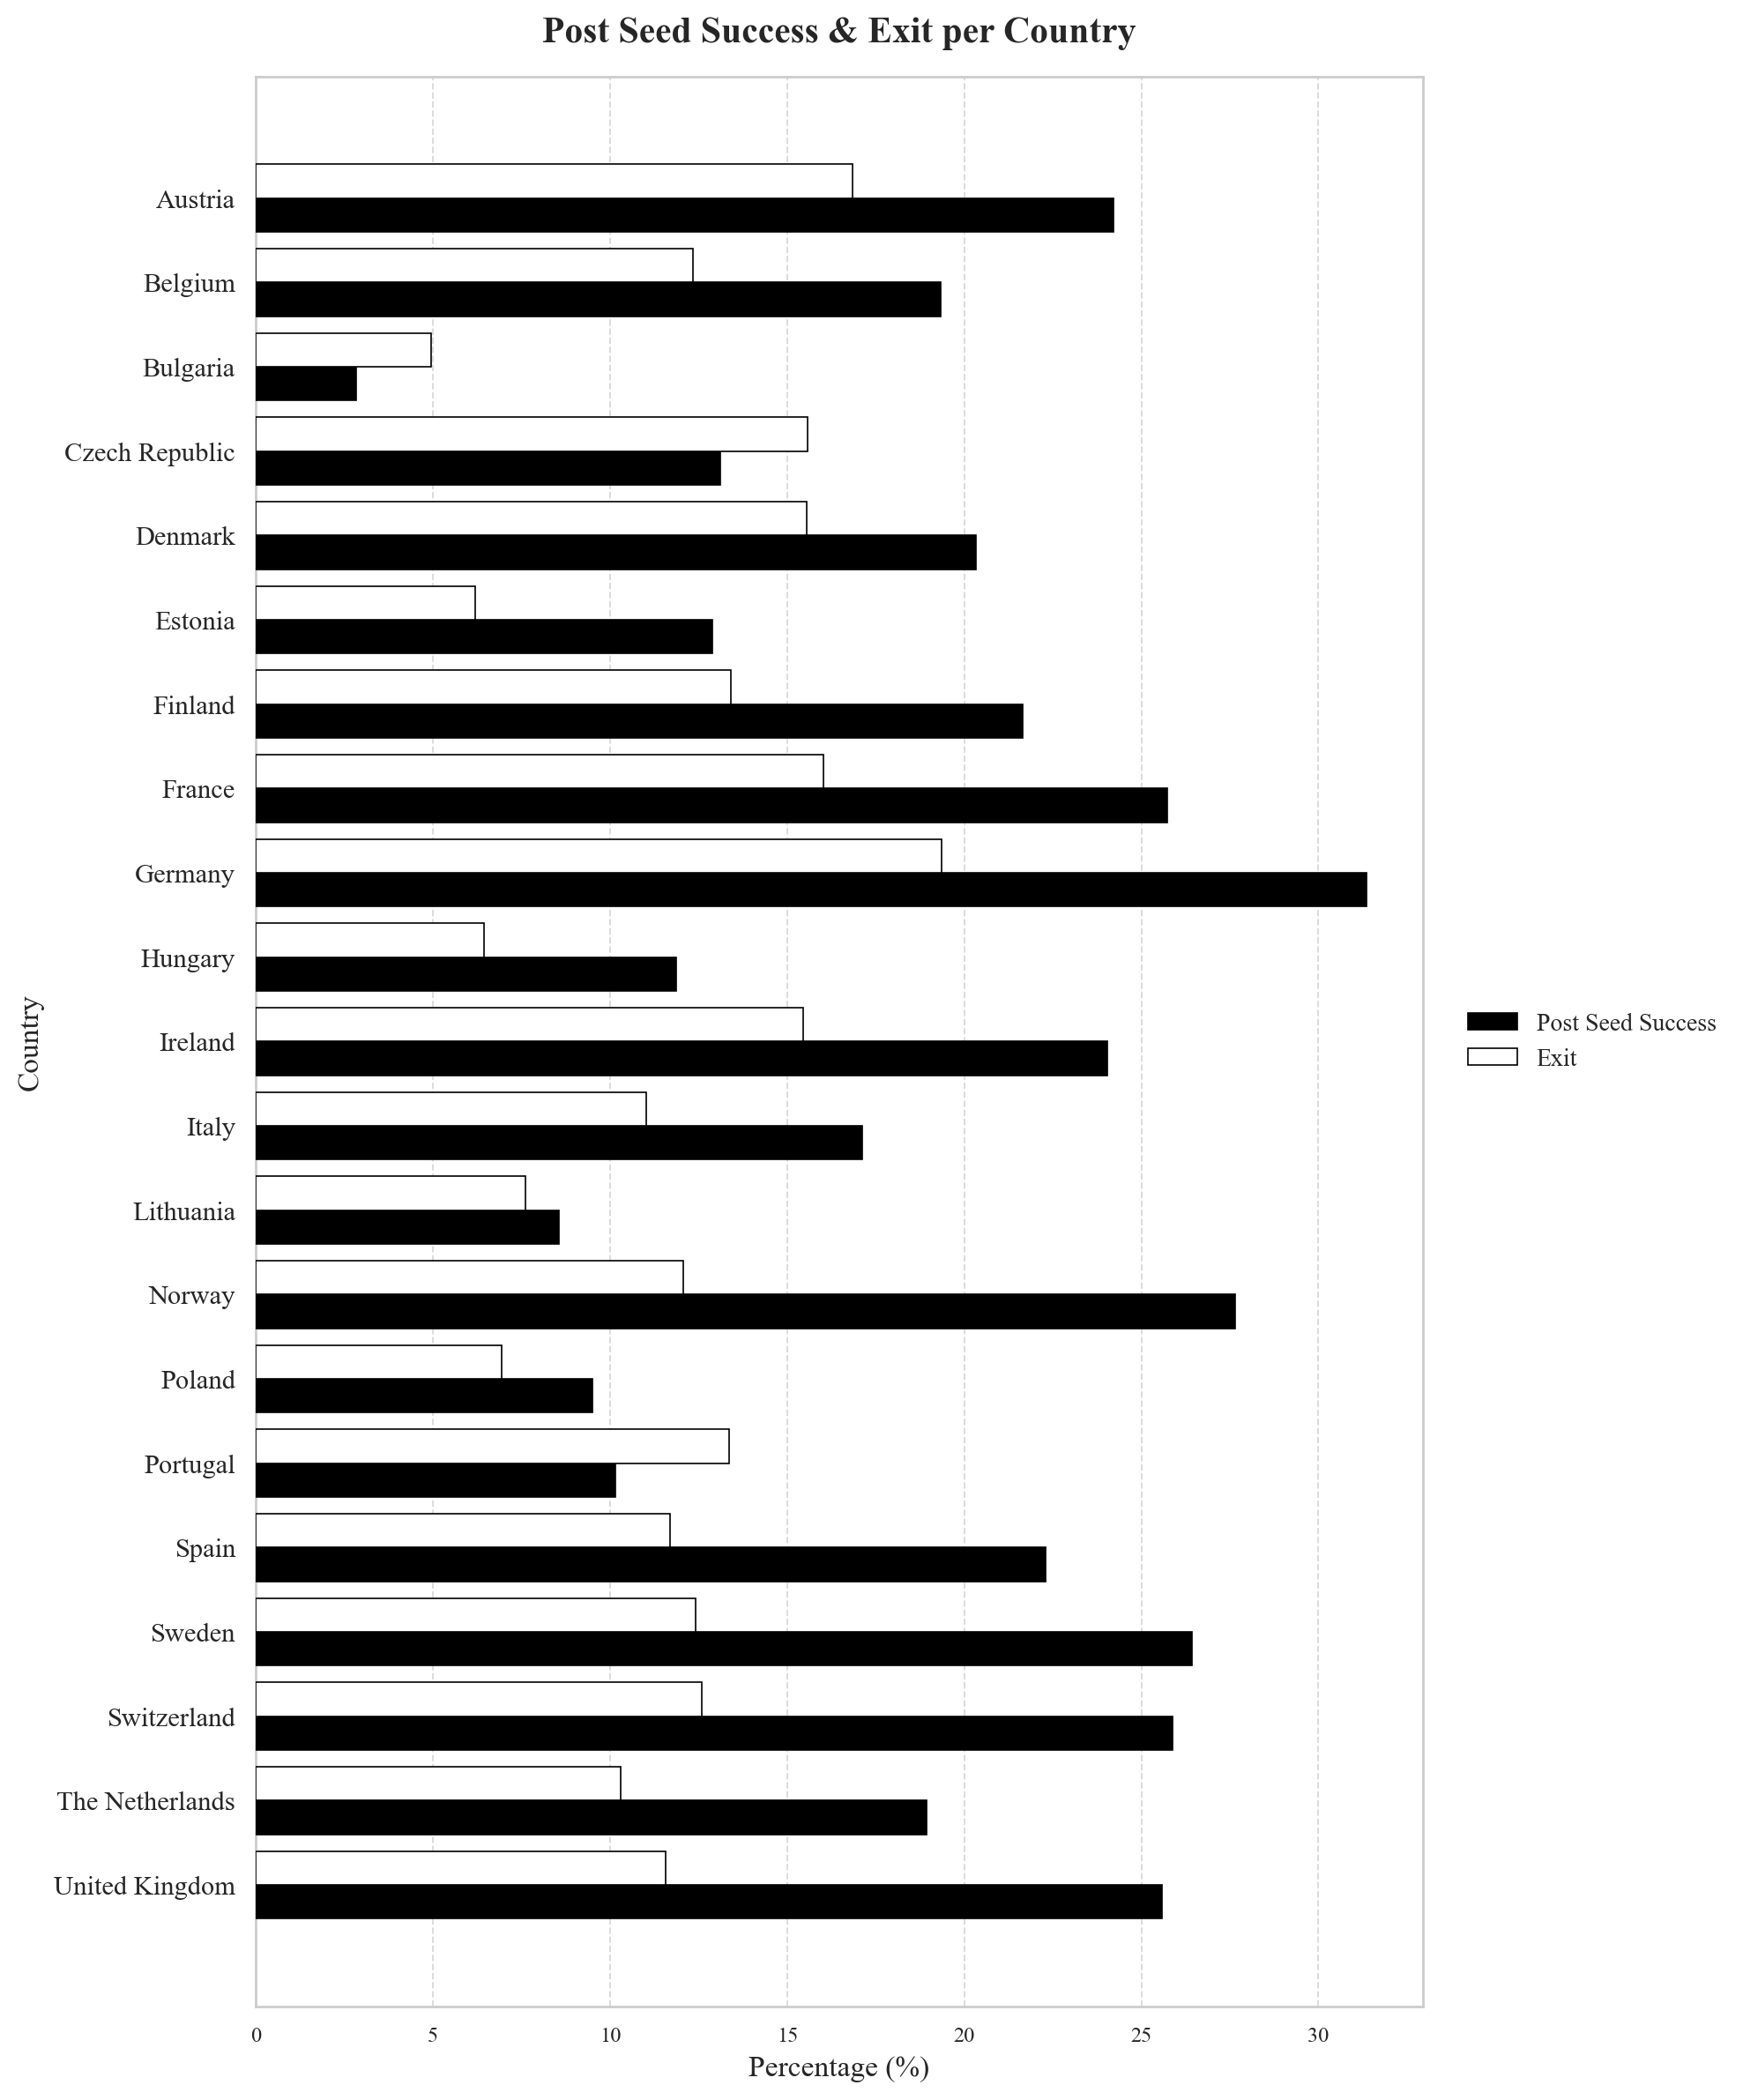

In [132]:
grouped = df.groupby('hq_country')

data = []
for country, group in grouped:
    if group.shape[0] >= 5: 
        follow_2_pct = group['follow_2'].mean() * 100
        exit_pct = group['exit_binary'].mean() * 100
        data.append({
            "Group": country,
            "follow_2": round(follow_2_pct, 2),
            "exit_binary": round(exit_pct, 2)
        })

table_df = pd.DataFrame(data)

valid_countries = (
    df['hq_country'].value_counts()
    .loc[lambda x: x >= 10]
    .index.tolist()
)

table_df_country = table_df[table_df['Group'].isin(valid_countries)]
table_df_country = table_df_country.sort_values("Group", ascending=False)

sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})

fig, ax = plt.subplots(figsize=(10, 12))

bar_height = 0.4
y = np.arange(len(table_df_country))

ax.barh(
    y - bar_height / 2,
    table_df_country["follow_2"],
    height=bar_height,
    color="black",
    edgecolor="black",
    linewidth=0.6,
    label="Post Seed Success",
    zorder=3
)

ax.barh(
    y + bar_height / 2,
    table_df_country["exit_binary"],
    height=bar_height,
    color="white",
    edgecolor="black",
    linewidth=0.6,
    label="Exit",
    zorder=3
)

ax.set_yticks(y)
ax.set_yticklabels(table_df_country["Group"], fontsize=11)
ax.set_xlabel("Percentage (%)", fontsize=12)
ax.set_ylabel("Country", fontsize=12)
ax.set_title("Post Seed Success & Exit per Country", fontsize=15, weight='bold', pad=14)

ax.xaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7, zorder=4)
ax.yaxis.grid(False)
ax.set_axisbelow(False)

ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=10
)

plt.tight_layout()
plt.savefig("data/visualization/success/country_success_stacked_combined.pdf", bbox_inches="tight")

Margins between follow on financing success and exit success (absolute and percentage)

In [133]:
table_df_country["exit_follow2_margin_absolute"] = table_df_country["exit_binary"] - table_df_country["follow_2"]
table_df_country["exit_follow2_margin_percentage"] = (
    table_df_country["exit_follow2_margin_absolute"] / table_df_country["follow_2"].replace(0, np.nan) * 100
)
print(table_df_country)

              Group  follow_2  exit_binary  exit_follow2_margin_absolute  \
20   United Kingdom     25.59        11.56                        -14.03   
19  The Netherlands     18.94        10.30                         -8.64   
18      Switzerland     25.89        12.59                        -13.30   
17           Sweden     26.42        12.41                        -14.01   
16            Spain     22.30        11.70                        -10.60   
15         Portugal     10.14        13.36                          3.22   
14           Poland      9.51         6.94                         -2.57   
13           Norway     27.66        12.06                        -15.60   
12        Lithuania      8.57         7.62                         -0.95   
11            Italy     17.13        11.02                         -6.11   
10          Ireland     24.05        15.46                         -8.59   
9           Hungary     11.88         6.44                         -5.44   
8           

# Correlation Analysis

In [134]:
correlation_features = [
    "b2b","number_of_founders", "female_founder", "grant_before_seed",
    "first_seed_round_year", "number_seed_rounds", "number_seed_investors", "pre_seed", "follow_on_investor",
    "low_seed_funding", "high_seed_funding", "duration_seed_stage", "lead_investor_in_seed", "all_homecountry_investors_in_seed_binary",
    "regional_seed_investor_binary", "geo_syndication", "hub_binary", "regional_seed_investor_institutional_binary",
    "accelerator_seed_investor_binary", "incubator_seed_investor_binary", "hub_angel_investor", 
    "micro_vc_seed_investor_binary", "corporate_venture_capital_seed_investor_binary",
    "university_program_seed_investor_binary", "entrepreneurship_program_seed_investor_binary",
    "family_investment_office_seed_investor_binary", "gdp", "top_university", "success_follow_2"
]


correlation_matrix = df[correlation_features].corr()
correlation_matrix

,b2b,number_of_founders,female_founder,grant_before_seed,first_seed_round_year,number_seed_rounds,number_seed_investors,pre_seed,follow_on_investor,low_seed_funding,...,incubator_seed_investor_binary,hub_angel_investor,micro_vc_seed_investor_binary,corporate_venture_capital_seed_investor_binary,university_program_seed_investor_binary,entrepreneurship_program_seed_investor_binary,family_investment_office_seed_investor_binary,gdp,top_university,success_follow_2
b2b,1.000000,0.047037,-0.066886,0.076735,0.122247,0.044732,0.036787,0.045644,0.049628,-0.086943,...,-0.015845,-0.026200,-0.012502,0.009654,0.036384,0.019418,0.006832,-0.005424,-0.057651,0.012885
number_of_founders,0.047037,1.000000,0.168439,0.037768,-0.016564,0.104295,0.126319,0.032197,0.081811,-0.098806,...,0.024440,0.082239,0.040788,0.035703,0.021943,-0.003759,0.040253,-0.004866,0.037667,0.127993
female_founder,-0.066886,0.168439,1.000000,0.015027,0.054068,0.014944,0.023298,0.039366,0.007494,0.013252,...,0.011170,0.018516,0.007175,0.014103,0.002495,0.011963,0.005986,-0.017297,0.024202,-0.040400
grant_before_seed,0.076735,0.037768,0.015027,1.000000,0.088922,0.014190,0.020378,0.033169,0.009042,-0.047202,...,0.046349,-0.006618,-0.028832,0.012124,0.018496,0.004031,0.015148,0.027492,0.004440,0.012282
first_seed_round_year,0.122247,-0.016564,0.054068,0.088922,1.000000,-0.080288,0.109785,0.249762,-0.004014,-0.162036,...,-0.002043,0.068775,-0.043083,-0.016841,0.015217,0.032160,0.060196,-0.171022,0.016782,-0.173265
number_seed_rounds,0.044732,0.104295,0.014944,0.014190,-0.080288,1.000000,0.400515,0.310616,0.564004,-0.295736,...,0.090090,0.193405,0.146879,0.089130,0.052087,0.072638,0.072718,0.035355,0.012047,0.055390
number_seed_investors,0.036787,0.126319,0.023298,0.020378,0.109785,0.400515,1.000000,0.159535,0.348852,-0.335768,...,0.082401,0.538844,0.297282,0.133558,0.099780,0.083793,0.171019,-0.083909,0.131756,0.136479
pre_seed,0.045644,0.032197,0.039366,0.033169,0.249762,0.310616,0.159535,1.000000,0.183626,-0.051521,...,0.097477,0.076232,0.036828,-0.000166,0.024587,0.063917,0.029304,-0.100466,0.022414,-0.107664
follow_on_investor,0.049628,0.081811,0.007494,0.009042,-0.004014,0.564004,0.348852,0.183626,1.000000,-0.227049,...,0.018363,0.156728,0.122448,0.063306,0.047090,0.008824,0.060421,0.014081,-0.007641,0.051467
low_seed_funding,-0.086943,-0.098806,0.013252,-0.047202,-0.162036,-0.295736,-0.335768,-0.051521,-0.227049,1.000000,...,-0.019435,-0.224776,-0.110934,-0.028533,-0.028406,-0.013450,-0.067052,0.041832,-0.034201,-0.118212


# Regression Analysis

## Regression Setup & Settings

In [154]:
df = df.copy()

## Model 1: Regional Investor

<img src="model1.png" alt="Data Generation" width="750">

Model Setup

In [188]:
dependent_var = "success_follow_2"
iv_direct     = "all_homecountry_investors_in_seed_binary"
iv_mod        = "regional_seed_investor_venture_capital_binary"
mod1          = "geo_syndication"

# Pre Seed-Stage controls
core_ctrls = [
    "hq_country", "founded_year", "b2b", 
    "number_of_founders", "female_founder", "energy", "information_technology", "materials", "industrials",
    "consumer_discretionary", "consumer_staples", "health_care", "financials",
    "communication_services", "utilities", "real_estate", "other", "grant_before_seed", "angel_round_binary",
    "gdp", "top_university"
]

# Post Seed-Stage controls
full_ctrls = [
    "hq_country", "founded_year", "b2b",
    "energy", "information_technology", "materials", "industrials",
    "consumer_discretionary", "consumer_staples", "health_care",
    "financials", "communication_services", "utilities", "real_estate", "other",
    "number_of_founders", "female_founder", "grant_before_seed",
    "first_seed_round_year", "number_seed_rounds", "number_seed_investors", "pre_seed", "follow_on_investor",
    "low_seed_funding", "high_seed_funding", "duration_seed_stage", "lead_investor_in_seed",
    "accelerator_seed_investor_binary", "incubator_seed_investor_binary", "angel_round_binary",
    "micro_vc_seed_investor_binary", "corporate_venture_capital_seed_investor_binary",
    "university_program_seed_investor_binary", "entrepreneurship_program_seed_investor_binary",
    "family_investment_office_seed_investor_binary", "gdp", "top_university"
]

df[dependent_var] = df[dependent_var].astype(int)

# Interaction
df["MOD1_INT"] = df[iv_mod] * df[mod1]

# 1) Pre-Controls -> DV
formula_1 = f"{dependent_var} ~ " + " + ".join(core_ctrls)

# 2) Post-Controls -> DV (only controls)
formula_2 = f"{dependent_var} ~ " + " + ".join(full_ctrls)

# 3) IV_mod + Post-Controls -> DV
formula_3 = f"{dependent_var} ~ {iv_mod} + " + " + ".join(full_ctrls)

# 4) IV_mod + Post-Controls + Interaction (with mod1)
formula_4 = f"{dependent_var} ~ {iv_mod} + {mod1} + MOD1_INT + " + " + ".join(full_ctrls)

# 5) IV_direct + Post-Controls -> DV
formula_5 = f"{dependent_var} ~ {iv_direct} + " + " + ".join(full_ctrls)

cluster_kwds = {'groups': df['hq_country']}

m1c = smf.logit(formula_1, data=df).fit(cov_type='cluster', cov_kwds=cluster_kwds, disp=False)
m2c = smf.logit(formula_2, data=df).fit(cov_type='cluster', cov_kwds=cluster_kwds, disp=False)
m3c = smf.logit(formula_3, data=df).fit(cov_type='cluster', cov_kwds=cluster_kwds, disp=False)
m4c = smf.logit(formula_4, data=df).fit(cov_type='cluster', cov_kwds=cluster_kwds, disp=False)
m5c = smf.logit(formula_5, data=df).fit(cov_type='cluster', cov_kwds=cluster_kwds, disp=False)

stargazer = Stargazer([m1c, m2c, m3c, m4c, m5c])
stargazer.title("Logit (Country-Clustered SEs): Pre vs Post Controls, IV_mod/IV_direct, Interaktion")
stargazer.custom_columns(
    ["(1) Pre-model (only controls)", "(2) Post-model (only controls)", "(3) Post-model (IV1 + controls)", "(4) Post-model (IV1 + interaction + controls)", "(5) Post-model (IV2 + controls)"],
    [1, 1, 1, 1, 1]
)

stargazer.significance_levels([0.10, 0.05, 0.01])

models = [m1c, m2c, m3c, m4c, m5c]

def fmt2(x):
    return f"{x:,.2f}"

loglik    = [fmt2(m.llf) for m in models]                     
lr_chi2   = [fmt2(m.llr) for m in models]                    
lr_pval   = [f"{m.llr_pvalue:.3g}" for m in models]          

stargazer.add_line("Log-Likelihood", loglik)
stargazer.add_line("LR Chi\u00b2", lr_chi2)
stargazer.add_line("LR p-value", lr_pval)

HTML(stargazer.render_html())

## Model 2: Hub Presence

<img src="model2.png" alt="Data Generation" width="750">

Model Setup

In [156]:
# Define variables
dependent_var = "success_follow_2"
iv_mod        = "hub_binary"
mod1          = "regional_seed_investor_venture_capital_binary"

# Pre Seed-Stage controls
core_ctrls = [
    "hq_country", "founded_year", "b2b", 
    "number_of_founders", "female_founder", "energy", "information_technology", "materials", "industrials",
    "consumer_discretionary", "consumer_staples", "health_care", "financials",
    "communication_services", "utilities", "real_estate", "other", "grant_before_seed", "angel_round_binary",
    "gdp", "top_university"
]

# Post Seed-Stage controls
full_ctrls = [
    "hq_country", "founded_year", "b2b", 
    "energy", "information_technology", "materials", "industrials", 
    "consumer_discretionary", "consumer_staples", "health_care",
    "financials", "communication_services", "utilities", "real_estate", "other",
    "number_of_founders", "female_founder", "grant_before_seed", "angel_round_binary",
    "first_seed_round_year", "number_seed_rounds", "number_seed_investors", "pre_seed", "follow_on_investor", 
    "low_seed_funding", "high_seed_funding", "duration_seed_stage", "lead_investor_in_seed",
    "accelerator_seed_investor_binary", "incubator_seed_investor_binary",
    "micro_vc_seed_investor_binary", "corporate_venture_capital_seed_investor_binary",
    "university_program_seed_investor_binary", "entrepreneurship_program_seed_investor_binary",
    "family_investment_office_seed_investor_binary", "gdp", "top_university"
]

df[dependent_var] = df[dependent_var].astype(int)

# Interaction
df["MOD1_INT"] = df[iv_mod] * df[mod1]

# 1) Pre-Controls -> DV
formula_1 = f"{dependent_var} ~ " + " + ".join(core_ctrls)

# 2) Post-Controls -> DV (only controls)
formula_2 = f"{dependent_var} ~ " + " + ".join(full_ctrls)

# 3) IV_mod + Post-Controls -> DV
formula_3 = f"{dependent_var} ~ {iv_mod} + " + " + ".join(full_ctrls)

# 4) IV_mod + Post-Controls + Interaction (with mod1)
formula_4 = f"{dependent_var} ~ {iv_mod} + {mod1} + MOD1_INT + " + " + ".join(full_ctrls)


cluster_kwds = {'groups': df['hq_country']}

m1c = smf.logit(formula_1, data=df).fit(cov_type='cluster', cov_kwds=cluster_kwds, disp=False)
m2c = smf.logit(formula_2, data=df).fit(cov_type='cluster', cov_kwds=cluster_kwds, disp=False)
m3c = smf.logit(formula_3, data=df).fit(cov_type='cluster', cov_kwds=cluster_kwds, disp=False)
m4c = smf.logit(formula_4, data=df).fit(cov_type='cluster', cov_kwds=cluster_kwds, disp=False)

stargazer = Stargazer([m1c, m2c, m3c, m4c])
stargazer.title("Logit (Country-Clustered SEs): Pre vs Post Controls, IV_mod/IV_direct, Interaktion")
stargazer.custom_columns(
    ["(1) Pre-model (only controls)", "(2) Post-model (only controls)", "(3) Post-model (IV_mod + controls)", "(4) Post-model (IV_mod + Inter + controls)"],
    [1, 1, 1, 1]
)

stargazer.significance_levels([0.1, 0.05, 0.01])

models = [m1c, m2c, m3c, m4c]

def fmt2(x):
    return f"{x:,.2f}"

loglik    = [fmt2(m.llf) for m in models]                     
lr_chi2   = [fmt2(m.llr) for m in models]                    
lr_pval   = [f"{m.llr_pvalue:.3g}" for m in models]          

stargazer.add_line("Log-Likelihood", loglik)
stargazer.add_line("LR Chi\u00b2", lr_chi2)
stargazer.add_line("LR p-value", lr_pval)

HTML(stargazer.render_html())

# Robustness Check

# Appendix

## Approach with and Clusters

Explanation: <br>
Startups located in the same country often share unobserved shocks or common influences—things like changes in regulation, macroeconomic shifts, or localized industry trends. Those shared factors make the residuals (the parts of each observation that your model doesn’t explain) correlated within each country. Ordinary standard errors assume every observation is independent; if that assumption is false, your usual errors will be too small, making you overconfident in your coefficient estimates. Cluster‐robust standard errors relax that assumption. They allow observations within the same country to be correlated in any way you like, while still treating different countries as independent from one another.

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, brier_score_loss

# ---------- Helpers für Namensauflösung & Debug ----------

def list_model_terms(model, head=50):
    """
    Praktischer Debug-Helper: gibt die ersten `head` Parameternamen deines Modells aus.
    """
    idx = model.params.index.astype(str).tolist()
    return pd.Series(idx[:head], name="param_names")

def _expand_model_terms(model, base_terms):
    """
    Mappe 'Basisnamen' (z.B. 'regional_seed_investor_binary', 'MOD1_INT')
    auf die echten Parameternamen im Modell (z.B. 'regional_seed_investor_binary[T.True]').
    Gibt eine Liste gefundener Parameternamen in der Reihenfolge der base_terms zurück.
    """
    import re
    idx = model.params.index.astype(str).tolist()
    resolved = []

    for base in base_terms:
        # 1) exakter Treffer
        if base in idx:
            resolved.append(base)
            continue

        # 2) typische patsy-Formen: var[T.*], C(var)[T.*]
        pattern_candidates = [
            rf"^{re.escape(base)}\[T\.[^\]]+\]$",
            rf"^C\({re.escape(base)}\)\[T\.[^\]]+\]$",
            # Interaktionen: base erscheint am Anfang/Ende/in der Mitte
            rf"^{re.escape(base)}:.*$",
            rf"^.*:{re.escape(base)}$",
            rf"^.*:{re.escape(base)}:.*$",
        ]
        found = [name for name in idx if any(re.match(p, name) for p in pattern_candidates)]
        if found:
            resolved.extend(found)
        else:
            # nichts gefunden -> wir lassen es weg
            pass

    # Duplikate entfernen (Reihenfolge bewahren)
    seen = set()
    resolved_unique = []
    for x in resolved:
        if x not in seen:
            resolved_unique.append(x)
            seen.add(x)
    return resolved_unique

# ---------- Core helpers ----------

def summarize_or(model, terms=None, alpha=0.05):
    """
    Return Odds Ratios with (1-alpha)% CI and p-values for a statsmodels Logit.
    `terms` akzeptiert Basisnamen; sie werden robust auf Modell-Parameternamen gemappt.
    """
    params = model.params
    conf   = model.conf_int(alpha=alpha)
    out = pd.DataFrame({
        "coef": params,
        "OR": np.exp(params),
        "CI_low": np.exp(conf[0]),
        "CI_high": np.exp(conf[1]),
        "p_value": model.pvalues
    })
    if terms is not None:
        resolved = _expand_model_terms(model, terms)
        if len(resolved) == 0:
            raise KeyError(
                f"Keine passenden Parameternamen für {terms} gefunden. "
                f"Beispiel-Parameternamen: {list(out.index.astype(str))[:10]} ..."
            )
        out = out.loc[resolved]
    return out


def average_marginal_effects(model, variables=None, at="overall", method="dydx", dummy=True):
    """
    Compute AMEs (cluster-robust model ok). Returns a DataFrame.
    `variables`: list of variable names to keep; if None, return all.
    Achtung: Die Indexnamen in AME-Frames sind oft Basisnamen; falls nicht, filtern wir flexibel.
    """
    margeff = model.get_margeff(at=at, method=method, dummy=dummy).summary_frame()
    # rename common columns for clarity
    rename_map = {"dy/dx": "AME", "Std. Err.": "SE", "z": "z", "P>|z|": "p_value", "[0.025": "CI_low", "0.975]": "CI_high"}
    for k, v in rename_map.items():
        if k in margeff.columns:
            margeff = margeff.rename(columns={k: v})

    if variables is None:
        return margeff

    # robustes Filtern: versuche Basisnamen und ggf. [T.True]
    idx = margeff.index.astype(str)
    picks = []
    for v in variables:
        if v in idx:
            picks.append(v)
        elif f"{v}[T.True]" in idx:
            picks.append(f"{v}[T.True]")
    if picks:
        return margeff.loc[picks]
    # wenn nichts passt, gib einfach alles zurück (oder raise)
    return margeff


def _pick_reference_levels(df, ctrl_cols):
    """
    Build a dict of baseline values for controls:
    - numeric -> column mean (ignores NaN)
    - boolean/integer binaries -> 0
    - categoricals/objects -> mode (first mode if multiple)
    """
    base = {}
    for col in ctrl_cols:
        s = df[col]
        if pd.api.types.is_numeric_dtype(s):
            unique_vals = pd.unique(s.dropna())
            if set(unique_vals).issubset({0,1}) and len(unique_vals) <= 2:
                base[col] = 0
            else:
                base[col] = float(np.nanmean(s))
        else:
            try:
                base[col] = s.mode(dropna=True).iloc[0]
            except Exception:
                base[col] = s.dropna().iloc[0] if s.notna().any() else None
    return base


def scenario_grid_for_interaction(df, iv_mod, mod1, ctrl_cols, quantiles=(0.25, 0.5, 0.75)):
    """
    Construct a scenario DataFrame to probe an interaction between `iv_mod` and `mod1`.
    - If `mod1` looks binary (0/1 or bool), use values [0,1]. Else use given quantiles.
    - For `iv_mod`, use values [0,1] (assumes binary).
    """
    base = _pick_reference_levels(df, ctrl_cols)

    def _values_for(col):
        s = df[col]
        if pd.api.types.is_bool_dtype(s):
            return [False, True]
        if pd.api.types.is_numeric_dtype(s):
            uniq = pd.unique(s.dropna())
            if set(uniq).issubset({0,1}) and len(uniq) <= 2:
                return [0,1]
            q = np.quantile(s.dropna(), quantiles)
            return list(q)
        modes = s.mode(dropna=True)
        if len(modes) >= 2: return [modes.iloc[0], modes.iloc[1]]
        if len(modes) == 1: return [modes.iloc[0]]
        return [None]

    iv_vals = _values_for(iv_mod)
    mod1_vals = _values_for(mod1)

    scen = []
    for iv in iv_vals:
        for m in mod1_vals:
            row = {**base, iv_mod: iv, mod1: m}
            if "MOD1_INT" in df.columns:
                try:
                    row["MOD1_INT"] = float(iv) * float(m)
                except Exception:
                    row["MOD1_INT"] = None
            scen.append(row)
    scen_df = pd.DataFrame(scen)
    return scen_df


def predicted_probabilities(model, newdata):
    """
    Robust für statsmodels Logit/DiscreteResults get_prediction():
    nutzt summary_frame(), fällt sonst auf predict() ohne CI zurück.
    """
    pr = model.get_prediction(newdata)

    # Versuche summary_frame() zuerst (empfohlen)
    try:
        sf = pr.summary_frame()
        cols = sf.columns.str.lower()

        # häufige Varianten in unterschiedlichen statsmodels-Versionen:
        if "predicted" in cols:
            mean = sf.loc[:, cols.get_loc("predicted")]
            ci_low = sf.loc[:, cols.get_loc("ci_lower")] if "ci_lower" in cols else None
            ci_high = sf.loc[:, cols.get_loc("ci_upper")] if "ci_upper" in cols else None
        elif "mean" in cols:
            mean = sf.loc[:, cols.get_loc("mean")]
            # GLM-artige Namen
            if "mean_ci_lower" in cols and "mean_ci_upper" in cols:
                ci_low = sf.loc[:, cols.get_loc("mean_ci_lower")]
                ci_high = sf.loc[:, cols.get_loc("mean_ci_upper")]
            else:
                ci_low = sf.filter(like="lower", axis=1).iloc[:, 0] if sf.filter(like="lower", axis=1).shape[1] else None
                ci_high = sf.filter(like="upper", axis=1).iloc[:, 0] if sf.filter(like="upper", axis=1).shape[1] else None
        else:
            
            cand = [c for c in sf.columns if c.lower().startswith(("pred", "mean"))]
            mean = sf[cand[0]] if cand else pd.Series(model.predict(newdata), index=sf.index)
            # CIs evtl. nicht verfügbar
            lower_cols = [c for c in sf.columns if "low" in c.lower()]
            upper_cols = [c for c in sf.columns if "upp" in c.lower()]
            ci_low = sf[lower_cols[0]] if lower_cols else None
            ci_high = sf[upper_cols[0]] if upper_cols else None

        out = newdata.copy()
        out["pred_prob"] = np.asarray(mean)
        out["ci_low"] = np.asarray(ci_low) if ci_low is not None else np.nan
        out["ci_high"] = np.asarray(ci_high) if ci_high is not None else np.nan
        return out

    except Exception:
        # Harmloser Fallback: keine CIs
        phat = model.predict(newdata)
        out = newdata.copy()
        out["pred_prob"] = np.asarray(phat)
        out["ci_low"] = np.nan
        out["ci_high"] = np.nan
        return out


def model_fit_metrics(y_true, y_hat):
    """
    Compute AUC and Brier for given true labels and predicted probabilities.
    """
    return {
        "AUC": roc_auc_score(y_true, y_hat),
        "Brier": brier_score_loss(y_true, y_hat)
    }


def compare_models_fit(y_true, preds: dict):
    """
    preds: dict name -> predicted probabilities vector
    Returns a DataFrame with AUC and Brier for each model.
    """
    rows = []
    for name, phat in preds.items():
        met = model_fit_metrics(y_true, phat)
        rows.append({"model": name, **met})
    return pd.DataFrame(rows)


def interaction_plot(pp_df, iv_mod, mod1, title="Interaction: Predicted Probabilities"):
    """
    Simple line plot of predicted probabilities across mod1 for each level of iv_mod.
    """
    plt.figure()
    g = pp_df.copy()
    if g[iv_mod].dtype == bool:
        g[iv_mod] = g[iv_mod].astype(int)

    for key, grp in g.groupby(iv_mod):
        grp_sorted = grp.sort_values(mod1)
        plt.plot(grp_sorted[mod1], grp_sorted["pred_prob"], marker="o", label=f"{iv_mod}={key}")
        for _, r in grp_sorted.iterrows():
            plt.vlines(r[mod1], r["ci_low"], r["ci_high"])

    plt.xlabel(mod1)
    plt.ylabel("Predicted probability")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    return plt.gcf()

# ---------- Bequemer Wrapper für dein Setup ----------

def run_all_interpretations(
    df,
    dependent_var,
    iv_mod,
    iv_direct,
    mod1,
    full_ctrls,
    m3c=None,  # Post-model (IV1 + controls)
    m4c=None,  # Post-model (IV1 + interaction + controls)
    m5c=None,  # Post-model (IV2 + controls)
    sesoi_or=(0.91, 1.10),
    sesoi_ame_pp=0.02
):
    """
    Produces:
    - OR tables (robust Namensauflösung)
    - AME tables (robustes Filtern)
    - Predicted probabilities + Interaction-Plot (falls sinnvoll)
    - Fit comparison (AUC, Brier)
    - Clusterinfo
    """
    out = {}

    if "hq_country" in df.columns:
        out["cluster_info"] = pd.DataFrame({
            "n_clusters_hq_country": [df["hq_country"].nunique()]
        })

    # --- ORs (robust gegen [T.True], C(var)[T.*], Interaktionen etc.)
    if m3c is not None:
        out["OR_m3"] = summarize_or(m3c, terms=[iv_mod])
    if m4c is not None:
        out["OR_m4"] = summarize_or(m4c, terms=[iv_mod, mod1, "MOD1_INT"])
    if m5c is not None:
        out["OR_m5"] = summarize_or(m5c, terms=[iv_direct])

    # --- AMEs (versuche Basisnamen bzw. [T.True])
    if m3c is not None:
        out["AME_m3"] = average_marginal_effects(m3c, variables=[iv_mod])
    if m4c is not None:
        out["AME_m4"] = average_marginal_effects(m4c, variables=[iv_mod, mod1, "MOD1_INT"])
    if m5c is not None:
        out["AME_m5"] = average_marginal_effects(m5c, variables=[iv_direct])

    # --- Szenario-Predictions & Plot
    fig = None
    if m4c is not None:
        scen_df = scenario_grid_for_interaction(df, iv_mod, mod1, full_ctrls)
        pp = predicted_probabilities(m4c, scen_df)
        out["PP_interaction"] = pp[[iv_mod, mod1, "pred_prob", "ci_low", "ci_high"]]
        try:
            if pd.api.types.is_numeric_dtype(pp[mod1]) and pp[mod1].nunique() > 1:
                fig = interaction_plot(pp, iv_mod, mod1, title="Interaction: Predicted Probabilities")
        except Exception:
            fig = None

    # --- Fitvergleich
    preds = {}
    if m3c is not None:
        preds["(3) IV1 + controls"] = m3c.predict()
    if m4c is not None:
        preds["(4) IV1 + interaction + controls"] = m4c.predict()
    if m5c is not None:
        preds["(5) IV2 + controls"] = m5c.predict()
    if len(preds) > 0:
        y_true = df[dependent_var].astype(int).values
        out["fit_comparison"] = compare_models_fit(y_true, preds)

    # --- SESOI-Flags
    lo, hi = sesoi_or
    for k in ["OR_m3", "OR_m4", "OR_m5"]:
        if k in out:
            tmp = out[k].copy()
            tmp["practically_relevant_OR"] = ~((tmp["CI_low"] >= lo) & (tmp["CI_high"] <= hi))
            out[k] = tmp
    for k in ["AME_m3", "AME_m4", "AME_m5"]:
        if k in out and "AME" in out[k].columns:
            tmp = out[k].copy()
            tmp["practically_relevant_AME"] = (tmp["AME"].abs() >= sesoi_ame_pp)
            out[k] = tmp

    return out, fig


=== cluster_info ===


,n_clusters_hq_country
0,21



=== OR_m3 ===


,coef,OR,CI_low,CI_high,p_value,practically_relevant_OR
hub_binary[T.True],0.277829,1.32026,1.141409,1.527136,0.000183,True



=== OR_m4 ===


,coef,OR,CI_low,CI_high,p_value,practically_relevant_OR
hub_binary[T.True],0.145499,1.156617,0.979466,1.365808,0.086279,True
regional_seed_investor_venture_capital_binary[T.True],-0.101265,0.903694,0.723874,1.128183,0.371030,True
MOD1_INT[T.True],0.276113,1.317997,1.071789,1.620764,0.008868,True



=== OR_m5 ===


,coef,OR,CI_low,CI_high,p_value,practically_relevant_OR
all_homecountry_investors_in_seed_binary[T.True],-0.228208,0.795959,0.727818,0.870479,5.800530e-07,True



=== AME_m3 ===


,AME,SE,z,Pr(>|z|),Conf. Int. Low,Cont. Int. Hi.,practically_relevant_AME
hub_binary[T.True],0.052207,0.013861,3.766557,0.000166,0.025041,0.079374,True



=== AME_m4 ===


,AME,SE,z,Pr(>|z|),Conf. Int. Low,Cont. Int. Hi.,practically_relevant_AME
hub_binary[T.True],0.027423,0.015947,1.719578,0.085509,-0.003834,0.058679,True
regional_seed_investor_venture_capital_binary[T.True],-0.019074,0.021225,-0.898652,0.368838,-0.060675,0.022527,False
MOD1_INT[T.True],0.052967,0.020402,2.596207,0.009426,0.012981,0.092954,True



=== AME_m5 ===


,AME,SE,z,Pr(>|z|),Conf. Int. Low,Cont. Int. Hi.,practically_relevant_AME
all_homecountry_investors_in_seed_binary[T.True],-0.043231,0.00867,-4.986035,6.163086e-07,-0.060225,-0.026237,True



=== PP_interaction ===


,hub_binary,regional_seed_investor_venture_capital_binary,pred_prob,ci_low,ci_high
0,False,False,0.219868,NaN,NaN
1,False,True,0.202992,NaN,NaN
2,True,False,0.245838,NaN,NaN
3,True,True,0.279672,NaN,NaN



=== fit_comparison ===


,model,AUC,Brier
0,(3) IV1 + controls,0.717419,0.189340
1,(4) IV1 + interaction + controls,0.717931,0.189107
2,(5) IV2 + controls,0.717436,0.189317


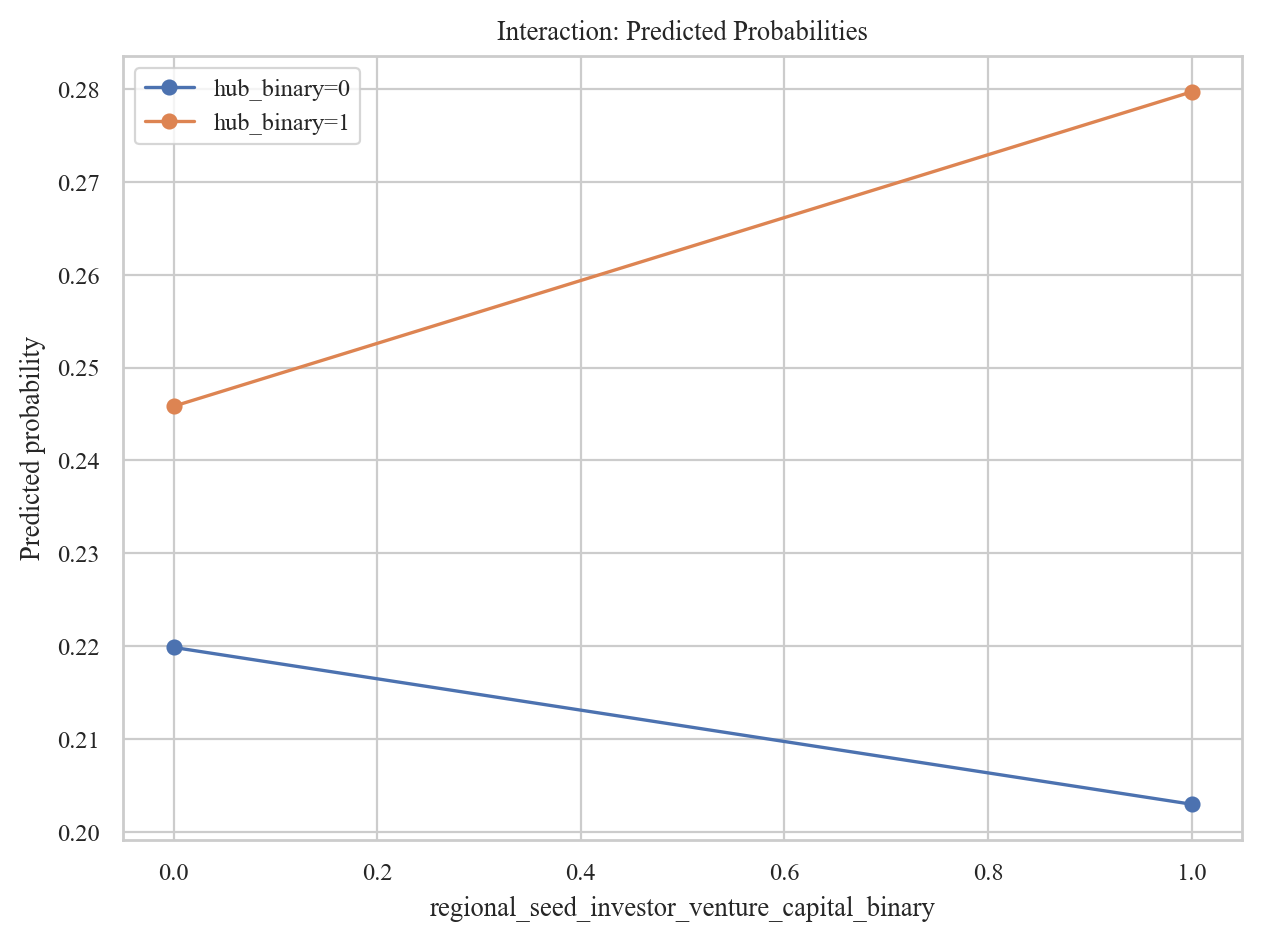

In [139]:
results, fig = run_all_interpretations(
    df=df,
    dependent_var=dependent_var,
    iv_mod=iv_mod,
    iv_direct=iv_direct,
    mod1=mod1,
    full_ctrls=full_ctrls,
    m3c=m3c, m4c=m4c, m5c=m5c,
    sesoi_or=(0.91, 1.10),
    sesoi_ame_pp=0.02
)

for k, v in results.items():
    print(f"\n=== {k} ===")
    display(v)

if fig is not None:
    plt.show()